# Further improvements

This notebook performs pilot studies into possible routes for further improving the classification results obtained from the offline experiments.
This includes:
   - Calibration on 5 minutes worth of data
   - Subsampling electrodes

Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

<hr><hr>

## Table of Contents

- Checking requirements
   - Correct Anaconda environment
   - Correct module access
   - Correct file access
   - Checking TensorFlow support
- Calibrating on 5 minutes of training
   - EEGNet
      - Results
   - LSTM EEGNet
      - Results
- Subsampling electrodes
   - CSP + LDA
      - Results
   - EEGNet
      - Results
   - LSTM EEGNet
      - Results

<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `bci-master-thesis` Anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following code block will load in all required modules.

In [2]:
####################################################
# LOADING MODULES
####################################################

# allow reloading of libraries
import importlib

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset
import TF_tools
importlib.reload(CLA_dataset)
importlib.reload(TF_tools)

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")

# EEGNet model
import EEGModels
from EEGModels import EEGNet

# EEGNet model with LSTM
import EEGNet_with_lstm
from EEGNet_with_lstm import EEGNet_bidirectional_lstm, EEGNet_lstm_1Dconv

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")
import copy

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Deep Learning libraries
import tensorflow as tf;  print(f"TensorFlow version (2.8.0 recommended): {tf.__version__}")

import keras; print(f"Keras version (2.8.0 recommended): {keras.__version__}")
from keras.callbacks import ModelCheckpoint
from keras import backend as K

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Scikit-learn version (1.0.2 recommended): 1.0.2
TensorFlow version (2.8.0 recommended): 2.8.0
Keras version (2.8.0 recommended): 2.8.0
Pickle version (4.0 recommended): 4.0
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. The following code block checks if all required files are available.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr>

### Checking TensorFlow support

If you want to use TensorFlow with GPU acceleration, the below codeblock can help you gather insight.

To launch the tensorboard use the following command in the `paper-notebooks` folder, be sure to have the right environments active:
- Windows: `tensorboard --logdir=./logs/`
- MacOS: `tensorboard --logdir='./logs/'`

In [4]:
TF_tools.check_tf_cpu_gpu_presence()

There are 1 CPUs available under the names:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


There are 1 GPUs available under the names:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<hr><hr>

## Calibrating on 5 minutes of training

In the data collection setup the marker stayed on the screen for one singular second and was followed by a 1.5 – 2.5 second pause after which the next signal was shown.
This totals 3.5 seconds per sample taken.
As such, in 5 minutes, or 300 seconds, 85 samples should be obtainable.
This is reduced to 75 samples in order to obtain 25 samples per class.
These 25 samples per class are then used for calibration of both the EEGNet model and the EEGNet model extension with LSTM provided by us to compare both.
Different layers are frozen to test different setups.

Results for EEGNet base were:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.6927 @ epoch 1473                  | 0.761 @ epoch 1472               | 0.65                                             | 0.6573                                            |
| C           | 0.8837 @ epoch 1159                  | 0.3827 @ epoch 584               | 0.7132                                           | 0.6986                                            |
| E           | 0.7674 @ epoch 782                   | 0.5884 @ epoch 1028              | 0.7068                                           | 0.7246                                            |

Result after calibration are:

In [49]:
EEGNet(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
).layers

In [79]:
####################################################
# CALIBRATE EEGNET ON NEW SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

keras_eegnet_model = EEGNet(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 100, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 8, # number of temporal filters. (default: 8)
        F2 = 16, # number of pointwise filters. (default: 16)
        D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.25, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        )

# Loop over all found results
for subject_id in subject_ids_to_test:
        print()
        print("####################################################")
        print(f"# RESULTS FOR SUBJECT {subject_id}")
        print("####################################################")
        print()
        
        ################### LOAD DATA ###################
        # Names for model
        pretrained_model_name = f"saved_variables/4/samesubject_differentsession/subject{subject_id}/trained_model"
        
        tensorboard_name = f"paper-notebook8_eegnet_calibration_newsession_subject{subject_id}"
        best_base_model_filename =  f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/trained_model"
        
        # Open lowest loss model from file, lowest loss is chosen as it likely needs "least calibration"
        pretrained_model = TF_tools.load_lowest_loss_model(filepath= pretrained_model_name)
        
        # Get train and test split
        with io.capture_output():
                # Get new session data
                mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
                
                # Get epochs for new session
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                
                # Fix the indexing
                # NOTE: this is some weird MNE behaviour, the index retreived is not the actual index if not reset due to filtering done
                mne_epochs.reset_drop_log_selection()
                
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get calibration test split
                calibration_items, test_items = CLA_dataset.get_calibration_test_split_from_epochs(epochs= mne_epochs,
                                                                                                   amount_of_samples_in_calibration_per_class = 25)
                
                
        # Get OHE from file
        with open(f"saved_variables/4/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
                ohe = pickle.load(f)
                
                
        calibration_epochs = mne_epochs[calibration_items]
        test_epochs = mne_epochs[test_items]

        # Get labels
        y_train = calibration_epochs.events[:, -1]
        y_test = test_epochs.events[:, -1]

        # Get train and test data
        X_train = calibration_epochs.get_data(tmin= 0.1, tmax= 0.6)
        X_test = test_epochs.get_data(tmin= 0.1, tmax= 0.6)

        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_train = X_train * 1000000
        X_test = X_test * 1000000
        
        # Further devide the calibration split in train and eval samples
        X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                          y_train,
                                                          test_size = 0.4, # Use 5 samples per class for validation
                                                          shuffle= True,
                                                          stratify= y_train,                                                    
                                                          random_state= 1998)
        
        # Convert labels with OHE for Keras
        y_train = ohe.transform(y_train.reshape(-1, 1)).toarray()
        y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()
        y_val = ohe.transform(y_val.reshape(-1, 1)).toarray()
        
        # Print stats
        print(f"Calibrating with {np.shape(X_train)} windows")
        print(f"Testing with {np.shape(X_test)} windows")
        
        print("Calibrating epochs")
        display(calibration_epochs)
        
        print("test epochs")
        display(test_epochs)
                
        ################### CALIBRATE MODEL ###################
        # Make a calibration model
        calibration_model = keras.models.clone_model(keras_eegnet_model)

        
        # Copy weights from pretrained model
        calibration_model.set_weights(pretrained_model.get_weights())
            
        for layer in calibration_model.layers:
            layer.trainable = False
            
        # Allow last conv layer to learn
        #calibration_model.layers[8].trainable = True # Overfits
            
        # Allow last layers to train (softmax)
        calibration_model.layers[14].trainable = True
        calibration_model.layers[15].trainable = True
        
        # Allow batch norm to train due to weird behaviour
        calibration_model.layers[2].trainable = True
        calibration_model.layers[4].trainable = True
        calibration_model.layers[9].trainable = True
        
        
        # Change dropout
        calibration_model.layers[7].rate = 0
        calibration_model.layers[12].rate = 0.2
        
        # Compile the model so it can be fitted, note a lower learning rate is set
        calibration_model.compile(loss = 'categorical_crossentropy', optimizer = tf.optimizers.Adam(learning_rate= 0.0001), metrics=["accuracy"])
        
        # Train model with GPU as means of recalibrating
        # NOTE: change GPU to CPU if no GPU present
        with tf.device('/gpu:0'):
                history = calibration_model.fit(
                        x= X_train,
                        y= y_train,
                        batch_size= 128, # All calibration data at once
                        epochs= 2500, # Very small due to direct overfit expected
                        verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                        callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                    TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                    TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                        validation_data= (X_val, y_val),
                        shuffle= True,
                        use_multiprocessing= True, # Done for faster speed
                        workers= 4 # Done for faster speed
                        )
                
        # Store the fitting history
        with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                pickle.dump(history.history, file)
                
        # Store the test data
        with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/X_test.pickle", 'wb') as file:
                pickle.dump(X_test, file)
                
        with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/y_test.pickle", 'wb') as file:
                pickle.dump(y_test, file)
       
        # remove unused vars
        del mne_raw
        del mne_epochs
        del pretrained_model_name
        del pretrained_model
        del f
        del X_test
        del y_test
        del ohe
        del calibration_epochs
        del calibration_items
        del test_epochs
        del test_items
        del X_train
        del y_train
        del X_val
        del y_val
        del tensorboard_name
        del history
        del best_base_model_filename
        del calibration_model
        del file
        del layer
        
        
# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset
del keras_eegnet_model



####################################################
# RESULTS FOR SUBJECT B
####################################################

Calibrating with (45, 21, 100) windows
Testing with (885, 21, 100) windows
Calibrating epochs


Number of events,75
Events,task/left: 25task/neutral: 25task/right: 25
Time range,-1.000 – 2.000 sec
Baseline,off


test epochs


Number of events,885
Events,task/left: 297task/neutral: 299task/right: 289
Time range,-1.000 – 2.000 sec
Baseline,off


Epoch 1/2500
1/1 [==============================] - ETA: 0s - loss: 0.9984 - accuracy: 0.5111
Epoch 1: val_loss improved from inf to 0.95016, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_highest_acc_model.hdf5
1/1 [==============================] - 1s 770ms/step - loss: 0.9984 - accuracy: 0.5111 - val_loss: 0.9502 - val_accuracy: 0.6000
Epoch 2/2500
1/1 [==============================] - ETA: 0s - loss: 0.9858 - accuracy: 0.4889
Epoch 2: val_loss did not improve from 0.95016

Epoch 2: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 42ms/step - loss: 0.9858 - accuracy: 0.4889 - val_loss: 0.9524 - val_accuracy: 0.5667
Epoch 3/2500
1/1 [==============================] - ETA: 0s - loss: 1.0229 - accuracy: 0.5556
Epoc

1/1 [==============================] - 0s 57ms/step - loss: 0.9727 - accuracy: 0.4889 - val_loss: 0.9912 - val_accuracy: 0.5667
Epoch 26/2500
1/1 [==============================] - ETA: 0s - loss: 0.9733 - accuracy: 0.5111
Epoch 26: val_loss did not improve from 0.95016

Epoch 26: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 66ms/step - loss: 0.9733 - accuracy: 0.5111 - val_loss: 0.9921 - val_accuracy: 0.5667
Epoch 27/2500
1/1 [==============================] - ETA: 0s - loss: 0.9633 - accuracy: 0.4889
Epoch 27: val_loss did not improve from 0.95016

Epoch 27: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 46ms/step - loss: 0.9633 - accuracy: 0.4889 - val_loss: 0.9930 - val_accuracy: 0.5667
Epoch 28/2500
1/1 [==============================] - ETA: 0s - loss: 1.0021 - accuracy: 0.4889
Epoch 28: val_loss did not improve from 0.95016

Epoch 28: val_accuracy did not improve from 0.60000
1/1 [=======================

Epoch 51/2500
1/1 [==============================] - ETA: 0s - loss: 0.9492 - accuracy: 0.5556
Epoch 51: val_loss did not improve from 0.95016

Epoch 51: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 58ms/step - loss: 0.9492 - accuracy: 0.5556 - val_loss: 0.9975 - val_accuracy: 0.5667
Epoch 52/2500
1/1 [==============================] - ETA: 0s - loss: 1.0004 - accuracy: 0.5111
Epoch 52: val_loss did not improve from 0.95016

Epoch 52: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 51ms/step - loss: 1.0004 - accuracy: 0.5111 - val_loss: 0.9972 - val_accuracy: 0.5667
Epoch 53/2500
1/1 [==============================] - ETA: 0s - loss: 0.9740 - accuracy: 0.5111
Epoch 53: val_loss did not improve from 0.95016

Epoch 53: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 54ms/step - loss: 0.9740 - accuracy: 0.5111 - val_loss: 0.9969 - val_accuracy: 0.5667
Epoch 54/2500
1/1 [=========

1/1 [==============================] - ETA: 0s - loss: 0.9274 - accuracy: 0.5778
Epoch 76: val_loss did not improve from 0.95016

Epoch 76: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 54ms/step - loss: 0.9274 - accuracy: 0.5778 - val_loss: 0.9846 - val_accuracy: 0.5667
Epoch 77/2500
1/1 [==============================] - ETA: 0s - loss: 0.8820 - accuracy: 0.5778
Epoch 77: val_loss did not improve from 0.95016

Epoch 77: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 52ms/step - loss: 0.8820 - accuracy: 0.5778 - val_loss: 0.9841 - val_accuracy: 0.5667
Epoch 78/2500
1/1 [==============================] - ETA: 0s - loss: 0.9046 - accuracy: 0.5556
Epoch 78: val_loss did not improve from 0.95016

Epoch 78: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 53ms/step - loss: 0.9046 - accuracy: 0.5556 - val_loss: 0.9835 - val_accuracy: 0.5667
Epoch 79/2500
1/1 [=======================


Epoch 101: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 42ms/step - loss: 0.8352 - accuracy: 0.6444 - val_loss: 0.9744 - val_accuracy: 0.5333
Epoch 102/2500
1/1 [==============================] - ETA: 0s - loss: 0.9094 - accuracy: 0.5778
Epoch 102: val_loss did not improve from 0.95016

Epoch 102: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 43ms/step - loss: 0.9094 - accuracy: 0.5778 - val_loss: 0.9739 - val_accuracy: 0.5333
Epoch 103/2500
1/1 [==============================] - ETA: 0s - loss: 0.9004 - accuracy: 0.5556
Epoch 103: val_loss did not improve from 0.95016

Epoch 103: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 42ms/step - loss: 0.9004 - accuracy: 0.5556 - val_loss: 0.9732 - val_accuracy: 0.5333
Epoch 104/2500
1/1 [==============================] - ETA: 0s - loss: 0.9136 - accuracy: 0.6000
Epoch 104: val_loss did not improve from 0.95016

Epoch 104: val_acc

1/1 [==============================] - 0s 43ms/step - loss: 0.8645 - accuracy: 0.5778 - val_loss: 0.9579 - val_accuracy: 0.5667
Epoch 127/2500
1/1 [==============================] - ETA: 0s - loss: 0.8824 - accuracy: 0.6000
Epoch 127: val_loss did not improve from 0.95016

Epoch 127: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 46ms/step - loss: 0.8824 - accuracy: 0.6000 - val_loss: 0.9573 - val_accuracy: 0.5667
Epoch 128/2500
1/1 [==============================] - ETA: 0s - loss: 0.8856 - accuracy: 0.6000
Epoch 128: val_loss did not improve from 0.95016

Epoch 128: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 44ms/step - loss: 0.8856 - accuracy: 0.6000 - val_loss: 0.9568 - val_accuracy: 0.5667
Epoch 129/2500
1/1 [==============================] - ETA: 0s - loss: 0.8819 - accuracy: 0.6444
Epoch 129: val_loss did not improve from 0.95016

Epoch 129: val_accuracy did not improve from 0.60000
1/1 [==============


Epoch 148: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 82ms/step - loss: 0.8482 - accuracy: 0.6222 - val_loss: 0.9469 - val_accuracy: 0.5667
Epoch 149/2500
1/1 [==============================] - ETA: 0s - loss: 0.8497 - accuracy: 0.6222
Epoch 149: val_loss improved from 0.94689 to 0.94649, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 149: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 83ms/step - loss: 0.8497 - accuracy: 0.6222 - val_loss: 0.9465 - val_accuracy: 0.5667
Epoch 150/2500
1/1 [==============================] - ETA: 0s - loss: 0.8626 - accuracy: 0.6444
Epoch 150: val_loss improved from 0.94649 to 0.94613, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 150: val_accuracy did not improve from 0.60000
1/1 [=====================


Epoch 166: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 79ms/step - loss: 0.8460 - accuracy: 0.6444 - val_loss: 0.9396 - val_accuracy: 0.5667
Epoch 167/2500
1/1 [==============================] - ETA: 0s - loss: 0.8666 - accuracy: 0.6000
Epoch 167: val_loss improved from 0.93957 to 0.93921, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 167: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 79ms/step - loss: 0.8666 - accuracy: 0.6000 - val_loss: 0.9392 - val_accuracy: 0.5667
Epoch 168/2500
1/1 [==============================] - ETA: 0s - loss: 0.7886 - accuracy: 0.6444
Epoch 168: val_loss improved from 0.93921 to 0.93879, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 168: val_accuracy did not improve from 0.60000
1/1 [=====================


Epoch 184: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 89ms/step - loss: 0.8514 - accuracy: 0.5778 - val_loss: 0.9286 - val_accuracy: 0.5667
Epoch 185/2500
1/1 [==============================] - ETA: 0s - loss: 0.8288 - accuracy: 0.5778
Epoch 185: val_loss improved from 0.92863 to 0.92781, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 185: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 94ms/step - loss: 0.8288 - accuracy: 0.5778 - val_loss: 0.9278 - val_accuracy: 0.5667
Epoch 186/2500
1/1 [==============================] - ETA: 0s - loss: 0.8387 - accuracy: 0.6222
Epoch 186: val_loss improved from 0.92781 to 0.92706, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 186: val_accuracy did not improve from 0.60000
1/1 [=====================

1/1 [==============================] - ETA: 0s - loss: 0.8463 - accuracy: 0.6000
Epoch 202: val_loss improved from 0.91919 to 0.91869, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 202: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 116ms/step - loss: 0.8463 - accuracy: 0.6000 - val_loss: 0.9187 - val_accuracy: 0.6000
Epoch 203/2500
1/1 [==============================] - ETA: 0s - loss: 0.8380 - accuracy: 0.6000
Epoch 203: val_loss improved from 0.91869 to 0.91819, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 203: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 101ms/step - loss: 0.8380 - accuracy: 0.6000 - val_loss: 0.9182 - val_accuracy: 0.6000
Epoch 204/2500
1/1 [==============================] - ETA: 0s - loss: 0.8180 - accuracy: 0.62

Epoch 220/2500
1/1 [==============================] - ETA: 0s - loss: 0.7761 - accuracy: 0.6222
Epoch 220: val_loss improved from 0.91103 to 0.91068, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 220: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 74ms/step - loss: 0.7761 - accuracy: 0.6222 - val_loss: 0.9107 - val_accuracy: 0.6000
Epoch 221/2500
1/1 [==============================] - ETA: 0s - loss: 0.8032 - accuracy: 0.6222
Epoch 221: val_loss improved from 0.91068 to 0.91029, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 221: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 68ms/step - loss: 0.8032 - accuracy: 0.6222 - val_loss: 0.9103 - val_accuracy: 0.6000
Epoch 222/2500
1/1 [==============================] - ETA: 0s - loss: 0.7822 - a

Epoch 238/2500
1/1 [==============================] - ETA: 0s - loss: 0.7328 - accuracy: 0.6667
Epoch 238: val_loss improved from 0.90469 to 0.90437, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 238: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 92ms/step - loss: 0.7328 - accuracy: 0.6667 - val_loss: 0.9044 - val_accuracy: 0.6000
Epoch 239/2500
1/1 [==============================] - ETA: 0s - loss: 0.8411 - accuracy: 0.6222
Epoch 239: val_loss improved from 0.90437 to 0.90398, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 239: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 80ms/step - loss: 0.8411 - accuracy: 0.6222 - val_loss: 0.9040 - val_accuracy: 0.6000
Epoch 240/2500
1/1 [==============================] - ETA: 0s - loss: 0.8052 - a

Epoch 256/2500
1/1 [==============================] - ETA: 0s - loss: 0.7482 - accuracy: 0.6000
Epoch 256: val_loss improved from 0.89746 to 0.89715, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 256: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 80ms/step - loss: 0.7482 - accuracy: 0.6000 - val_loss: 0.8972 - val_accuracy: 0.6000
Epoch 257/2500
1/1 [==============================] - ETA: 0s - loss: 0.7832 - accuracy: 0.6444
Epoch 257: val_loss improved from 0.89715 to 0.89678, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 257: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 80ms/step - loss: 0.7832 - accuracy: 0.6444 - val_loss: 0.8968 - val_accuracy: 0.6000
Epoch 258/2500
1/1 [==============================] - ETA: 0s - loss: 0.7788 - a

Epoch 274/2500
1/1 [==============================] - ETA: 0s - loss: 0.7932 - accuracy: 0.6222
Epoch 274: val_loss improved from 0.89378 to 0.89370, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 274: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 86ms/step - loss: 0.7932 - accuracy: 0.6222 - val_loss: 0.8937 - val_accuracy: 0.6000
Epoch 275/2500
1/1 [==============================] - ETA: 0s - loss: 0.8135 - accuracy: 0.6000
Epoch 275: val_loss improved from 0.89370 to 0.89355, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 275: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 88ms/step - loss: 0.8135 - accuracy: 0.6000 - val_loss: 0.8935 - val_accuracy: 0.6000
Epoch 276/2500
1/1 [==============================] - ETA: 0s - loss: 0.7411 - a

Epoch 292/2500
1/1 [==============================] - ETA: 0s - loss: 0.7695 - accuracy: 0.6667
Epoch 292: val_loss improved from 0.88951 to 0.88919, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 292: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 69ms/step - loss: 0.7695 - accuracy: 0.6667 - val_loss: 0.8892 - val_accuracy: 0.6000
Epoch 293/2500
1/1 [==============================] - ETA: 0s - loss: 0.7302 - accuracy: 0.6444
Epoch 293: val_loss improved from 0.88919 to 0.88884, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 293: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 70ms/step - loss: 0.7302 - accuracy: 0.6444 - val_loss: 0.8888 - val_accuracy: 0.6000
Epoch 294/2500
1/1 [==============================] - ETA: 0s - loss: 0.7224 - a

Epoch 310/2500
1/1 [==============================] - ETA: 0s - loss: 0.7638 - accuracy: 0.6444
Epoch 310: val_loss improved from 0.88365 to 0.88341, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 310: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 83ms/step - loss: 0.7638 - accuracy: 0.6444 - val_loss: 0.8834 - val_accuracy: 0.6000
Epoch 311/2500
1/1 [==============================] - ETA: 0s - loss: 0.7434 - accuracy: 0.6667
Epoch 311: val_loss improved from 0.88341 to 0.88318, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 311: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 78ms/step - loss: 0.7434 - accuracy: 0.6667 - val_loss: 0.8832 - val_accuracy: 0.6000
Epoch 312/2500
1/1 [==============================] - ETA: 0s - loss: 0.7705 - a

1/1 [==============================] - ETA: 0s - loss: 0.7705 - accuracy: 0.6444
Epoch 332: val_loss did not improve from 0.88277

Epoch 332: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 42ms/step - loss: 0.7705 - accuracy: 0.6444 - val_loss: 0.8828 - val_accuracy: 0.6333
Epoch 333/2500
1/1 [==============================] - ETA: 0s - loss: 0.7452 - accuracy: 0.6667
Epoch 333: val_loss improved from 0.88277 to 0.88267, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 333: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 80ms/step - loss: 0.7452 - accuracy: 0.6667 - val_loss: 0.8827 - val_accuracy: 0.6333
Epoch 334/2500
1/1 [==============================] - ETA: 0s - loss: 0.7312 - accuracy: 0.6889
Epoch 334: val_loss improved from 0.88267 to 0.88252, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsess

1/1 [==============================] - ETA: 0s - loss: 0.7862 - accuracy: 0.6444
Epoch 350: val_loss improved from 0.87961 to 0.87959, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 350: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 82ms/step - loss: 0.7862 - accuracy: 0.6444 - val_loss: 0.8796 - val_accuracy: 0.6000
Epoch 351/2500
1/1 [==============================] - ETA: 0s - loss: 0.7445 - accuracy: 0.6667
Epoch 351: val_loss improved from 0.87959 to 0.87950, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 351: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 83ms/step - loss: 0.7445 - accuracy: 0.6667 - val_loss: 0.8795 - val_accuracy: 0.6000
Epoch 352/2500
1/1 [==============================] - ETA: 0s - loss: 0.7622 - accuracy: 0.6889

1/1 [==============================] - ETA: 0s - loss: 0.7331 - accuracy: 0.6889
Epoch 372: val_loss did not improve from 0.87927

Epoch 372: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 39ms/step - loss: 0.7331 - accuracy: 0.6889 - val_loss: 0.8795 - val_accuracy: 0.6000
Epoch 373/2500
1/1 [==============================] - ETA: 0s - loss: 0.7830 - accuracy: 0.7111
Epoch 373: val_loss did not improve from 0.87927

Epoch 373: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 41ms/step - loss: 0.7830 - accuracy: 0.7111 - val_loss: 0.8794 - val_accuracy: 0.6000
Epoch 374/2500
1/1 [==============================] - ETA: 0s - loss: 0.7434 - accuracy: 0.7111
Epoch 374: val_loss did not improve from 0.87927

Epoch 374: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 42ms/step - loss: 0.7434 - accuracy: 0.7111 - val_loss: 0.8793 - val_accuracy: 0.6000
Epoch 375/2500
1/1 [==============

1/1 [==============================] - 0s 73ms/step - loss: 0.7225 - accuracy: 0.6889 - val_loss: 0.8760 - val_accuracy: 0.6000
Epoch 391/2500
1/1 [==============================] - ETA: 0s - loss: 0.7447 - accuracy: 0.6889
Epoch 391: val_loss improved from 0.87602 to 0.87588, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 391: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 72ms/step - loss: 0.7447 - accuracy: 0.6889 - val_loss: 0.8759 - val_accuracy: 0.6000
Epoch 392/2500
1/1 [==============================] - ETA: 0s - loss: 0.7833 - accuracy: 0.6444
Epoch 392: val_loss improved from 0.87588 to 0.87570, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 392: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 72ms/step - loss: 0.7833 - accuracy: 0

1/1 [==============================] - 0s 39ms/step - loss: 0.7759 - accuracy: 0.6667 - val_loss: 0.8748 - val_accuracy: 0.6333
Epoch 410/2500
1/1 [==============================] - ETA: 0s - loss: 0.7556 - accuracy: 0.6667
Epoch 410: val_loss did not improve from 0.87477

Epoch 410: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 40ms/step - loss: 0.7556 - accuracy: 0.6667 - val_loss: 0.8748 - val_accuracy: 0.6333
Epoch 411/2500
1/1 [==============================] - ETA: 0s - loss: 0.7359 - accuracy: 0.7111
Epoch 411: val_loss did not improve from 0.87477

Epoch 411: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 41ms/step - loss: 0.7359 - accuracy: 0.7111 - val_loss: 0.8749 - val_accuracy: 0.6333
Epoch 412/2500
1/1 [==============================] - ETA: 0s - loss: 0.7653 - accuracy: 0.6889
Epoch 412: val_loss did not improve from 0.87477

Epoch 412: val_accuracy did not improve from 0.63333
1/1 [==============

Epoch 430/2500
1/1 [==============================] - ETA: 0s - loss: 0.7330 - accuracy: 0.6667
Epoch 430: val_loss did not improve from 0.87321

Epoch 430: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 37ms/step - loss: 0.7330 - accuracy: 0.6667 - val_loss: 0.8735 - val_accuracy: 0.6333
Epoch 431/2500
1/1 [==============================] - ETA: 0s - loss: 0.7238 - accuracy: 0.6000
Epoch 431: val_loss did not improve from 0.87321

Epoch 431: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 37ms/step - loss: 0.7238 - accuracy: 0.6000 - val_loss: 0.8735 - val_accuracy: 0.6333
Epoch 432/2500
1/1 [==============================] - ETA: 0s - loss: 0.7518 - accuracy: 0.6222
Epoch 432: val_loss did not improve from 0.87321

Epoch 432: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 36ms/step - loss: 0.7518 - accuracy: 0.6222 - val_loss: 0.8736 - val_accuracy: 0.6333
Epoch 433/2500
1/1 


Epoch 453: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 45ms/step - loss: 0.6738 - accuracy: 0.7333 - val_loss: 0.8731 - val_accuracy: 0.6333
Epoch 454/2500
1/1 [==============================] - ETA: 0s - loss: 0.7204 - accuracy: 0.6889
Epoch 454: val_loss did not improve from 0.87294

Epoch 454: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 49ms/step - loss: 0.7204 - accuracy: 0.6889 - val_loss: 0.8731 - val_accuracy: 0.6333
Epoch 455/2500
1/1 [==============================] - ETA: 0s - loss: 0.7345 - accuracy: 0.6667
Epoch 455: val_loss did not improve from 0.87294

Epoch 455: val_accuracy did not improve from 0.63333
1/1 [==============================] - 0s 47ms/step - loss: 0.7345 - accuracy: 0.6667 - val_loss: 0.8731 - val_accuracy: 0.6333
Epoch 456/2500
1/1 [==============================] - ETA: 0s - loss: 0.7189 - accuracy: 0.6444
Epoch 456: val_loss did not improve from 0.87294

Epoch 456: val_acc


Epoch 473: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 71ms/step - loss: 0.7670 - accuracy: 0.6222 - val_loss: 0.8723 - val_accuracy: 0.6667
Epoch 474/2500
1/1 [==============================] - ETA: 0s - loss: 0.7289 - accuracy: 0.7111
Epoch 474: val_loss improved from 0.87233 to 0.87232, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 474: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 72ms/step - loss: 0.7289 - accuracy: 0.7111 - val_loss: 0.8723 - val_accuracy: 0.6667
Epoch 475/2500
1/1 [==============================] - ETA: 0s - loss: 0.7518 - accuracy: 0.7111
Epoch 475: val_loss improved from 0.87232 to 0.87228, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 475: val_accuracy did not improve from 0.66667
1/1 [=====================

1/1 [==============================] - ETA: 0s - loss: 0.7541 - accuracy: 0.6222
Epoch 497: val_loss did not improve from 0.87226

Epoch 497: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 40ms/step - loss: 0.7541 - accuracy: 0.6222 - val_loss: 0.8728 - val_accuracy: 0.6667
Epoch 498/2500
1/1 [==============================] - ETA: 0s - loss: 0.7408 - accuracy: 0.6667
Epoch 498: val_loss did not improve from 0.87226

Epoch 498: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 42ms/step - loss: 0.7408 - accuracy: 0.6667 - val_loss: 0.8729 - val_accuracy: 0.6667
Epoch 499/2500
1/1 [==============================] - ETA: 0s - loss: 0.7395 - accuracy: 0.6889
Epoch 499: val_loss did not improve from 0.87226

Epoch 499: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 42ms/step - loss: 0.7395 - accuracy: 0.6889 - val_loss: 0.8729 - val_accuracy: 0.6667
Epoch 500/2500
1/1 [==============


Epoch 520: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 96ms/step - loss: 0.7436 - accuracy: 0.6444 - val_loss: 0.8720 - val_accuracy: 0.6667
Epoch 521/2500
1/1 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.7111
Epoch 521: val_loss improved from 0.87203 to 0.87192, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 521: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 92ms/step - loss: 0.6929 - accuracy: 0.7111 - val_loss: 0.8719 - val_accuracy: 0.6667
Epoch 522/2500
1/1 [==============================] - ETA: 0s - loss: 0.6863 - accuracy: 0.7111
Epoch 522: val_loss improved from 0.87192 to 0.87182, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 522: val_accuracy did not improve from 0.66667
1/1 [=====================


Epoch 538: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 74ms/step - loss: 0.7567 - accuracy: 0.6889 - val_loss: 0.8708 - val_accuracy: 0.6667
Epoch 539/2500
1/1 [==============================] - ETA: 0s - loss: 0.6851 - accuracy: 0.7333
Epoch 539: val_loss improved from 0.87083 to 0.87082, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 539: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 70ms/step - loss: 0.6851 - accuracy: 0.7333 - val_loss: 0.8708 - val_accuracy: 0.6667
Epoch 540/2500
1/1 [==============================] - ETA: 0s - loss: 0.7175 - accuracy: 0.6667
Epoch 540: val_loss did not improve from 0.87082

Epoch 540: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 37ms/step - loss: 0.7175 - accuracy: 0.6667 - val_loss: 0.8708 - val_accuracy: 0.6667
Epoch 541/2500
1/1 [===========

1/1 [==============================] - ETA: 0s - loss: 0.7468 - accuracy: 0.6667
Epoch 563: val_loss did not improve from 0.87082

Epoch 563: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 40ms/step - loss: 0.7468 - accuracy: 0.6667 - val_loss: 0.8717 - val_accuracy: 0.6667
Epoch 564/2500
1/1 [==============================] - ETA: 0s - loss: 0.7627 - accuracy: 0.6444
Epoch 564: val_loss did not improve from 0.87082

Epoch 564: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 41ms/step - loss: 0.7627 - accuracy: 0.6444 - val_loss: 0.8718 - val_accuracy: 0.6667
Epoch 565/2500
1/1 [==============================] - ETA: 0s - loss: 0.7237 - accuracy: 0.7778
Epoch 565: val_loss did not improve from 0.87082

Epoch 565: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 41ms/step - loss: 0.7237 - accuracy: 0.7778 - val_loss: 0.8718 - val_accuracy: 0.6667
Epoch 566/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.7236 - accuracy: 0.7111
Epoch 588: val_loss did not improve from 0.87082

Epoch 588: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 53ms/step - loss: 0.7236 - accuracy: 0.7111 - val_loss: 0.8710 - val_accuracy: 0.6667
Epoch 589/2500
1/1 [==============================] - ETA: 0s - loss: 0.7183 - accuracy: 0.6444
Epoch 589: val_loss did not improve from 0.87082

Epoch 589: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 62ms/step - loss: 0.7183 - accuracy: 0.6444 - val_loss: 0.8710 - val_accuracy: 0.6667
Epoch 590/2500
1/1 [==============================] - ETA: 0s - loss: 0.7285 - accuracy: 0.6889
Epoch 590: val_loss did not improve from 0.87082

Epoch 590: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 56ms/step - loss: 0.7285 - accuracy: 0.6889 - val_loss: 0.8711 - val_accuracy: 0.6667
Epoch 591/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.6977 - accuracy: 0.7333
Epoch 613: val_loss did not improve from 0.87082

Epoch 613: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 36ms/step - loss: 0.6977 - accuracy: 0.7333 - val_loss: 0.8715 - val_accuracy: 0.6667
Epoch 614/2500
1/1 [==============================] - ETA: 0s - loss: 0.7048 - accuracy: 0.6444
Epoch 614: val_loss did not improve from 0.87082

Epoch 614: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 36ms/step - loss: 0.7048 - accuracy: 0.6444 - val_loss: 0.8714 - val_accuracy: 0.6667
Epoch 615/2500
1/1 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.6889
Epoch 615: val_loss did not improve from 0.87082

Epoch 615: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 37ms/step - loss: 0.6898 - accuracy: 0.6889 - val_loss: 0.8714 - val_accuracy: 0.6667
Epoch 616/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.7197 - accuracy: 0.7111
Epoch 638: val_loss did not improve from 0.87082

Epoch 638: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 37ms/step - loss: 0.7197 - accuracy: 0.7111 - val_loss: 0.8722 - val_accuracy: 0.6667
Epoch 639/2500
1/1 [==============================] - ETA: 0s - loss: 0.6997 - accuracy: 0.7556
Epoch 639: val_loss did not improve from 0.87082

Epoch 639: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 36ms/step - loss: 0.6997 - accuracy: 0.7556 - val_loss: 0.8723 - val_accuracy: 0.6667
Epoch 640/2500
1/1 [==============================] - ETA: 0s - loss: 0.6945 - accuracy: 0.7333
Epoch 640: val_loss did not improve from 0.87082

Epoch 640: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 36ms/step - loss: 0.6945 - accuracy: 0.7333 - val_loss: 0.8724 - val_accuracy: 0.6667
Epoch 641/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.7005 - accuracy: 0.7556
Epoch 663: val_loss did not improve from 0.87082

Epoch 663: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 36ms/step - loss: 0.7005 - accuracy: 0.7556 - val_loss: 0.8728 - val_accuracy: 0.6667
Epoch 664/2500
1/1 [==============================] - ETA: 0s - loss: 0.7430 - accuracy: 0.6889
Epoch 664: val_loss did not improve from 0.87082

Epoch 664: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 37ms/step - loss: 0.7430 - accuracy: 0.6889 - val_loss: 0.8728 - val_accuracy: 0.6667
Epoch 665/2500
1/1 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.7111
Epoch 665: val_loss did not improve from 0.87082

Epoch 665: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 38ms/step - loss: 0.6918 - accuracy: 0.7111 - val_loss: 0.8728 - val_accuracy: 0.6667
Epoch 666/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.7064 - accuracy: 0.6889
Epoch 688: val_loss did not improve from 0.87082

Epoch 688: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 37ms/step - loss: 0.7064 - accuracy: 0.6889 - val_loss: 0.8728 - val_accuracy: 0.6667
Epoch 689/2500
1/1 [==============================] - ETA: 0s - loss: 0.6404 - accuracy: 0.7556
Epoch 689: val_loss did not improve from 0.87082

Epoch 689: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 36ms/step - loss: 0.6404 - accuracy: 0.7556 - val_loss: 0.8728 - val_accuracy: 0.6667
Epoch 690/2500
1/1 [==============================] - ETA: 0s - loss: 0.6785 - accuracy: 0.6889
Epoch 690: val_loss did not improve from 0.87082

Epoch 690: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 37ms/step - loss: 0.6785 - accuracy: 0.6889 - val_loss: 0.8728 - val_accuracy: 0.6667
Epoch 691/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.7075 - accuracy: 0.6889
Epoch 713: val_loss did not improve from 0.87082

Epoch 713: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 37ms/step - loss: 0.7075 - accuracy: 0.6889 - val_loss: 0.8742 - val_accuracy: 0.6667
Epoch 714/2500
1/1 [==============================] - ETA: 0s - loss: 0.6861 - accuracy: 0.6889
Epoch 714: val_loss did not improve from 0.87082

Epoch 714: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 38ms/step - loss: 0.6861 - accuracy: 0.6889 - val_loss: 0.8743 - val_accuracy: 0.6667
Epoch 715/2500
1/1 [==============================] - ETA: 0s - loss: 0.7395 - accuracy: 0.6889
Epoch 715: val_loss did not improve from 0.87082

Epoch 715: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 42ms/step - loss: 0.7395 - accuracy: 0.6889 - val_loss: 0.8744 - val_accuracy: 0.6667
Epoch 716/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.7152 - accuracy: 0.7333
Epoch 738: val_loss did not improve from 0.87082

Epoch 738: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 41ms/step - loss: 0.7152 - accuracy: 0.7333 - val_loss: 0.8744 - val_accuracy: 0.6667
Epoch 739/2500
1/1 [==============================] - ETA: 0s - loss: 0.6943 - accuracy: 0.7111
Epoch 739: val_loss did not improve from 0.87082

Epoch 739: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 42ms/step - loss: 0.6943 - accuracy: 0.7111 - val_loss: 0.8743 - val_accuracy: 0.6667
Epoch 740/2500
1/1 [==============================] - ETA: 0s - loss: 0.7222 - accuracy: 0.6667
Epoch 740: val_loss did not improve from 0.87082

Epoch 740: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 40ms/step - loss: 0.7222 - accuracy: 0.6667 - val_loss: 0.8742 - val_accuracy: 0.6667
Epoch 741/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.6798 - accuracy: 0.7111
Epoch 763: val_loss did not improve from 0.87082

Epoch 763: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 84ms/step - loss: 0.6798 - accuracy: 0.7111 - val_loss: 0.8739 - val_accuracy: 0.6667
Epoch 764/2500
1/1 [==============================] - ETA: 0s - loss: 0.7158 - accuracy: 0.7111
Epoch 764: val_loss did not improve from 0.87082

Epoch 764: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 45ms/step - loss: 0.7158 - accuracy: 0.7111 - val_loss: 0.8739 - val_accuracy: 0.6667
Epoch 765/2500
1/1 [==============================] - ETA: 0s - loss: 0.6841 - accuracy: 0.7556
Epoch 765: val_loss did not improve from 0.87082

Epoch 765: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 42ms/step - loss: 0.6841 - accuracy: 0.7556 - val_loss: 0.8739 - val_accuracy: 0.6667
Epoch 766/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.7111
Epoch 788: val_loss did not improve from 0.87082

Epoch 788: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 56ms/step - loss: 0.7402 - accuracy: 0.7111 - val_loss: 0.8728 - val_accuracy: 0.6667
Epoch 789/2500
1/1 [==============================] - ETA: 0s - loss: 0.7272 - accuracy: 0.7111
Epoch 789: val_loss did not improve from 0.87082

Epoch 789: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.7272 - accuracy: 0.7111 - val_loss: 0.8728 - val_accuracy: 0.6667
Epoch 790/2500
1/1 [==============================] - ETA: 0s - loss: 0.7332 - accuracy: 0.6444
Epoch 790: val_loss did not improve from 0.87082

Epoch 790: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.7332 - accuracy: 0.6444 - val_loss: 0.8728 - val_accuracy: 0.6667
Epoch 791/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.6491 - accuracy: 0.7111
Epoch 813: val_loss did not improve from 0.87082

Epoch 813: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 39ms/step - loss: 0.6491 - accuracy: 0.7111 - val_loss: 0.8755 - val_accuracy: 0.6667
Epoch 814/2500
1/1 [==============================] - ETA: 0s - loss: 0.6732 - accuracy: 0.7556
Epoch 814: val_loss did not improve from 0.87082

Epoch 814: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 39ms/step - loss: 0.6732 - accuracy: 0.7556 - val_loss: 0.8756 - val_accuracy: 0.6667
Epoch 815/2500
1/1 [==============================] - ETA: 0s - loss: 0.6603 - accuracy: 0.7111
Epoch 815: val_loss did not improve from 0.87082

Epoch 815: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 40ms/step - loss: 0.6603 - accuracy: 0.7111 - val_loss: 0.8758 - val_accuracy: 0.6667
Epoch 816/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.6773 - accuracy: 0.7556
Epoch 838: val_loss did not improve from 0.87082

Epoch 838: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 41ms/step - loss: 0.6773 - accuracy: 0.7556 - val_loss: 0.8768 - val_accuracy: 0.6667
Epoch 839/2500
1/1 [==============================] - ETA: 0s - loss: 0.6947 - accuracy: 0.7111
Epoch 839: val_loss did not improve from 0.87082

Epoch 839: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 41ms/step - loss: 0.6947 - accuracy: 0.7111 - val_loss: 0.8768 - val_accuracy: 0.6667
Epoch 840/2500
1/1 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.7333
Epoch 840: val_loss did not improve from 0.87082

Epoch 840: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 40ms/step - loss: 0.6955 - accuracy: 0.7333 - val_loss: 0.8768 - val_accuracy: 0.6667
Epoch 841/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.7029 - accuracy: 0.6667
Epoch 863: val_loss did not improve from 0.87082

Epoch 863: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 42ms/step - loss: 0.7029 - accuracy: 0.6667 - val_loss: 0.8764 - val_accuracy: 0.6667
Epoch 864/2500
1/1 [==============================] - ETA: 0s - loss: 0.6519 - accuracy: 0.7333
Epoch 864: val_loss did not improve from 0.87082

Epoch 864: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 39ms/step - loss: 0.6519 - accuracy: 0.7333 - val_loss: 0.8764 - val_accuracy: 0.6667
Epoch 865/2500
1/1 [==============================] - ETA: 0s - loss: 0.6618 - accuracy: 0.7333
Epoch 865: val_loss did not improve from 0.87082

Epoch 865: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 40ms/step - loss: 0.6618 - accuracy: 0.7333 - val_loss: 0.8763 - val_accuracy: 0.6667
Epoch 866/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.7039 - accuracy: 0.7333
Epoch 888: val_loss did not improve from 0.87082

Epoch 888: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 40ms/step - loss: 0.7039 - accuracy: 0.7333 - val_loss: 0.8775 - val_accuracy: 0.6667
Epoch 889/2500
1/1 [==============================] - ETA: 0s - loss: 0.6714 - accuracy: 0.6444
Epoch 889: val_loss did not improve from 0.87082

Epoch 889: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 40ms/step - loss: 0.6714 - accuracy: 0.6444 - val_loss: 0.8776 - val_accuracy: 0.6667
Epoch 890/2500
1/1 [==============================] - ETA: 0s - loss: 0.6746 - accuracy: 0.7333
Epoch 890: val_loss did not improve from 0.87082

Epoch 890: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 39ms/step - loss: 0.6746 - accuracy: 0.7333 - val_loss: 0.8776 - val_accuracy: 0.6667
Epoch 891/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.6567 - accuracy: 0.6889
Epoch 913: val_loss did not improve from 0.87082

Epoch 913: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 41ms/step - loss: 0.6567 - accuracy: 0.6889 - val_loss: 0.8782 - val_accuracy: 0.6667
Epoch 914/2500
1/1 [==============================] - ETA: 0s - loss: 0.6993 - accuracy: 0.7333
Epoch 914: val_loss did not improve from 0.87082

Epoch 914: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 37ms/step - loss: 0.6993 - accuracy: 0.7333 - val_loss: 0.8783 - val_accuracy: 0.6667
Epoch 915/2500
1/1 [==============================] - ETA: 0s - loss: 0.7330 - accuracy: 0.6222
Epoch 915: val_loss did not improve from 0.87082

Epoch 915: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 40ms/step - loss: 0.7330 - accuracy: 0.6222 - val_loss: 0.8784 - val_accuracy: 0.6667
Epoch 916/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.6915 - accuracy: 0.7111
Epoch 938: val_loss did not improve from 0.87082

Epoch 938: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 42ms/step - loss: 0.6915 - accuracy: 0.7111 - val_loss: 0.8772 - val_accuracy: 0.6667
Epoch 939/2500
1/1 [==============================] - ETA: 0s - loss: 0.7032 - accuracy: 0.7111
Epoch 939: val_loss did not improve from 0.87082

Epoch 939: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 39ms/step - loss: 0.7032 - accuracy: 0.7111 - val_loss: 0.8771 - val_accuracy: 0.6667
Epoch 940/2500
1/1 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.7111
Epoch 940: val_loss did not improve from 0.87082

Epoch 940: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 39ms/step - loss: 0.6852 - accuracy: 0.7111 - val_loss: 0.8770 - val_accuracy: 0.6667
Epoch 941/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.7333
Epoch 963: val_loss did not improve from 0.87082

Epoch 963: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 43ms/step - loss: 0.6852 - accuracy: 0.7333 - val_loss: 0.8765 - val_accuracy: 0.6667
Epoch 964/2500
1/1 [==============================] - ETA: 0s - loss: 0.6754 - accuracy: 0.7333
Epoch 964: val_loss did not improve from 0.87082

Epoch 964: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 40ms/step - loss: 0.6754 - accuracy: 0.7333 - val_loss: 0.8765 - val_accuracy: 0.6667
Epoch 965/2500
1/1 [==============================] - ETA: 0s - loss: 0.6099 - accuracy: 0.8000
Epoch 965: val_loss did not improve from 0.87082

Epoch 965: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 41ms/step - loss: 0.6099 - accuracy: 0.8000 - val_loss: 0.8765 - val_accuracy: 0.6667
Epoch 966/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.7371 - accuracy: 0.6667
Epoch 988: val_loss did not improve from 0.87082

Epoch 988: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 42ms/step - loss: 0.7371 - accuracy: 0.6667 - val_loss: 0.8768 - val_accuracy: 0.6667
Epoch 989/2500
1/1 [==============================] - ETA: 0s - loss: 0.6784 - accuracy: 0.7333
Epoch 989: val_loss did not improve from 0.87082

Epoch 989: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 41ms/step - loss: 0.6784 - accuracy: 0.7333 - val_loss: 0.8768 - val_accuracy: 0.6667
Epoch 990/2500
1/1 [==============================] - ETA: 0s - loss: 0.6949 - accuracy: 0.7111
Epoch 990: val_loss did not improve from 0.87082

Epoch 990: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 41ms/step - loss: 0.6949 - accuracy: 0.7111 - val_loss: 0.8767 - val_accuracy: 0.6667
Epoch 991/2500
1/1 [==============

Epoch 1013/2500
1/1 [==============================] - ETA: 0s - loss: 0.6463 - accuracy: 0.7778
Epoch 1013: val_loss did not improve from 0.87082

Epoch 1013: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6463 - accuracy: 0.7778 - val_loss: 0.8773 - val_accuracy: 0.6667
Epoch 1014/2500
1/1 [==============================] - ETA: 0s - loss: 0.6885 - accuracy: 0.6889
Epoch 1014: val_loss did not improve from 0.87082

Epoch 1014: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 46ms/step - loss: 0.6885 - accuracy: 0.6889 - val_loss: 0.8774 - val_accuracy: 0.6667
Epoch 1015/2500
1/1 [==============================] - ETA: 0s - loss: 0.6614 - accuracy: 0.7111
Epoch 1015: val_loss did not improve from 0.87082

Epoch 1015: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 46ms/step - loss: 0.6614 - accuracy: 0.7111 - val_loss: 0.8775 - val_accuracy: 0.6667
Epoch 1016

Epoch 1038/2500
1/1 [==============================] - ETA: 0s - loss: 0.6654 - accuracy: 0.7556
Epoch 1038: val_loss did not improve from 0.87082

Epoch 1038: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 45ms/step - loss: 0.6654 - accuracy: 0.7556 - val_loss: 0.8771 - val_accuracy: 0.6667
Epoch 1039/2500
1/1 [==============================] - ETA: 0s - loss: 0.6731 - accuracy: 0.7556
Epoch 1039: val_loss did not improve from 0.87082

Epoch 1039: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 51ms/step - loss: 0.6731 - accuracy: 0.7556 - val_loss: 0.8770 - val_accuracy: 0.6667
Epoch 1040/2500
1/1 [==============================] - ETA: 0s - loss: 0.6669 - accuracy: 0.7111
Epoch 1040: val_loss did not improve from 0.87082

Epoch 1040: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6669 - accuracy: 0.7111 - val_loss: 0.8768 - val_accuracy: 0.6667
Epoch 1041

Epoch 1063/2500
1/1 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.6889
Epoch 1063: val_loss did not improve from 0.87082

Epoch 1063: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 45ms/step - loss: 0.6897 - accuracy: 0.6889 - val_loss: 0.8745 - val_accuracy: 0.6667
Epoch 1064/2500
1/1 [==============================] - ETA: 0s - loss: 0.6506 - accuracy: 0.7556
Epoch 1064: val_loss did not improve from 0.87082

Epoch 1064: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 44ms/step - loss: 0.6506 - accuracy: 0.7556 - val_loss: 0.8745 - val_accuracy: 0.6667
Epoch 1065/2500
1/1 [==============================] - ETA: 0s - loss: 0.6673 - accuracy: 0.7333
Epoch 1065: val_loss did not improve from 0.87082

Epoch 1065: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6673 - accuracy: 0.7333 - val_loss: 0.8745 - val_accuracy: 0.6667
Epoch 1066

Epoch 1088/2500
1/1 [==============================] - ETA: 0s - loss: 0.6717 - accuracy: 0.7333
Epoch 1088: val_loss did not improve from 0.87082

Epoch 1088: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6717 - accuracy: 0.7333 - val_loss: 0.8741 - val_accuracy: 0.6667
Epoch 1089/2500
1/1 [==============================] - ETA: 0s - loss: 0.6658 - accuracy: 0.7111
Epoch 1089: val_loss did not improve from 0.87082

Epoch 1089: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 45ms/step - loss: 0.6658 - accuracy: 0.7111 - val_loss: 0.8741 - val_accuracy: 0.6667
Epoch 1090/2500
1/1 [==============================] - ETA: 0s - loss: 0.7266 - accuracy: 0.7111
Epoch 1090: val_loss did not improve from 0.87082

Epoch 1090: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.7266 - accuracy: 0.7111 - val_loss: 0.8742 - val_accuracy: 0.6667
Epoch 1091

Epoch 1113/2500
1/1 [==============================] - ETA: 0s - loss: 0.6598 - accuracy: 0.7556
Epoch 1113: val_loss did not improve from 0.87082

Epoch 1113: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6598 - accuracy: 0.7556 - val_loss: 0.8739 - val_accuracy: 0.6667
Epoch 1114/2500
1/1 [==============================] - ETA: 0s - loss: 0.6433 - accuracy: 0.7333
Epoch 1114: val_loss did not improve from 0.87082

Epoch 1114: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 51ms/step - loss: 0.6433 - accuracy: 0.7333 - val_loss: 0.8739 - val_accuracy: 0.6667
Epoch 1115/2500
1/1 [==============================] - ETA: 0s - loss: 0.6971 - accuracy: 0.7333
Epoch 1115: val_loss did not improve from 0.87082

Epoch 1115: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6971 - accuracy: 0.7333 - val_loss: 0.8740 - val_accuracy: 0.6667
Epoch 1116

Epoch 1138/2500
1/1 [==============================] - ETA: 0s - loss: 0.6116 - accuracy: 0.7778
Epoch 1138: val_loss did not improve from 0.87082

Epoch 1138: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6116 - accuracy: 0.7778 - val_loss: 0.8736 - val_accuracy: 0.6667
Epoch 1139/2500
1/1 [==============================] - ETA: 0s - loss: 0.6746 - accuracy: 0.7111
Epoch 1139: val_loss did not improve from 0.87082

Epoch 1139: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6746 - accuracy: 0.7111 - val_loss: 0.8736 - val_accuracy: 0.6667
Epoch 1140/2500
1/1 [==============================] - ETA: 0s - loss: 0.6749 - accuracy: 0.6667
Epoch 1140: val_loss did not improve from 0.87082

Epoch 1140: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6749 - accuracy: 0.6667 - val_loss: 0.8737 - val_accuracy: 0.6667
Epoch 1141

Epoch 1163/2500
1/1 [==============================] - ETA: 0s - loss: 0.6656 - accuracy: 0.7333
Epoch 1163: val_loss did not improve from 0.87082

Epoch 1163: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6656 - accuracy: 0.7333 - val_loss: 0.8733 - val_accuracy: 0.6667
Epoch 1164/2500
1/1 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.6667
Epoch 1164: val_loss did not improve from 0.87082

Epoch 1164: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6933 - accuracy: 0.6667 - val_loss: 0.8732 - val_accuracy: 0.6667
Epoch 1165/2500
1/1 [==============================] - ETA: 0s - loss: 0.6874 - accuracy: 0.7111
Epoch 1165: val_loss did not improve from 0.87082

Epoch 1165: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6874 - accuracy: 0.7111 - val_loss: 0.8732 - val_accuracy: 0.6667
Epoch 1166

Epoch 1188/2500
1/1 [==============================] - ETA: 0s - loss: 0.7091 - accuracy: 0.6444
Epoch 1188: val_loss did not improve from 0.87082

Epoch 1188: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.7091 - accuracy: 0.6444 - val_loss: 0.8737 - val_accuracy: 0.6667
Epoch 1189/2500
1/1 [==============================] - ETA: 0s - loss: 0.6780 - accuracy: 0.7333
Epoch 1189: val_loss did not improve from 0.87082

Epoch 1189: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 45ms/step - loss: 0.6780 - accuracy: 0.7333 - val_loss: 0.8737 - val_accuracy: 0.6667
Epoch 1190/2500
1/1 [==============================] - ETA: 0s - loss: 0.6268 - accuracy: 0.8000
Epoch 1190: val_loss did not improve from 0.87082

Epoch 1190: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6268 - accuracy: 0.8000 - val_loss: 0.8737 - val_accuracy: 0.6667
Epoch 1191

Epoch 1213/2500
1/1 [==============================] - ETA: 0s - loss: 0.6738 - accuracy: 0.6889
Epoch 1213: val_loss did not improve from 0.87082

Epoch 1213: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 45ms/step - loss: 0.6738 - accuracy: 0.6889 - val_loss: 0.8730 - val_accuracy: 0.6667
Epoch 1214/2500
1/1 [==============================] - ETA: 0s - loss: 0.6494 - accuracy: 0.7333
Epoch 1214: val_loss did not improve from 0.87082

Epoch 1214: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6494 - accuracy: 0.7333 - val_loss: 0.8729 - val_accuracy: 0.6667
Epoch 1215/2500
1/1 [==============================] - ETA: 0s - loss: 0.6335 - accuracy: 0.7111
Epoch 1215: val_loss did not improve from 0.87082

Epoch 1215: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6335 - accuracy: 0.7111 - val_loss: 0.8728 - val_accuracy: 0.6667
Epoch 1216

Epoch 1238/2500
1/1 [==============================] - ETA: 0s - loss: 0.6435 - accuracy: 0.7333
Epoch 1238: val_loss did not improve from 0.87082

Epoch 1238: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6435 - accuracy: 0.7333 - val_loss: 0.8721 - val_accuracy: 0.6667
Epoch 1239/2500
1/1 [==============================] - ETA: 0s - loss: 0.6583 - accuracy: 0.7556
Epoch 1239: val_loss did not improve from 0.87082

Epoch 1239: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 46ms/step - loss: 0.6583 - accuracy: 0.7556 - val_loss: 0.8720 - val_accuracy: 0.6667
Epoch 1240/2500
1/1 [==============================] - ETA: 0s - loss: 0.6605 - accuracy: 0.7778
Epoch 1240: val_loss did not improve from 0.87082

Epoch 1240: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 46ms/step - loss: 0.6605 - accuracy: 0.7778 - val_loss: 0.8720 - val_accuracy: 0.6667
Epoch 1241

Epoch 1263/2500
1/1 [==============================] - ETA: 0s - loss: 0.6584 - accuracy: 0.7333
Epoch 1263: val_loss did not improve from 0.87082

Epoch 1263: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6584 - accuracy: 0.7333 - val_loss: 0.8731 - val_accuracy: 0.6667
Epoch 1264/2500
1/1 [==============================] - ETA: 0s - loss: 0.6539 - accuracy: 0.7111
Epoch 1264: val_loss did not improve from 0.87082

Epoch 1264: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6539 - accuracy: 0.7111 - val_loss: 0.8731 - val_accuracy: 0.6667
Epoch 1265/2500
1/1 [==============================] - ETA: 0s - loss: 0.6552 - accuracy: 0.7333
Epoch 1265: val_loss did not improve from 0.87082

Epoch 1265: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6552 - accuracy: 0.7333 - val_loss: 0.8732 - val_accuracy: 0.6667
Epoch 1266

Epoch 1288/2500
1/1 [==============================] - ETA: 0s - loss: 0.6580 - accuracy: 0.7778
Epoch 1288: val_loss did not improve from 0.87082

Epoch 1288: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6580 - accuracy: 0.7778 - val_loss: 0.8736 - val_accuracy: 0.6667
Epoch 1289/2500
1/1 [==============================] - ETA: 0s - loss: 0.6642 - accuracy: 0.7556
Epoch 1289: val_loss did not improve from 0.87082

Epoch 1289: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 44ms/step - loss: 0.6642 - accuracy: 0.7556 - val_loss: 0.8735 - val_accuracy: 0.6667
Epoch 1290/2500
1/1 [==============================] - ETA: 0s - loss: 0.6651 - accuracy: 0.7111
Epoch 1290: val_loss did not improve from 0.87082

Epoch 1290: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 46ms/step - loss: 0.6651 - accuracy: 0.7111 - val_loss: 0.8736 - val_accuracy: 0.6667
Epoch 1291

Epoch 1313/2500
1/1 [==============================] - ETA: 0s - loss: 0.6309 - accuracy: 0.7556
Epoch 1313: val_loss did not improve from 0.87082

Epoch 1313: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6309 - accuracy: 0.7556 - val_loss: 0.8724 - val_accuracy: 0.6667
Epoch 1314/2500
1/1 [==============================] - ETA: 0s - loss: 0.6695 - accuracy: 0.7333
Epoch 1314: val_loss did not improve from 0.87082

Epoch 1314: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 46ms/step - loss: 0.6695 - accuracy: 0.7333 - val_loss: 0.8724 - val_accuracy: 0.6667
Epoch 1315/2500
1/1 [==============================] - ETA: 0s - loss: 0.6213 - accuracy: 0.8000
Epoch 1315: val_loss did not improve from 0.87082

Epoch 1315: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 46ms/step - loss: 0.6213 - accuracy: 0.8000 - val_loss: 0.8723 - val_accuracy: 0.6667
Epoch 1316

Epoch 1338/2500
1/1 [==============================] - ETA: 0s - loss: 0.6742 - accuracy: 0.7556
Epoch 1338: val_loss did not improve from 0.87082

Epoch 1338: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6742 - accuracy: 0.7556 - val_loss: 0.8733 - val_accuracy: 0.6667
Epoch 1339/2500
1/1 [==============================] - ETA: 0s - loss: 0.6959 - accuracy: 0.7556
Epoch 1339: val_loss did not improve from 0.87082

Epoch 1339: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6959 - accuracy: 0.7556 - val_loss: 0.8734 - val_accuracy: 0.6667
Epoch 1340/2500
1/1 [==============================] - ETA: 0s - loss: 0.6211 - accuracy: 0.7778
Epoch 1340: val_loss did not improve from 0.87082

Epoch 1340: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6211 - accuracy: 0.7778 - val_loss: 0.8734 - val_accuracy: 0.6667
Epoch 1341

Epoch 1363/2500
1/1 [==============================] - ETA: 0s - loss: 0.6634 - accuracy: 0.7333
Epoch 1363: val_loss did not improve from 0.87082

Epoch 1363: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6634 - accuracy: 0.7333 - val_loss: 0.8734 - val_accuracy: 0.6667
Epoch 1364/2500
1/1 [==============================] - ETA: 0s - loss: 0.6613 - accuracy: 0.7778
Epoch 1364: val_loss did not improve from 0.87082

Epoch 1364: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 51ms/step - loss: 0.6613 - accuracy: 0.7778 - val_loss: 0.8734 - val_accuracy: 0.6667
Epoch 1365/2500
1/1 [==============================] - ETA: 0s - loss: 0.6614 - accuracy: 0.7111
Epoch 1365: val_loss did not improve from 0.87082

Epoch 1365: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6614 - accuracy: 0.7111 - val_loss: 0.8734 - val_accuracy: 0.6667
Epoch 1366

Epoch 1388/2500
1/1 [==============================] - ETA: 0s - loss: 0.6312 - accuracy: 0.7778
Epoch 1388: val_loss did not improve from 0.87082

Epoch 1388: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6312 - accuracy: 0.7778 - val_loss: 0.8711 - val_accuracy: 0.6667
Epoch 1389/2500
1/1 [==============================] - ETA: 0s - loss: 0.6555 - accuracy: 0.7333
Epoch 1389: val_loss did not improve from 0.87082

Epoch 1389: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 44ms/step - loss: 0.6555 - accuracy: 0.7333 - val_loss: 0.8710 - val_accuracy: 0.6667
Epoch 1390/2500
1/1 [==============================] - ETA: 0s - loss: 0.6154 - accuracy: 0.7333
Epoch 1390: val_loss did not improve from 0.87082

Epoch 1390: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6154 - accuracy: 0.7333 - val_loss: 0.8709 - val_accuracy: 0.6667
Epoch 1391

1/1 [==============================] - ETA: 0s - loss: 0.6737 - accuracy: 0.7778
Epoch 1410: val_loss did not improve from 0.87036

Epoch 1410: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6737 - accuracy: 0.7778 - val_loss: 0.8712 - val_accuracy: 0.6667
Epoch 1411/2500
1/1 [==============================] - ETA: 0s - loss: 0.6488 - accuracy: 0.8000
Epoch 1411: val_loss did not improve from 0.87036

Epoch 1411: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6488 - accuracy: 0.8000 - val_loss: 0.8713 - val_accuracy: 0.6667
Epoch 1412/2500
1/1 [==============================] - ETA: 0s - loss: 0.6222 - accuracy: 0.7778
Epoch 1412: val_loss did not improve from 0.87036

Epoch 1412: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6222 - accuracy: 0.7778 - val_loss: 0.8713 - val_accuracy: 0.6667
Epoch 1413/2500
1/1 [=====

Epoch 1435/2500
1/1 [==============================] - ETA: 0s - loss: 0.6812 - accuracy: 0.7333
Epoch 1435: val_loss did not improve from 0.87036

Epoch 1435: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 46ms/step - loss: 0.6812 - accuracy: 0.7333 - val_loss: 0.8726 - val_accuracy: 0.6667
Epoch 1436/2500
1/1 [==============================] - ETA: 0s - loss: 0.6956 - accuracy: 0.6889
Epoch 1436: val_loss did not improve from 0.87036

Epoch 1436: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6956 - accuracy: 0.6889 - val_loss: 0.8727 - val_accuracy: 0.6667
Epoch 1437/2500
1/1 [==============================] - ETA: 0s - loss: 0.6564 - accuracy: 0.7333
Epoch 1437: val_loss did not improve from 0.87036

Epoch 1437: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 51ms/step - loss: 0.6564 - accuracy: 0.7333 - val_loss: 0.8729 - val_accuracy: 0.6667
Epoch 1438

Epoch 1460/2500
1/1 [==============================] - ETA: 0s - loss: 0.6418 - accuracy: 0.7556
Epoch 1460: val_loss did not improve from 0.87036

Epoch 1460: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6418 - accuracy: 0.7556 - val_loss: 0.8734 - val_accuracy: 0.6667
Epoch 1461/2500
1/1 [==============================] - ETA: 0s - loss: 0.6144 - accuracy: 0.7556
Epoch 1461: val_loss did not improve from 0.87036

Epoch 1461: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 43ms/step - loss: 0.6144 - accuracy: 0.7556 - val_loss: 0.8734 - val_accuracy: 0.6667
Epoch 1462/2500
1/1 [==============================] - ETA: 0s - loss: 0.6782 - accuracy: 0.7333
Epoch 1462: val_loss did not improve from 0.87036

Epoch 1462: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6782 - accuracy: 0.7333 - val_loss: 0.8733 - val_accuracy: 0.6667
Epoch 1463

Epoch 1485/2500
1/1 [==============================] - ETA: 0s - loss: 0.6373 - accuracy: 0.7333
Epoch 1485: val_loss did not improve from 0.87036

Epoch 1485: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6373 - accuracy: 0.7333 - val_loss: 0.8716 - val_accuracy: 0.6667
Epoch 1486/2500
1/1 [==============================] - ETA: 0s - loss: 0.6864 - accuracy: 0.6667
Epoch 1486: val_loss did not improve from 0.87036

Epoch 1486: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6864 - accuracy: 0.6667 - val_loss: 0.8716 - val_accuracy: 0.6667
Epoch 1487/2500
1/1 [==============================] - ETA: 0s - loss: 0.6294 - accuracy: 0.7333
Epoch 1487: val_loss did not improve from 0.87036

Epoch 1487: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6294 - accuracy: 0.7333 - val_loss: 0.8716 - val_accuracy: 0.6667
Epoch 1488

Epoch 1510/2500
1/1 [==============================] - ETA: 0s - loss: 0.6472 - accuracy: 0.6889
Epoch 1510: val_loss did not improve from 0.87036

Epoch 1510: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6472 - accuracy: 0.6889 - val_loss: 0.8710 - val_accuracy: 0.6667
Epoch 1511/2500
1/1 [==============================] - ETA: 0s - loss: 0.6641 - accuracy: 0.7333
Epoch 1511: val_loss did not improve from 0.87036

Epoch 1511: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 45ms/step - loss: 0.6641 - accuracy: 0.7333 - val_loss: 0.8710 - val_accuracy: 0.6667
Epoch 1512/2500
1/1 [==============================] - ETA: 0s - loss: 0.6196 - accuracy: 0.8222
Epoch 1512: val_loss did not improve from 0.87036

Epoch 1512: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6196 - accuracy: 0.8222 - val_loss: 0.8709 - val_accuracy: 0.6667
Epoch 1513

Epoch 1530/2500
1/1 [==============================] - ETA: 0s - loss: 0.6186 - accuracy: 0.7778
Epoch 1530: val_loss improved from 0.86936 to 0.86930, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 1530: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 85ms/step - loss: 0.6186 - accuracy: 0.7778 - val_loss: 0.8693 - val_accuracy: 0.6667
Epoch 1531/2500
1/1 [==============================] - ETA: 0s - loss: 0.6772 - accuracy: 0.7556
Epoch 1531: val_loss improved from 0.86930 to 0.86923, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 1531: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 83ms/step - loss: 0.6772 - accuracy: 0.7556 - val_loss: 0.8692 - val_accuracy: 0.6667
Epoch 1532/2500
1/1 [==============================] - ETA: 0s - loss: 0.6

1/1 [==============================] - ETA: 0s - loss: 0.6626 - accuracy: 0.7556
Epoch 1552: val_loss did not improve from 0.86896

Epoch 1552: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6626 - accuracy: 0.7556 - val_loss: 0.8711 - val_accuracy: 0.6667
Epoch 1553/2500
1/1 [==============================] - ETA: 0s - loss: 0.6361 - accuracy: 0.7778
Epoch 1553: val_loss did not improve from 0.86896

Epoch 1553: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6361 - accuracy: 0.7778 - val_loss: 0.8711 - val_accuracy: 0.6667
Epoch 1554/2500
1/1 [==============================] - ETA: 0s - loss: 0.6536 - accuracy: 0.6667
Epoch 1554: val_loss did not improve from 0.86896

Epoch 1554: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6536 - accuracy: 0.6667 - val_loss: 0.8713 - val_accuracy: 0.6667
Epoch 1555/2500
1/1 [=====

Epoch 1577/2500
1/1 [==============================] - ETA: 0s - loss: 0.6528 - accuracy: 0.7556
Epoch 1577: val_loss did not improve from 0.86896

Epoch 1577: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6528 - accuracy: 0.7556 - val_loss: 0.8722 - val_accuracy: 0.6667
Epoch 1578/2500
1/1 [==============================] - ETA: 0s - loss: 0.6617 - accuracy: 0.8000
Epoch 1578: val_loss did not improve from 0.86896

Epoch 1578: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6617 - accuracy: 0.8000 - val_loss: 0.8722 - val_accuracy: 0.6667
Epoch 1579/2500
1/1 [==============================] - ETA: 0s - loss: 0.6109 - accuracy: 0.8222
Epoch 1579: val_loss did not improve from 0.86896

Epoch 1579: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6109 - accuracy: 0.8222 - val_loss: 0.8722 - val_accuracy: 0.6667
Epoch 1580

Epoch 1602/2500
1/1 [==============================] - ETA: 0s - loss: 0.6797 - accuracy: 0.7111
Epoch 1602: val_loss did not improve from 0.86896

Epoch 1602: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 45ms/step - loss: 0.6797 - accuracy: 0.7111 - val_loss: 0.8714 - val_accuracy: 0.6667
Epoch 1603/2500
1/1 [==============================] - ETA: 0s - loss: 0.6345 - accuracy: 0.6889
Epoch 1603: val_loss did not improve from 0.86896

Epoch 1603: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6345 - accuracy: 0.6889 - val_loss: 0.8715 - val_accuracy: 0.6667
Epoch 1604/2500
1/1 [==============================] - ETA: 0s - loss: 0.6765 - accuracy: 0.6889
Epoch 1604: val_loss did not improve from 0.86896

Epoch 1604: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 52ms/step - loss: 0.6765 - accuracy: 0.6889 - val_loss: 0.8715 - val_accuracy: 0.6667
Epoch 1605

Epoch 1627/2500
1/1 [==============================] - ETA: 0s - loss: 0.6717 - accuracy: 0.6889
Epoch 1627: val_loss did not improve from 0.86896

Epoch 1627: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6717 - accuracy: 0.6889 - val_loss: 0.8723 - val_accuracy: 0.6667
Epoch 1628/2500
1/1 [==============================] - ETA: 0s - loss: 0.6331 - accuracy: 0.7333
Epoch 1628: val_loss did not improve from 0.86896

Epoch 1628: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6331 - accuracy: 0.7333 - val_loss: 0.8723 - val_accuracy: 0.6667
Epoch 1629/2500
1/1 [==============================] - ETA: 0s - loss: 0.6983 - accuracy: 0.6889
Epoch 1629: val_loss did not improve from 0.86896

Epoch 1629: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6983 - accuracy: 0.6889 - val_loss: 0.8724 - val_accuracy: 0.6667
Epoch 1630

Epoch 1652/2500
1/1 [==============================] - ETA: 0s - loss: 0.6591 - accuracy: 0.7556
Epoch 1652: val_loss did not improve from 0.86896

Epoch 1652: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6591 - accuracy: 0.7556 - val_loss: 0.8708 - val_accuracy: 0.6667
Epoch 1653/2500
1/1 [==============================] - ETA: 0s - loss: 0.6905 - accuracy: 0.6889
Epoch 1653: val_loss did not improve from 0.86896

Epoch 1653: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 46ms/step - loss: 0.6905 - accuracy: 0.6889 - val_loss: 0.8708 - val_accuracy: 0.6667
Epoch 1654/2500
1/1 [==============================] - ETA: 0s - loss: 0.6415 - accuracy: 0.7333
Epoch 1654: val_loss did not improve from 0.86896

Epoch 1654: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6415 - accuracy: 0.7333 - val_loss: 0.8708 - val_accuracy: 0.6667
Epoch 1655

Epoch 1677/2500
1/1 [==============================] - ETA: 0s - loss: 0.6463 - accuracy: 0.7333
Epoch 1677: val_loss did not improve from 0.86896

Epoch 1677: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 44ms/step - loss: 0.6463 - accuracy: 0.7333 - val_loss: 0.8715 - val_accuracy: 0.6667
Epoch 1678/2500
1/1 [==============================] - ETA: 0s - loss: 0.6661 - accuracy: 0.7556
Epoch 1678: val_loss did not improve from 0.86896

Epoch 1678: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 46ms/step - loss: 0.6661 - accuracy: 0.7556 - val_loss: 0.8713 - val_accuracy: 0.6667
Epoch 1679/2500
1/1 [==============================] - ETA: 0s - loss: 0.7252 - accuracy: 0.7111
Epoch 1679: val_loss did not improve from 0.86896

Epoch 1679: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.7252 - accuracy: 0.7111 - val_loss: 0.8712 - val_accuracy: 0.6667
Epoch 1680

Epoch 1702/2500
1/1 [==============================] - ETA: 0s - loss: 0.6646 - accuracy: 0.7556
Epoch 1702: val_loss did not improve from 0.86896

Epoch 1702: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6646 - accuracy: 0.7556 - val_loss: 0.8704 - val_accuracy: 0.6667
Epoch 1703/2500
1/1 [==============================] - ETA: 0s - loss: 0.6167 - accuracy: 0.7556
Epoch 1703: val_loss did not improve from 0.86896

Epoch 1703: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6167 - accuracy: 0.7556 - val_loss: 0.8703 - val_accuracy: 0.6667
Epoch 1704/2500
1/1 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0.7333
Epoch 1704: val_loss did not improve from 0.86896

Epoch 1704: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 45ms/step - loss: 0.6662 - accuracy: 0.7333 - val_loss: 0.8703 - val_accuracy: 0.6667
Epoch 1705

Epoch 1727/2500
1/1 [==============================] - ETA: 0s - loss: 0.6340 - accuracy: 0.8000
Epoch 1727: val_loss did not improve from 0.86896

Epoch 1727: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6340 - accuracy: 0.8000 - val_loss: 0.8697 - val_accuracy: 0.6667
Epoch 1728/2500
1/1 [==============================] - ETA: 0s - loss: 0.6247 - accuracy: 0.7778
Epoch 1728: val_loss did not improve from 0.86896

Epoch 1728: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6247 - accuracy: 0.7778 - val_loss: 0.8696 - val_accuracy: 0.6667
Epoch 1729/2500
1/1 [==============================] - ETA: 0s - loss: 0.6560 - accuracy: 0.7111
Epoch 1729: val_loss did not improve from 0.86896

Epoch 1729: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6560 - accuracy: 0.7111 - val_loss: 0.8697 - val_accuracy: 0.6667
Epoch 1730

Epoch 1752/2500
1/1 [==============================] - ETA: 0s - loss: 0.6499 - accuracy: 0.7333
Epoch 1752: val_loss did not improve from 0.86896

Epoch 1752: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 73ms/step - loss: 0.6499 - accuracy: 0.7333 - val_loss: 0.8693 - val_accuracy: 0.6667
Epoch 1753/2500
1/1 [==============================] - ETA: 0s - loss: 0.6279 - accuracy: 0.8000
Epoch 1753: val_loss did not improve from 0.86896

Epoch 1753: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 61ms/step - loss: 0.6279 - accuracy: 0.8000 - val_loss: 0.8691 - val_accuracy: 0.6667
Epoch 1754/2500
1/1 [==============================] - ETA: 0s - loss: 0.6245 - accuracy: 0.7333
Epoch 1754: val_loss did not improve from 0.86896

Epoch 1754: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6245 - accuracy: 0.7333 - val_loss: 0.8690 - val_accuracy: 0.6667
Epoch 1755

1/1 [==============================] - ETA: 0s - loss: 0.5969 - accuracy: 0.7778
Epoch 1771: val_loss did not improve from 0.86764

Epoch 1771: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.5969 - accuracy: 0.7778 - val_loss: 0.8677 - val_accuracy: 0.6667
Epoch 1772/2500
1/1 [==============================] - ETA: 0s - loss: 0.6318 - accuracy: 0.7778
Epoch 1772: val_loss did not improve from 0.86764

Epoch 1772: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 46ms/step - loss: 0.6318 - accuracy: 0.7778 - val_loss: 0.8677 - val_accuracy: 0.6667
Epoch 1773/2500
1/1 [==============================] - ETA: 0s - loss: 0.6696 - accuracy: 0.7556
Epoch 1773: val_loss did not improve from 0.86764

Epoch 1773: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6696 - accuracy: 0.7556 - val_loss: 0.8677 - val_accuracy: 0.6667
Epoch 1774/2500
1/1 [=====

Epoch 1796/2500
1/1 [==============================] - ETA: 0s - loss: 0.7020 - accuracy: 0.7111
Epoch 1796: val_loss did not improve from 0.86764

Epoch 1796: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.7020 - accuracy: 0.7111 - val_loss: 0.8690 - val_accuracy: 0.6667
Epoch 1797/2500
1/1 [==============================] - ETA: 0s - loss: 0.6620 - accuracy: 0.7556
Epoch 1797: val_loss did not improve from 0.86764

Epoch 1797: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6620 - accuracy: 0.7556 - val_loss: 0.8692 - val_accuracy: 0.6667
Epoch 1798/2500
1/1 [==============================] - ETA: 0s - loss: 0.6658 - accuracy: 0.7556
Epoch 1798: val_loss did not improve from 0.86764

Epoch 1798: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 46ms/step - loss: 0.6658 - accuracy: 0.7556 - val_loss: 0.8693 - val_accuracy: 0.6667
Epoch 1799

Epoch 1821/2500
1/1 [==============================] - ETA: 0s - loss: 0.6258 - accuracy: 0.7111
Epoch 1821: val_loss did not improve from 0.86764

Epoch 1821: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6258 - accuracy: 0.7111 - val_loss: 0.8688 - val_accuracy: 0.6667
Epoch 1822/2500
1/1 [==============================] - ETA: 0s - loss: 0.6957 - accuracy: 0.7111
Epoch 1822: val_loss did not improve from 0.86764

Epoch 1822: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6957 - accuracy: 0.7111 - val_loss: 0.8687 - val_accuracy: 0.6667
Epoch 1823/2500
1/1 [==============================] - ETA: 0s - loss: 0.6777 - accuracy: 0.7333
Epoch 1823: val_loss did not improve from 0.86764

Epoch 1823: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6777 - accuracy: 0.7333 - val_loss: 0.8686 - val_accuracy: 0.6667
Epoch 1824


Epoch 1843: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 83ms/step - loss: 0.5828 - accuracy: 0.7333 - val_loss: 0.8670 - val_accuracy: 0.6667
Epoch 1844/2500
1/1 [==============================] - ETA: 0s - loss: 0.6740 - accuracy: 0.7556
Epoch 1844: val_loss improved from 0.86700 to 0.86692, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 1844: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 83ms/step - loss: 0.6740 - accuracy: 0.7556 - val_loss: 0.8669 - val_accuracy: 0.6667
Epoch 1845/2500
1/1 [==============================] - ETA: 0s - loss: 0.6242 - accuracy: 0.7778
Epoch 1845: val_loss improved from 0.86692 to 0.86687, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 1845: val_accuracy did not improve from 0.66667
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.6635 - accuracy: 0.6889
Epoch 1867: val_loss did not improve from 0.86685

Epoch 1867: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 44ms/step - loss: 0.6635 - accuracy: 0.6889 - val_loss: 0.8680 - val_accuracy: 0.6667
Epoch 1868/2500
1/1 [==============================] - ETA: 0s - loss: 0.6342 - accuracy: 0.8000
Epoch 1868: val_loss did not improve from 0.86685

Epoch 1868: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6342 - accuracy: 0.8000 - val_loss: 0.8679 - val_accuracy: 0.6667
Epoch 1869/2500
1/1 [==============================] - ETA: 0s - loss: 0.6325 - accuracy: 0.7778
Epoch 1869: val_loss did not improve from 0.86685

Epoch 1869: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6325 - accuracy: 0.7778 - val_loss: 0.8678 - val_accuracy: 0.6667
Epoch 1870/2500
1/1 [=====

Epoch 1892/2500
1/1 [==============================] - ETA: 0s - loss: 0.6645 - accuracy: 0.6889
Epoch 1892: val_loss did not improve from 0.86685

Epoch 1892: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6645 - accuracy: 0.6889 - val_loss: 0.8677 - val_accuracy: 0.6667
Epoch 1893/2500
1/1 [==============================] - ETA: 0s - loss: 0.6271 - accuracy: 0.7333
Epoch 1893: val_loss did not improve from 0.86685

Epoch 1893: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6271 - accuracy: 0.7333 - val_loss: 0.8677 - val_accuracy: 0.6667
Epoch 1894/2500
1/1 [==============================] - ETA: 0s - loss: 0.6620 - accuracy: 0.6889
Epoch 1894: val_loss did not improve from 0.86685

Epoch 1894: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6620 - accuracy: 0.6889 - val_loss: 0.8678 - val_accuracy: 0.6667
Epoch 1895

Epoch 1917/2500
1/1 [==============================] - ETA: 0s - loss: 0.6783 - accuracy: 0.6889
Epoch 1917: val_loss did not improve from 0.86685

Epoch 1917: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 51ms/step - loss: 0.6783 - accuracy: 0.6889 - val_loss: 0.8705 - val_accuracy: 0.6667
Epoch 1918/2500
1/1 [==============================] - ETA: 0s - loss: 0.6556 - accuracy: 0.7111
Epoch 1918: val_loss did not improve from 0.86685

Epoch 1918: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6556 - accuracy: 0.7111 - val_loss: 0.8704 - val_accuracy: 0.6667
Epoch 1919/2500
1/1 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.7778
Epoch 1919: val_loss did not improve from 0.86685

Epoch 1919: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 52ms/step - loss: 0.6842 - accuracy: 0.7778 - val_loss: 0.8704 - val_accuracy: 0.6667
Epoch 1920

Epoch 1942/2500
1/1 [==============================] - ETA: 0s - loss: 0.6438 - accuracy: 0.7778
Epoch 1942: val_loss did not improve from 0.86685

Epoch 1942: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 45ms/step - loss: 0.6438 - accuracy: 0.7778 - val_loss: 0.8682 - val_accuracy: 0.6667
Epoch 1943/2500
1/1 [==============================] - ETA: 0s - loss: 0.6559 - accuracy: 0.7778
Epoch 1943: val_loss did not improve from 0.86685

Epoch 1943: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 53ms/step - loss: 0.6559 - accuracy: 0.7778 - val_loss: 0.8682 - val_accuracy: 0.6667
Epoch 1944/2500
1/1 [==============================] - ETA: 0s - loss: 0.6112 - accuracy: 0.7778
Epoch 1944: val_loss did not improve from 0.86685

Epoch 1944: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6112 - accuracy: 0.7778 - val_loss: 0.8682 - val_accuracy: 0.6667
Epoch 1945

Epoch 1967/2500
1/1 [==============================] - ETA: 0s - loss: 0.6567 - accuracy: 0.8000
Epoch 1967: val_loss did not improve from 0.86685

Epoch 1967: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 46ms/step - loss: 0.6567 - accuracy: 0.8000 - val_loss: 0.8697 - val_accuracy: 0.6667
Epoch 1968/2500
1/1 [==============================] - ETA: 0s - loss: 0.7093 - accuracy: 0.7778
Epoch 1968: val_loss did not improve from 0.86685

Epoch 1968: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 51ms/step - loss: 0.7093 - accuracy: 0.7778 - val_loss: 0.8697 - val_accuracy: 0.6667
Epoch 1969/2500
1/1 [==============================] - ETA: 0s - loss: 0.6281 - accuracy: 0.7556
Epoch 1969: val_loss did not improve from 0.86685

Epoch 1969: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 46ms/step - loss: 0.6281 - accuracy: 0.7556 - val_loss: 0.8697 - val_accuracy: 0.6667
Epoch 1970

Epoch 1992/2500
1/1 [==============================] - ETA: 0s - loss: 0.6293 - accuracy: 0.8000
Epoch 1992: val_loss did not improve from 0.86685

Epoch 1992: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6293 - accuracy: 0.8000 - val_loss: 0.8693 - val_accuracy: 0.6667
Epoch 1993/2500
1/1 [==============================] - ETA: 0s - loss: 0.6227 - accuracy: 0.7778
Epoch 1993: val_loss did not improve from 0.86685

Epoch 1993: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 51ms/step - loss: 0.6227 - accuracy: 0.7778 - val_loss: 0.8693 - val_accuracy: 0.6667
Epoch 1994/2500
1/1 [==============================] - ETA: 0s - loss: 0.6616 - accuracy: 0.6889
Epoch 1994: val_loss did not improve from 0.86685

Epoch 1994: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6616 - accuracy: 0.6889 - val_loss: 0.8692 - val_accuracy: 0.6667
Epoch 1995

Epoch 2017/2500
1/1 [==============================] - ETA: 0s - loss: 0.6591 - accuracy: 0.7111
Epoch 2017: val_loss did not improve from 0.86685

Epoch 2017: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6591 - accuracy: 0.7111 - val_loss: 0.8720 - val_accuracy: 0.6667
Epoch 2018/2500
1/1 [==============================] - ETA: 0s - loss: 0.6006 - accuracy: 0.8000
Epoch 2018: val_loss did not improve from 0.86685

Epoch 2018: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 46ms/step - loss: 0.6006 - accuracy: 0.8000 - val_loss: 0.8720 - val_accuracy: 0.6667
Epoch 2019/2500
1/1 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0.6444
Epoch 2019: val_loss did not improve from 0.86685

Epoch 2019: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 45ms/step - loss: 0.6662 - accuracy: 0.6444 - val_loss: 0.8720 - val_accuracy: 0.6667
Epoch 2020

Epoch 2042/2500
1/1 [==============================] - ETA: 0s - loss: 0.6689 - accuracy: 0.7556
Epoch 2042: val_loss did not improve from 0.86685

Epoch 2042: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6689 - accuracy: 0.7556 - val_loss: 0.8705 - val_accuracy: 0.6667
Epoch 2043/2500
1/1 [==============================] - ETA: 0s - loss: 0.6704 - accuracy: 0.6667
Epoch 2043: val_loss did not improve from 0.86685

Epoch 2043: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6704 - accuracy: 0.6667 - val_loss: 0.8704 - val_accuracy: 0.6667
Epoch 2044/2500
1/1 [==============================] - ETA: 0s - loss: 0.6357 - accuracy: 0.8000
Epoch 2044: val_loss did not improve from 0.86685

Epoch 2044: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6357 - accuracy: 0.8000 - val_loss: 0.8704 - val_accuracy: 0.6667
Epoch 2045

Epoch 2067/2500
1/1 [==============================] - ETA: 0s - loss: 0.6902 - accuracy: 0.6667
Epoch 2067: val_loss did not improve from 0.86685

Epoch 2067: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6902 - accuracy: 0.6667 - val_loss: 0.8713 - val_accuracy: 0.6667
Epoch 2068/2500
1/1 [==============================] - ETA: 0s - loss: 0.6703 - accuracy: 0.7111
Epoch 2068: val_loss did not improve from 0.86685

Epoch 2068: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6703 - accuracy: 0.7111 - val_loss: 0.8713 - val_accuracy: 0.6667
Epoch 2069/2500
1/1 [==============================] - ETA: 0s - loss: 0.6676 - accuracy: 0.7111
Epoch 2069: val_loss did not improve from 0.86685

Epoch 2069: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6676 - accuracy: 0.7111 - val_loss: 0.8713 - val_accuracy: 0.6667
Epoch 2070

Epoch 2092/2500
1/1 [==============================] - ETA: 0s - loss: 0.6202 - accuracy: 0.8444
Epoch 2092: val_loss did not improve from 0.86685

Epoch 2092: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6202 - accuracy: 0.8444 - val_loss: 0.8713 - val_accuracy: 0.6667
Epoch 2093/2500
1/1 [==============================] - ETA: 0s - loss: 0.6509 - accuracy: 0.7333
Epoch 2093: val_loss did not improve from 0.86685

Epoch 2093: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6509 - accuracy: 0.7333 - val_loss: 0.8714 - val_accuracy: 0.6667
Epoch 2094/2500
1/1 [==============================] - ETA: 0s - loss: 0.6201 - accuracy: 0.7778
Epoch 2094: val_loss did not improve from 0.86685

Epoch 2094: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6201 - accuracy: 0.7778 - val_loss: 0.8715 - val_accuracy: 0.6667
Epoch 2095

Epoch 2117/2500
1/1 [==============================] - ETA: 0s - loss: 0.6440 - accuracy: 0.7333
Epoch 2117: val_loss did not improve from 0.86685

Epoch 2117: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 45ms/step - loss: 0.6440 - accuracy: 0.7333 - val_loss: 0.8723 - val_accuracy: 0.6667
Epoch 2118/2500
1/1 [==============================] - ETA: 0s - loss: 0.6316 - accuracy: 0.6889
Epoch 2118: val_loss did not improve from 0.86685

Epoch 2118: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6316 - accuracy: 0.6889 - val_loss: 0.8724 - val_accuracy: 0.6667
Epoch 2119/2500
1/1 [==============================] - ETA: 0s - loss: 0.6499 - accuracy: 0.7778
Epoch 2119: val_loss did not improve from 0.86685

Epoch 2119: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 51ms/step - loss: 0.6499 - accuracy: 0.7778 - val_loss: 0.8725 - val_accuracy: 0.6667
Epoch 2120

Epoch 2142/2500
1/1 [==============================] - ETA: 0s - loss: 0.6325 - accuracy: 0.8000
Epoch 2142: val_loss did not improve from 0.86685

Epoch 2142: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6325 - accuracy: 0.8000 - val_loss: 0.8706 - val_accuracy: 0.6667
Epoch 2143/2500
1/1 [==============================] - ETA: 0s - loss: 0.6515 - accuracy: 0.7778
Epoch 2143: val_loss did not improve from 0.86685

Epoch 2143: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6515 - accuracy: 0.7778 - val_loss: 0.8704 - val_accuracy: 0.6667
Epoch 2144/2500
1/1 [==============================] - ETA: 0s - loss: 0.6258 - accuracy: 0.7333
Epoch 2144: val_loss did not improve from 0.86685

Epoch 2144: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6258 - accuracy: 0.7333 - val_loss: 0.8704 - val_accuracy: 0.6667
Epoch 2145

Epoch 2167/2500
1/1 [==============================] - ETA: 0s - loss: 0.6364 - accuracy: 0.6889
Epoch 2167: val_loss did not improve from 0.86685

Epoch 2167: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 52ms/step - loss: 0.6364 - accuracy: 0.6889 - val_loss: 0.8694 - val_accuracy: 0.6667
Epoch 2168/2500
1/1 [==============================] - ETA: 0s - loss: 0.6256 - accuracy: 0.7778
Epoch 2168: val_loss did not improve from 0.86685

Epoch 2168: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 51ms/step - loss: 0.6256 - accuracy: 0.7778 - val_loss: 0.8696 - val_accuracy: 0.6667
Epoch 2169/2500
1/1 [==============================] - ETA: 0s - loss: 0.6576 - accuracy: 0.7111
Epoch 2169: val_loss did not improve from 0.86685

Epoch 2169: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6576 - accuracy: 0.7111 - val_loss: 0.8697 - val_accuracy: 0.6667
Epoch 2170

Epoch 2192/2500
1/1 [==============================] - ETA: 0s - loss: 0.6550 - accuracy: 0.7111
Epoch 2192: val_loss did not improve from 0.86685

Epoch 2192: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 46ms/step - loss: 0.6550 - accuracy: 0.7111 - val_loss: 0.8709 - val_accuracy: 0.6667
Epoch 2193/2500
1/1 [==============================] - ETA: 0s - loss: 0.6080 - accuracy: 0.8000
Epoch 2193: val_loss did not improve from 0.86685

Epoch 2193: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6080 - accuracy: 0.8000 - val_loss: 0.8708 - val_accuracy: 0.6667
Epoch 2194/2500
1/1 [==============================] - ETA: 0s - loss: 0.6476 - accuracy: 0.7111
Epoch 2194: val_loss did not improve from 0.86685

Epoch 2194: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6476 - accuracy: 0.7111 - val_loss: 0.8707 - val_accuracy: 0.6667
Epoch 2195

Epoch 2217/2500
1/1 [==============================] - ETA: 0s - loss: 0.6811 - accuracy: 0.7111
Epoch 2217: val_loss did not improve from 0.86685

Epoch 2217: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6811 - accuracy: 0.7111 - val_loss: 0.8700 - val_accuracy: 0.6667
Epoch 2218/2500
1/1 [==============================] - ETA: 0s - loss: 0.6061 - accuracy: 0.8000
Epoch 2218: val_loss did not improve from 0.86685

Epoch 2218: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6061 - accuracy: 0.8000 - val_loss: 0.8700 - val_accuracy: 0.6667
Epoch 2219/2500
1/1 [==============================] - ETA: 0s - loss: 0.6863 - accuracy: 0.7111
Epoch 2219: val_loss did not improve from 0.86685

Epoch 2219: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6863 - accuracy: 0.7111 - val_loss: 0.8700 - val_accuracy: 0.6667
Epoch 2220

Epoch 2242/2500
1/1 [==============================] - ETA: 0s - loss: 0.6533 - accuracy: 0.7111
Epoch 2242: val_loss did not improve from 0.86685

Epoch 2242: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6533 - accuracy: 0.7111 - val_loss: 0.8726 - val_accuracy: 0.6667
Epoch 2243/2500
1/1 [==============================] - ETA: 0s - loss: 0.6579 - accuracy: 0.7333
Epoch 2243: val_loss did not improve from 0.86685

Epoch 2243: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6579 - accuracy: 0.7333 - val_loss: 0.8727 - val_accuracy: 0.6667
Epoch 2244/2500
1/1 [==============================] - ETA: 0s - loss: 0.6253 - accuracy: 0.7333
Epoch 2244: val_loss did not improve from 0.86685

Epoch 2244: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6253 - accuracy: 0.7333 - val_loss: 0.8728 - val_accuracy: 0.6667
Epoch 2245

Epoch 2267/2500
1/1 [==============================] - ETA: 0s - loss: 0.6287 - accuracy: 0.7556
Epoch 2267: val_loss did not improve from 0.86685

Epoch 2267: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6287 - accuracy: 0.7556 - val_loss: 0.8713 - val_accuracy: 0.6667
Epoch 2268/2500
1/1 [==============================] - ETA: 0s - loss: 0.6415 - accuracy: 0.8444
Epoch 2268: val_loss did not improve from 0.86685

Epoch 2268: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6415 - accuracy: 0.8444 - val_loss: 0.8713 - val_accuracy: 0.6667
Epoch 2269/2500
1/1 [==============================] - ETA: 0s - loss: 0.6358 - accuracy: 0.7333
Epoch 2269: val_loss did not improve from 0.86685

Epoch 2269: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6358 - accuracy: 0.7333 - val_loss: 0.8713 - val_accuracy: 0.6667
Epoch 2270

Epoch 2292/2500
1/1 [==============================] - ETA: 0s - loss: 0.6591 - accuracy: 0.6889
Epoch 2292: val_loss did not improve from 0.86685

Epoch 2292: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 51ms/step - loss: 0.6591 - accuracy: 0.6889 - val_loss: 0.8721 - val_accuracy: 0.6667
Epoch 2293/2500
1/1 [==============================] - ETA: 0s - loss: 0.6630 - accuracy: 0.7111
Epoch 2293: val_loss did not improve from 0.86685

Epoch 2293: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6630 - accuracy: 0.7111 - val_loss: 0.8720 - val_accuracy: 0.6667
Epoch 2294/2500
1/1 [==============================] - ETA: 0s - loss: 0.6096 - accuracy: 0.7778
Epoch 2294: val_loss did not improve from 0.86685

Epoch 2294: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6096 - accuracy: 0.7778 - val_loss: 0.8721 - val_accuracy: 0.6667
Epoch 2295

Epoch 2317/2500
1/1 [==============================] - ETA: 0s - loss: 0.6353 - accuracy: 0.7333
Epoch 2317: val_loss did not improve from 0.86685

Epoch 2317: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6353 - accuracy: 0.7333 - val_loss: 0.8733 - val_accuracy: 0.6667
Epoch 2318/2500
1/1 [==============================] - ETA: 0s - loss: 0.6357 - accuracy: 0.7778
Epoch 2318: val_loss did not improve from 0.86685

Epoch 2318: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 44ms/step - loss: 0.6357 - accuracy: 0.7778 - val_loss: 0.8733 - val_accuracy: 0.6667
Epoch 2319/2500
1/1 [==============================] - ETA: 0s - loss: 0.6368 - accuracy: 0.7778
Epoch 2319: val_loss did not improve from 0.86685

Epoch 2319: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6368 - accuracy: 0.7778 - val_loss: 0.8732 - val_accuracy: 0.6667
Epoch 2320

Epoch 2342/2500
1/1 [==============================] - ETA: 0s - loss: 0.6225 - accuracy: 0.7778
Epoch 2342: val_loss did not improve from 0.86685

Epoch 2342: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6225 - accuracy: 0.7778 - val_loss: 0.8709 - val_accuracy: 0.6667
Epoch 2343/2500
1/1 [==============================] - ETA: 0s - loss: 0.6005 - accuracy: 0.7333
Epoch 2343: val_loss did not improve from 0.86685

Epoch 2343: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6005 - accuracy: 0.7333 - val_loss: 0.8708 - val_accuracy: 0.6667
Epoch 2344/2500
1/1 [==============================] - ETA: 0s - loss: 0.6291 - accuracy: 0.7333
Epoch 2344: val_loss did not improve from 0.86685

Epoch 2344: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 50ms/step - loss: 0.6291 - accuracy: 0.7333 - val_loss: 0.8707 - val_accuracy: 0.6667
Epoch 2345

Epoch 2367/2500
1/1 [==============================] - ETA: 0s - loss: 0.6433 - accuracy: 0.6889
Epoch 2367: val_loss did not improve from 0.86685

Epoch 2367: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6433 - accuracy: 0.6889 - val_loss: 0.8718 - val_accuracy: 0.6667
Epoch 2368/2500
1/1 [==============================] - ETA: 0s - loss: 0.5882 - accuracy: 0.7556
Epoch 2368: val_loss did not improve from 0.86685

Epoch 2368: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.5882 - accuracy: 0.7556 - val_loss: 0.8717 - val_accuracy: 0.6667
Epoch 2369/2500
1/1 [==============================] - ETA: 0s - loss: 0.6064 - accuracy: 0.7778
Epoch 2369: val_loss did not improve from 0.86685

Epoch 2369: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6064 - accuracy: 0.7778 - val_loss: 0.8717 - val_accuracy: 0.6667
Epoch 2370

Epoch 2392/2500
1/1 [==============================] - ETA: 0s - loss: 0.6415 - accuracy: 0.7333
Epoch 2392: val_loss did not improve from 0.86685

Epoch 2392: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6415 - accuracy: 0.7333 - val_loss: 0.8704 - val_accuracy: 0.6667
Epoch 2393/2500
1/1 [==============================] - ETA: 0s - loss: 0.6531 - accuracy: 0.7778
Epoch 2393: val_loss did not improve from 0.86685

Epoch 2393: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 46ms/step - loss: 0.6531 - accuracy: 0.7778 - val_loss: 0.8705 - val_accuracy: 0.6667
Epoch 2394/2500
1/1 [==============================] - ETA: 0s - loss: 0.5706 - accuracy: 0.8222
Epoch 2394: val_loss did not improve from 0.86685

Epoch 2394: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 46ms/step - loss: 0.5706 - accuracy: 0.8222 - val_loss: 0.8706 - val_accuracy: 0.6667
Epoch 2395

Epoch 2417/2500
1/1 [==============================] - ETA: 0s - loss: 0.6037 - accuracy: 0.7556
Epoch 2417: val_loss did not improve from 0.86685

Epoch 2417: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6037 - accuracy: 0.7556 - val_loss: 0.8731 - val_accuracy: 0.6667
Epoch 2418/2500
1/1 [==============================] - ETA: 0s - loss: 0.6418 - accuracy: 0.7333
Epoch 2418: val_loss did not improve from 0.86685

Epoch 2418: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6418 - accuracy: 0.7333 - val_loss: 0.8730 - val_accuracy: 0.6667
Epoch 2419/2500
1/1 [==============================] - ETA: 0s - loss: 0.6360 - accuracy: 0.7333
Epoch 2419: val_loss did not improve from 0.86685

Epoch 2419: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 54ms/step - loss: 0.6360 - accuracy: 0.7333 - val_loss: 0.8730 - val_accuracy: 0.6667
Epoch 2420

Epoch 2442/2500
1/1 [==============================] - ETA: 0s - loss: 0.6204 - accuracy: 0.7556
Epoch 2442: val_loss did not improve from 0.86685

Epoch 2442: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 56ms/step - loss: 0.6204 - accuracy: 0.7556 - val_loss: 0.8716 - val_accuracy: 0.6667
Epoch 2443/2500
1/1 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.7111
Epoch 2443: val_loss did not improve from 0.86685

Epoch 2443: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6932 - accuracy: 0.7111 - val_loss: 0.8714 - val_accuracy: 0.6667
Epoch 2444/2500
1/1 [==============================] - ETA: 0s - loss: 0.6192 - accuracy: 0.7333
Epoch 2444: val_loss did not improve from 0.86685

Epoch 2444: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6192 - accuracy: 0.7333 - val_loss: 0.8713 - val_accuracy: 0.6667
Epoch 2445

Epoch 2467/2500
1/1 [==============================] - ETA: 0s - loss: 0.6327 - accuracy: 0.7333
Epoch 2467: val_loss did not improve from 0.86685

Epoch 2467: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6327 - accuracy: 0.7333 - val_loss: 0.8718 - val_accuracy: 0.6667
Epoch 2468/2500
1/1 [==============================] - ETA: 0s - loss: 0.6204 - accuracy: 0.8222
Epoch 2468: val_loss did not improve from 0.86685

Epoch 2468: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 46ms/step - loss: 0.6204 - accuracy: 0.8222 - val_loss: 0.8719 - val_accuracy: 0.6667
Epoch 2469/2500
1/1 [==============================] - ETA: 0s - loss: 0.6558 - accuracy: 0.7333
Epoch 2469: val_loss did not improve from 0.86685

Epoch 2469: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 48ms/step - loss: 0.6558 - accuracy: 0.7333 - val_loss: 0.8718 - val_accuracy: 0.6667
Epoch 2470

Epoch 2492/2500
1/1 [==============================] - ETA: 0s - loss: 0.6363 - accuracy: 0.7333
Epoch 2492: val_loss did not improve from 0.86685

Epoch 2492: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 49ms/step - loss: 0.6363 - accuracy: 0.7333 - val_loss: 0.8725 - val_accuracy: 0.6667
Epoch 2493/2500
1/1 [==============================] - ETA: 0s - loss: 0.6516 - accuracy: 0.7333
Epoch 2493: val_loss did not improve from 0.86685

Epoch 2493: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6516 - accuracy: 0.7333 - val_loss: 0.8726 - val_accuracy: 0.6667
Epoch 2494/2500
1/1 [==============================] - ETA: 0s - loss: 0.6641 - accuracy: 0.7778
Epoch 2494: val_loss did not improve from 0.86685

Epoch 2494: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 47ms/step - loss: 0.6641 - accuracy: 0.7778 - val_loss: 0.8727 - val_accuracy: 0.6667
Epoch 2495

Number of events,75
Events,task/left: 25task/neutral: 25task/right: 25
Time range,-1.000 – 2.000 sec
Baseline,off


test epochs


Number of events,884
Events,task/left: 296task/neutral: 299task/right: 289
Time range,-1.000 – 2.000 sec
Baseline,off


Epoch 1/2500
1/1 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.7556
Epoch 1: val_loss improved from inf to 0.87110, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.73333, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_highest_acc_model.hdf5
1/1 [==============================] - 1s 745ms/step - loss: 0.6931 - accuracy: 0.7556 - val_loss: 0.8711 - val_accuracy: 0.7333
Epoch 2/2500
1/1 [==============================] - ETA: 0s - loss: 0.6860 - accuracy: 0.8000
Epoch 2: val_loss improved from 0.87110 to 0.86912, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 2: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 87ms/step - loss: 0.6860 - accuracy: 0.8000 - val_l


Epoch 18: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 83ms/step - loss: 0.6993 - accuracy: 0.7333 - val_loss: 0.8466 - val_accuracy: 0.7667
Epoch 19/2500
1/1 [==============================] - ETA: 0s - loss: 0.5901 - accuracy: 0.7778
Epoch 19: val_loss improved from 0.84660 to 0.84554, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 19: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 87ms/step - loss: 0.5901 - accuracy: 0.7778 - val_loss: 0.8455 - val_accuracy: 0.7667
Epoch 20/2500
1/1 [==============================] - ETA: 0s - loss: 0.6899 - accuracy: 0.7556
Epoch 20: val_loss improved from 0.84554 to 0.84447, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 20: val_accuracy did not improve from 0.76667
1/1 [============================


Epoch 36: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 84ms/step - loss: 0.6585 - accuracy: 0.8000 - val_loss: 0.8307 - val_accuracy: 0.7667
Epoch 37/2500
1/1 [==============================] - ETA: 0s - loss: 0.6712 - accuracy: 0.7556
Epoch 37: val_loss improved from 0.83067 to 0.83000, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 37: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 85ms/step - loss: 0.6712 - accuracy: 0.7556 - val_loss: 0.8300 - val_accuracy: 0.7667
Epoch 38/2500
1/1 [==============================] - ETA: 0s - loss: 0.6811 - accuracy: 0.8000
Epoch 38: val_loss improved from 0.83000 to 0.82934, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 38: val_accuracy did not improve from 0.76667
1/1 [============================


Epoch 54: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 91ms/step - loss: 0.6404 - accuracy: 0.7778 - val_loss: 0.8212 - val_accuracy: 0.8000
Epoch 55/2500
1/1 [==============================] - ETA: 0s - loss: 0.6591 - accuracy: 0.7556
Epoch 55: val_loss improved from 0.82123 to 0.82084, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 55: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 87ms/step - loss: 0.6591 - accuracy: 0.7556 - val_loss: 0.8208 - val_accuracy: 0.8000
Epoch 56/2500
1/1 [==============================] - ETA: 0s - loss: 0.6701 - accuracy: 0.7556
Epoch 56: val_loss improved from 0.82084 to 0.82046, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 56: val_accuracy did not improve from 0.80000
1/1 [============================


Epoch 72: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 85ms/step - loss: 0.6173 - accuracy: 0.7778 - val_loss: 0.8149 - val_accuracy: 0.8000
Epoch 73/2500
1/1 [==============================] - ETA: 0s - loss: 0.6099 - accuracy: 0.8000
Epoch 73: val_loss improved from 0.81492 to 0.81459, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 73: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 89ms/step - loss: 0.6099 - accuracy: 0.8000 - val_loss: 0.8146 - val_accuracy: 0.8000
Epoch 74/2500
1/1 [==============================] - ETA: 0s - loss: 0.5938 - accuracy: 0.8222
Epoch 74: val_loss improved from 0.81459 to 0.81427, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 74: val_accuracy did not improve from 0.80000
1/1 [============================


Epoch 90: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 89ms/step - loss: 0.6297 - accuracy: 0.8000 - val_loss: 0.8107 - val_accuracy: 0.8000
Epoch 91/2500
1/1 [==============================] - ETA: 0s - loss: 0.5658 - accuracy: 0.7778
Epoch 91: val_loss improved from 0.81072 to 0.81049, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 91: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 96ms/step - loss: 0.5658 - accuracy: 0.7778 - val_loss: 0.8105 - val_accuracy: 0.8000
Epoch 92/2500
1/1 [==============================] - ETA: 0s - loss: 0.6109 - accuracy: 0.8000
Epoch 92: val_loss improved from 0.81049 to 0.81024, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 92: val_accuracy did not improve from 0.80000
1/1 [============================


Epoch 108: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 98ms/step - loss: 0.5449 - accuracy: 0.7778 - val_loss: 0.8076 - val_accuracy: 0.8000
Epoch 109/2500
1/1 [==============================] - ETA: 0s - loss: 0.5256 - accuracy: 0.7778
Epoch 109: val_loss improved from 0.80759 to 0.80746, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 109: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 90ms/step - loss: 0.5256 - accuracy: 0.7778 - val_loss: 0.8075 - val_accuracy: 0.8000
Epoch 110/2500
1/1 [==============================] - ETA: 0s - loss: 0.5596 - accuracy: 0.8000
Epoch 110: val_loss improved from 0.80746 to 0.80734, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 110: val_accuracy did not improve from 0.80000
1/1 [=====================


Epoch 126: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 91ms/step - loss: 0.5663 - accuracy: 0.8222 - val_loss: 0.8055 - val_accuracy: 0.8000
Epoch 127/2500
1/1 [==============================] - ETA: 0s - loss: 0.5571 - accuracy: 0.8222
Epoch 127: val_loss improved from 0.80553 to 0.80547, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 127: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 91ms/step - loss: 0.5571 - accuracy: 0.8222 - val_loss: 0.8055 - val_accuracy: 0.8000
Epoch 128/2500
1/1 [==============================] - ETA: 0s - loss: 0.5662 - accuracy: 0.8000
Epoch 128: val_loss improved from 0.80547 to 0.80543, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 128: val_accuracy did not improve from 0.80000
1/1 [=====================

Epoch 148/2500
1/1 [==============================] - ETA: 0s - loss: 0.5778 - accuracy: 0.8222
Epoch 148: val_loss did not improve from 0.80505

Epoch 148: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.5778 - accuracy: 0.8222 - val_loss: 0.8054 - val_accuracy: 0.8000
Epoch 149/2500
1/1 [==============================] - ETA: 0s - loss: 0.5115 - accuracy: 0.8444
Epoch 149: val_loss did not improve from 0.80505

Epoch 149: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 57ms/step - loss: 0.5115 - accuracy: 0.8444 - val_loss: 0.8054 - val_accuracy: 0.8000
Epoch 150/2500
1/1 [==============================] - ETA: 0s - loss: 0.5124 - accuracy: 0.7778
Epoch 150: val_loss did not improve from 0.80505

Epoch 150: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 54ms/step - loss: 0.5124 - accuracy: 0.7778 - val_loss: 0.8054 - val_accuracy: 0.8000
Epoch 151/2500
1/1 

1/1 [==============================] - ETA: 0s - loss: 0.5276 - accuracy: 0.8222
Epoch 173: val_loss did not improve from 0.80505

Epoch 173: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.5276 - accuracy: 0.8222 - val_loss: 0.8069 - val_accuracy: 0.8000
Epoch 174/2500
1/1 [==============================] - ETA: 0s - loss: 0.5237 - accuracy: 0.7778
Epoch 174: val_loss did not improve from 0.80505

Epoch 174: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.5237 - accuracy: 0.7778 - val_loss: 0.8069 - val_accuracy: 0.8000
Epoch 175/2500
1/1 [==============================] - ETA: 0s - loss: 0.5762 - accuracy: 0.8222
Epoch 175: val_loss did not improve from 0.80505

Epoch 175: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.5762 - accuracy: 0.8222 - val_loss: 0.8068 - val_accuracy: 0.8000
Epoch 176/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.4727 - accuracy: 0.8222
Epoch 198: val_loss did not improve from 0.80505

Epoch 198: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.4727 - accuracy: 0.8222 - val_loss: 0.8062 - val_accuracy: 0.8000
Epoch 199/2500
1/1 [==============================] - ETA: 0s - loss: 0.4487 - accuracy: 0.8222
Epoch 199: val_loss did not improve from 0.80505

Epoch 199: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.4487 - accuracy: 0.8222 - val_loss: 0.8062 - val_accuracy: 0.8000
Epoch 200/2500
1/1 [==============================] - ETA: 0s - loss: 0.4786 - accuracy: 0.8222
Epoch 200: val_loss did not improve from 0.80505

Epoch 200: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.4786 - accuracy: 0.8222 - val_loss: 0.8062 - val_accuracy: 0.8000
Epoch 201/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.5382 - accuracy: 0.7778
Epoch 223: val_loss did not improve from 0.80505

Epoch 223: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 60ms/step - loss: 0.5382 - accuracy: 0.7778 - val_loss: 0.8062 - val_accuracy: 0.8000
Epoch 224/2500
1/1 [==============================] - ETA: 0s - loss: 0.4932 - accuracy: 0.8222
Epoch 224: val_loss did not improve from 0.80505

Epoch 224: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 53ms/step - loss: 0.4932 - accuracy: 0.8222 - val_loss: 0.8062 - val_accuracy: 0.8000
Epoch 225/2500
1/1 [==============================] - ETA: 0s - loss: 0.4239 - accuracy: 0.8222
Epoch 225: val_loss did not improve from 0.80505

Epoch 225: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 53ms/step - loss: 0.4239 - accuracy: 0.8222 - val_loss: 0.8062 - val_accuracy: 0.8000
Epoch 226/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.4603 - accuracy: 0.8000
Epoch 248: val_loss did not improve from 0.80505

Epoch 248: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 45ms/step - loss: 0.4603 - accuracy: 0.8000 - val_loss: 0.8073 - val_accuracy: 0.8000
Epoch 249/2500
1/1 [==============================] - ETA: 0s - loss: 0.4537 - accuracy: 0.8222
Epoch 249: val_loss did not improve from 0.80505

Epoch 249: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.4537 - accuracy: 0.8222 - val_loss: 0.8074 - val_accuracy: 0.8000
Epoch 250/2500
1/1 [==============================] - ETA: 0s - loss: 0.4670 - accuracy: 0.8222
Epoch 250: val_loss did not improve from 0.80505

Epoch 250: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.4670 - accuracy: 0.8222 - val_loss: 0.8075 - val_accuracy: 0.8000
Epoch 251/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.4510 - accuracy: 0.8000
Epoch 273: val_loss did not improve from 0.80505

Epoch 273: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 55ms/step - loss: 0.4510 - accuracy: 0.8000 - val_loss: 0.8112 - val_accuracy: 0.8000
Epoch 274/2500
1/1 [==============================] - ETA: 0s - loss: 0.4071 - accuracy: 0.8444
Epoch 274: val_loss did not improve from 0.80505

Epoch 274: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 60ms/step - loss: 0.4071 - accuracy: 0.8444 - val_loss: 0.8114 - val_accuracy: 0.8000
Epoch 275/2500
1/1 [==============================] - ETA: 0s - loss: 0.4861 - accuracy: 0.8222
Epoch 275: val_loss did not improve from 0.80505

Epoch 275: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.4861 - accuracy: 0.8222 - val_loss: 0.8114 - val_accuracy: 0.8000
Epoch 276/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.4627 - accuracy: 0.8444
Epoch 298: val_loss did not improve from 0.80505

Epoch 298: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.4627 - accuracy: 0.8444 - val_loss: 0.8139 - val_accuracy: 0.8000
Epoch 299/2500
1/1 [==============================] - ETA: 0s - loss: 0.4848 - accuracy: 0.8000
Epoch 299: val_loss did not improve from 0.80505

Epoch 299: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.4848 - accuracy: 0.8000 - val_loss: 0.8140 - val_accuracy: 0.8000
Epoch 300/2500
1/1 [==============================] - ETA: 0s - loss: 0.4660 - accuracy: 0.8000
Epoch 300: val_loss did not improve from 0.80505

Epoch 300: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.4660 - accuracy: 0.8000 - val_loss: 0.8141 - val_accuracy: 0.8000
Epoch 301/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.4907 - accuracy: 0.8222
Epoch 323: val_loss did not improve from 0.80505

Epoch 323: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 62ms/step - loss: 0.4907 - accuracy: 0.8222 - val_loss: 0.8161 - val_accuracy: 0.7667
Epoch 324/2500
1/1 [==============================] - ETA: 0s - loss: 0.4415 - accuracy: 0.7778
Epoch 324: val_loss did not improve from 0.80505

Epoch 324: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.4415 - accuracy: 0.7778 - val_loss: 0.8161 - val_accuracy: 0.7667
Epoch 325/2500
1/1 [==============================] - ETA: 0s - loss: 0.4443 - accuracy: 0.8444
Epoch 325: val_loss did not improve from 0.80505

Epoch 325: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.4443 - accuracy: 0.8444 - val_loss: 0.8162 - val_accuracy: 0.7667
Epoch 326/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.4265 - accuracy: 0.8000
Epoch 348: val_loss did not improve from 0.80505

Epoch 348: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.4265 - accuracy: 0.8000 - val_loss: 0.8199 - val_accuracy: 0.7667
Epoch 349/2500
1/1 [==============================] - ETA: 0s - loss: 0.4609 - accuracy: 0.8000
Epoch 349: val_loss did not improve from 0.80505

Epoch 349: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.4609 - accuracy: 0.8000 - val_loss: 0.8201 - val_accuracy: 0.7667
Epoch 350/2500
1/1 [==============================] - ETA: 0s - loss: 0.3892 - accuracy: 0.8222
Epoch 350: val_loss did not improve from 0.80505

Epoch 350: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.3892 - accuracy: 0.8222 - val_loss: 0.8203 - val_accuracy: 0.7667
Epoch 351/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3978 - accuracy: 0.8444
Epoch 373: val_loss did not improve from 0.80505

Epoch 373: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3978 - accuracy: 0.8444 - val_loss: 0.8231 - val_accuracy: 0.7667
Epoch 374/2500
1/1 [==============================] - ETA: 0s - loss: 0.4068 - accuracy: 0.8222
Epoch 374: val_loss did not improve from 0.80505

Epoch 374: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 45ms/step - loss: 0.4068 - accuracy: 0.8222 - val_loss: 0.8232 - val_accuracy: 0.7667
Epoch 375/2500
1/1 [==============================] - ETA: 0s - loss: 0.4345 - accuracy: 0.8222
Epoch 375: val_loss did not improve from 0.80505

Epoch 375: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.4345 - accuracy: 0.8222 - val_loss: 0.8234 - val_accuracy: 0.7667
Epoch 376/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.4173 - accuracy: 0.8222
Epoch 398: val_loss did not improve from 0.80505

Epoch 398: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.4173 - accuracy: 0.8222 - val_loss: 0.8263 - val_accuracy: 0.7667
Epoch 399/2500
1/1 [==============================] - ETA: 0s - loss: 0.4294 - accuracy: 0.8222
Epoch 399: val_loss did not improve from 0.80505

Epoch 399: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.4294 - accuracy: 0.8222 - val_loss: 0.8265 - val_accuracy: 0.7667
Epoch 400/2500
1/1 [==============================] - ETA: 0s - loss: 0.3835 - accuracy: 0.8222
Epoch 400: val_loss did not improve from 0.80505

Epoch 400: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 55ms/step - loss: 0.3835 - accuracy: 0.8222 - val_loss: 0.8266 - val_accuracy: 0.7667
Epoch 401/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.4191 - accuracy: 0.8222
Epoch 423: val_loss did not improve from 0.80505

Epoch 423: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.4191 - accuracy: 0.8222 - val_loss: 0.8282 - val_accuracy: 0.7667
Epoch 424/2500
1/1 [==============================] - ETA: 0s - loss: 0.4268 - accuracy: 0.8222
Epoch 424: val_loss did not improve from 0.80505

Epoch 424: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.4268 - accuracy: 0.8222 - val_loss: 0.8282 - val_accuracy: 0.7667
Epoch 425/2500
1/1 [==============================] - ETA: 0s - loss: 0.4071 - accuracy: 0.8222
Epoch 425: val_loss did not improve from 0.80505

Epoch 425: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.4071 - accuracy: 0.8222 - val_loss: 0.8282 - val_accuracy: 0.7667
Epoch 426/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.4082 - accuracy: 0.8222
Epoch 448: val_loss did not improve from 0.80505

Epoch 448: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.4082 - accuracy: 0.8222 - val_loss: 0.8302 - val_accuracy: 0.7667
Epoch 449/2500
1/1 [==============================] - ETA: 0s - loss: 0.4002 - accuracy: 0.8444
Epoch 449: val_loss did not improve from 0.80505

Epoch 449: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.4002 - accuracy: 0.8444 - val_loss: 0.8302 - val_accuracy: 0.7667
Epoch 450/2500
1/1 [==============================] - ETA: 0s - loss: 0.4358 - accuracy: 0.8222
Epoch 450: val_loss did not improve from 0.80505

Epoch 450: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.4358 - accuracy: 0.8222 - val_loss: 0.8303 - val_accuracy: 0.7667
Epoch 451/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.4219 - accuracy: 0.8222
Epoch 473: val_loss did not improve from 0.80505

Epoch 473: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.4219 - accuracy: 0.8222 - val_loss: 0.8320 - val_accuracy: 0.7667
Epoch 474/2500
1/1 [==============================] - ETA: 0s - loss: 0.3886 - accuracy: 0.8222
Epoch 474: val_loss did not improve from 0.80505

Epoch 474: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3886 - accuracy: 0.8222 - val_loss: 0.8320 - val_accuracy: 0.7667
Epoch 475/2500
1/1 [==============================] - ETA: 0s - loss: 0.3964 - accuracy: 0.8222
Epoch 475: val_loss did not improve from 0.80505

Epoch 475: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.3964 - accuracy: 0.8222 - val_loss: 0.8320 - val_accuracy: 0.7667
Epoch 476/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.4082 - accuracy: 0.8222
Epoch 498: val_loss did not improve from 0.80505

Epoch 498: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.4082 - accuracy: 0.8222 - val_loss: 0.8354 - val_accuracy: 0.7667
Epoch 499/2500
1/1 [==============================] - ETA: 0s - loss: 0.4191 - accuracy: 0.8222
Epoch 499: val_loss did not improve from 0.80505

Epoch 499: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.4191 - accuracy: 0.8222 - val_loss: 0.8355 - val_accuracy: 0.7667
Epoch 500/2500
1/1 [==============================] - ETA: 0s - loss: 0.4357 - accuracy: 0.8222
Epoch 500: val_loss did not improve from 0.80505

Epoch 500: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.4357 - accuracy: 0.8222 - val_loss: 0.8356 - val_accuracy: 0.7667
Epoch 501/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.4202 - accuracy: 0.8000
Epoch 523: val_loss did not improve from 0.80505

Epoch 523: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.4202 - accuracy: 0.8000 - val_loss: 0.8376 - val_accuracy: 0.7667
Epoch 524/2500
1/1 [==============================] - ETA: 0s - loss: 0.3806 - accuracy: 0.8444
Epoch 524: val_loss did not improve from 0.80505

Epoch 524: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3806 - accuracy: 0.8444 - val_loss: 0.8376 - val_accuracy: 0.7667
Epoch 525/2500
1/1 [==============================] - ETA: 0s - loss: 0.3885 - accuracy: 0.8222
Epoch 525: val_loss did not improve from 0.80505

Epoch 525: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3885 - accuracy: 0.8222 - val_loss: 0.8377 - val_accuracy: 0.7667
Epoch 526/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3559 - accuracy: 0.8444
Epoch 548: val_loss did not improve from 0.80505

Epoch 548: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.3559 - accuracy: 0.8444 - val_loss: 0.8386 - val_accuracy: 0.7667
Epoch 549/2500
1/1 [==============================] - ETA: 0s - loss: 0.3870 - accuracy: 0.8222
Epoch 549: val_loss did not improve from 0.80505

Epoch 549: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3870 - accuracy: 0.8222 - val_loss: 0.8386 - val_accuracy: 0.7667
Epoch 550/2500
1/1 [==============================] - ETA: 0s - loss: 0.3630 - accuracy: 0.8444
Epoch 550: val_loss did not improve from 0.80505

Epoch 550: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.3630 - accuracy: 0.8444 - val_loss: 0.8386 - val_accuracy: 0.7667
Epoch 551/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3940 - accuracy: 0.8222
Epoch 573: val_loss did not improve from 0.80505

Epoch 573: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.3940 - accuracy: 0.8222 - val_loss: 0.8396 - val_accuracy: 0.7333
Epoch 574/2500
1/1 [==============================] - ETA: 0s - loss: 0.3718 - accuracy: 0.8444
Epoch 574: val_loss did not improve from 0.80505

Epoch 574: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.3718 - accuracy: 0.8444 - val_loss: 0.8396 - val_accuracy: 0.7333
Epoch 575/2500
1/1 [==============================] - ETA: 0s - loss: 0.4259 - accuracy: 0.8444
Epoch 575: val_loss did not improve from 0.80505

Epoch 575: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.4259 - accuracy: 0.8444 - val_loss: 0.8397 - val_accuracy: 0.7333
Epoch 576/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3918 - accuracy: 0.8444
Epoch 598: val_loss did not improve from 0.80505

Epoch 598: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.3918 - accuracy: 0.8444 - val_loss: 0.8387 - val_accuracy: 0.7000
Epoch 599/2500
1/1 [==============================] - ETA: 0s - loss: 0.3894 - accuracy: 0.8222
Epoch 599: val_loss did not improve from 0.80505

Epoch 599: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.3894 - accuracy: 0.8222 - val_loss: 0.8388 - val_accuracy: 0.7000
Epoch 600/2500
1/1 [==============================] - ETA: 0s - loss: 0.3751 - accuracy: 0.8222
Epoch 600: val_loss did not improve from 0.80505

Epoch 600: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3751 - accuracy: 0.8222 - val_loss: 0.8388 - val_accuracy: 0.7000
Epoch 601/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3761 - accuracy: 0.8444
Epoch 623: val_loss did not improve from 0.80505

Epoch 623: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.3761 - accuracy: 0.8444 - val_loss: 0.8403 - val_accuracy: 0.7000
Epoch 624/2500
1/1 [==============================] - ETA: 0s - loss: 0.3544 - accuracy: 0.8444
Epoch 624: val_loss did not improve from 0.80505

Epoch 624: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3544 - accuracy: 0.8444 - val_loss: 0.8403 - val_accuracy: 0.7000
Epoch 625/2500
1/1 [==============================] - ETA: 0s - loss: 0.4094 - accuracy: 0.8222
Epoch 625: val_loss did not improve from 0.80505

Epoch 625: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.4094 - accuracy: 0.8222 - val_loss: 0.8404 - val_accuracy: 0.7000
Epoch 626/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3671 - accuracy: 0.8444
Epoch 648: val_loss did not improve from 0.80505

Epoch 648: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.3671 - accuracy: 0.8444 - val_loss: 0.8413 - val_accuracy: 0.7333
Epoch 649/2500
1/1 [==============================] - ETA: 0s - loss: 0.3816 - accuracy: 0.8444
Epoch 649: val_loss did not improve from 0.80505

Epoch 649: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3816 - accuracy: 0.8444 - val_loss: 0.8413 - val_accuracy: 0.7333
Epoch 650/2500
1/1 [==============================] - ETA: 0s - loss: 0.3992 - accuracy: 0.8444
Epoch 650: val_loss did not improve from 0.80505

Epoch 650: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.3992 - accuracy: 0.8444 - val_loss: 0.8413 - val_accuracy: 0.7333
Epoch 651/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3490 - accuracy: 0.8667
Epoch 673: val_loss did not improve from 0.80505

Epoch 673: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.3490 - accuracy: 0.8667 - val_loss: 0.8409 - val_accuracy: 0.7667
Epoch 674/2500
1/1 [==============================] - ETA: 0s - loss: 0.3477 - accuracy: 0.8444
Epoch 674: val_loss did not improve from 0.80505

Epoch 674: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3477 - accuracy: 0.8444 - val_loss: 0.8409 - val_accuracy: 0.7667
Epoch 675/2500
1/1 [==============================] - ETA: 0s - loss: 0.3727 - accuracy: 0.8222
Epoch 675: val_loss did not improve from 0.80505

Epoch 675: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.3727 - accuracy: 0.8222 - val_loss: 0.8409 - val_accuracy: 0.7667
Epoch 676/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3686 - accuracy: 0.8667
Epoch 698: val_loss did not improve from 0.80505

Epoch 698: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3686 - accuracy: 0.8667 - val_loss: 0.8404 - val_accuracy: 0.7667
Epoch 699/2500
1/1 [==============================] - ETA: 0s - loss: 0.3602 - accuracy: 0.8889
Epoch 699: val_loss did not improve from 0.80505

Epoch 699: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.3602 - accuracy: 0.8889 - val_loss: 0.8404 - val_accuracy: 0.7667
Epoch 700/2500
1/1 [==============================] - ETA: 0s - loss: 0.3495 - accuracy: 0.8667
Epoch 700: val_loss did not improve from 0.80505

Epoch 700: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 55ms/step - loss: 0.3495 - accuracy: 0.8667 - val_loss: 0.8403 - val_accuracy: 0.7667
Epoch 701/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3813 - accuracy: 0.8444
Epoch 723: val_loss did not improve from 0.80505

Epoch 723: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 55ms/step - loss: 0.3813 - accuracy: 0.8444 - val_loss: 0.8394 - val_accuracy: 0.7667
Epoch 724/2500
1/1 [==============================] - ETA: 0s - loss: 0.3949 - accuracy: 0.8444
Epoch 724: val_loss did not improve from 0.80505

Epoch 724: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 58ms/step - loss: 0.3949 - accuracy: 0.8444 - val_loss: 0.8392 - val_accuracy: 0.7667
Epoch 725/2500
1/1 [==============================] - ETA: 0s - loss: 0.3710 - accuracy: 0.8889
Epoch 725: val_loss did not improve from 0.80505

Epoch 725: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 63ms/step - loss: 0.3710 - accuracy: 0.8889 - val_loss: 0.8391 - val_accuracy: 0.7667
Epoch 726/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3385 - accuracy: 0.8667
Epoch 748: val_loss did not improve from 0.80505

Epoch 748: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 56ms/step - loss: 0.3385 - accuracy: 0.8667 - val_loss: 0.8379 - val_accuracy: 0.7333
Epoch 749/2500
1/1 [==============================] - ETA: 0s - loss: 0.3901 - accuracy: 0.8444
Epoch 749: val_loss did not improve from 0.80505

Epoch 749: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 53ms/step - loss: 0.3901 - accuracy: 0.8444 - val_loss: 0.8379 - val_accuracy: 0.7333
Epoch 750/2500
1/1 [==============================] - ETA: 0s - loss: 0.3991 - accuracy: 0.8444
Epoch 750: val_loss did not improve from 0.80505

Epoch 750: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.3991 - accuracy: 0.8444 - val_loss: 0.8378 - val_accuracy: 0.7333
Epoch 751/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3891 - accuracy: 0.8667
Epoch 773: val_loss did not improve from 0.80505

Epoch 773: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3891 - accuracy: 0.8667 - val_loss: 0.8378 - val_accuracy: 0.7667
Epoch 774/2500
1/1 [==============================] - ETA: 0s - loss: 0.3739 - accuracy: 0.8000
Epoch 774: val_loss did not improve from 0.80505

Epoch 774: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 54ms/step - loss: 0.3739 - accuracy: 0.8000 - val_loss: 0.8378 - val_accuracy: 0.7667
Epoch 775/2500
1/1 [==============================] - ETA: 0s - loss: 0.3543 - accuracy: 0.8444
Epoch 775: val_loss did not improve from 0.80505

Epoch 775: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.3543 - accuracy: 0.8444 - val_loss: 0.8378 - val_accuracy: 0.7667
Epoch 776/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3427 - accuracy: 0.8667
Epoch 798: val_loss did not improve from 0.80505

Epoch 798: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3427 - accuracy: 0.8667 - val_loss: 0.8377 - val_accuracy: 0.7667
Epoch 799/2500
1/1 [==============================] - ETA: 0s - loss: 0.3503 - accuracy: 0.8889
Epoch 799: val_loss did not improve from 0.80505

Epoch 799: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.3503 - accuracy: 0.8889 - val_loss: 0.8376 - val_accuracy: 0.7667
Epoch 800/2500
1/1 [==============================] - ETA: 0s - loss: 0.3581 - accuracy: 0.8444
Epoch 800: val_loss did not improve from 0.80505

Epoch 800: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.3581 - accuracy: 0.8444 - val_loss: 0.8375 - val_accuracy: 0.7667
Epoch 801/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.4227 - accuracy: 0.8444
Epoch 823: val_loss did not improve from 0.80505

Epoch 823: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.4227 - accuracy: 0.8444 - val_loss: 0.8370 - val_accuracy: 0.7667
Epoch 824/2500
1/1 [==============================] - ETA: 0s - loss: 0.3647 - accuracy: 0.8889
Epoch 824: val_loss did not improve from 0.80505

Epoch 824: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.3647 - accuracy: 0.8889 - val_loss: 0.8370 - val_accuracy: 0.7667
Epoch 825/2500
1/1 [==============================] - ETA: 0s - loss: 0.3661 - accuracy: 0.8222
Epoch 825: val_loss did not improve from 0.80505

Epoch 825: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3661 - accuracy: 0.8222 - val_loss: 0.8370 - val_accuracy: 0.7667
Epoch 826/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3910 - accuracy: 0.8444
Epoch 848: val_loss did not improve from 0.80505

Epoch 848: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.3910 - accuracy: 0.8444 - val_loss: 0.8358 - val_accuracy: 0.7667
Epoch 849/2500
1/1 [==============================] - ETA: 0s - loss: 0.3857 - accuracy: 0.8667
Epoch 849: val_loss did not improve from 0.80505

Epoch 849: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3857 - accuracy: 0.8667 - val_loss: 0.8357 - val_accuracy: 0.7667
Epoch 850/2500
1/1 [==============================] - ETA: 0s - loss: 0.3264 - accuracy: 0.9111
Epoch 850: val_loss did not improve from 0.80505

Epoch 850: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3264 - accuracy: 0.9111 - val_loss: 0.8355 - val_accuracy: 0.7667
Epoch 851/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3638 - accuracy: 0.8444
Epoch 873: val_loss did not improve from 0.80505

Epoch 873: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3638 - accuracy: 0.8444 - val_loss: 0.8364 - val_accuracy: 0.7667
Epoch 874/2500
1/1 [==============================] - ETA: 0s - loss: 0.3635 - accuracy: 0.8222
Epoch 874: val_loss did not improve from 0.80505

Epoch 874: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 45ms/step - loss: 0.3635 - accuracy: 0.8222 - val_loss: 0.8365 - val_accuracy: 0.7667
Epoch 875/2500
1/1 [==============================] - ETA: 0s - loss: 0.3633 - accuracy: 0.8444
Epoch 875: val_loss did not improve from 0.80505

Epoch 875: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.3633 - accuracy: 0.8444 - val_loss: 0.8366 - val_accuracy: 0.7667
Epoch 876/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3967 - accuracy: 0.8444
Epoch 898: val_loss did not improve from 0.80505

Epoch 898: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3967 - accuracy: 0.8444 - val_loss: 0.8365 - val_accuracy: 0.7667
Epoch 899/2500
1/1 [==============================] - ETA: 0s - loss: 0.3701 - accuracy: 0.8222
Epoch 899: val_loss did not improve from 0.80505

Epoch 899: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.3701 - accuracy: 0.8222 - val_loss: 0.8365 - val_accuracy: 0.7667
Epoch 900/2500
1/1 [==============================] - ETA: 0s - loss: 0.3370 - accuracy: 0.8667
Epoch 900: val_loss did not improve from 0.80505

Epoch 900: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3370 - accuracy: 0.8667 - val_loss: 0.8364 - val_accuracy: 0.7667
Epoch 901/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3312 - accuracy: 0.9111
Epoch 923: val_loss did not improve from 0.80505

Epoch 923: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 54ms/step - loss: 0.3312 - accuracy: 0.9111 - val_loss: 0.8369 - val_accuracy: 0.7667
Epoch 924/2500
1/1 [==============================] - ETA: 0s - loss: 0.3610 - accuracy: 0.8444
Epoch 924: val_loss did not improve from 0.80505

Epoch 924: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 53ms/step - loss: 0.3610 - accuracy: 0.8444 - val_loss: 0.8369 - val_accuracy: 0.7667
Epoch 925/2500
1/1 [==============================] - ETA: 0s - loss: 0.3428 - accuracy: 0.8667
Epoch 925: val_loss did not improve from 0.80505

Epoch 925: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.3428 - accuracy: 0.8667 - val_loss: 0.8369 - val_accuracy: 0.7667
Epoch 926/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3801 - accuracy: 0.8444
Epoch 948: val_loss did not improve from 0.80505

Epoch 948: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3801 - accuracy: 0.8444 - val_loss: 0.8368 - val_accuracy: 0.7667
Epoch 949/2500
1/1 [==============================] - ETA: 0s - loss: 0.3463 - accuracy: 0.8889
Epoch 949: val_loss did not improve from 0.80505

Epoch 949: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3463 - accuracy: 0.8889 - val_loss: 0.8367 - val_accuracy: 0.7667
Epoch 950/2500
1/1 [==============================] - ETA: 0s - loss: 0.3739 - accuracy: 0.8667
Epoch 950: val_loss did not improve from 0.80505

Epoch 950: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.3739 - accuracy: 0.8667 - val_loss: 0.8366 - val_accuracy: 0.7667
Epoch 951/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3196 - accuracy: 0.8667
Epoch 973: val_loss did not improve from 0.80505

Epoch 973: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3196 - accuracy: 0.8667 - val_loss: 0.8351 - val_accuracy: 0.7667
Epoch 974/2500
1/1 [==============================] - ETA: 0s - loss: 0.3821 - accuracy: 0.8667
Epoch 974: val_loss did not improve from 0.80505

Epoch 974: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3821 - accuracy: 0.8667 - val_loss: 0.8349 - val_accuracy: 0.7667
Epoch 975/2500
1/1 [==============================] - ETA: 0s - loss: 0.3947 - accuracy: 0.8222
Epoch 975: val_loss did not improve from 0.80505

Epoch 975: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.3947 - accuracy: 0.8222 - val_loss: 0.8348 - val_accuracy: 0.7667
Epoch 976/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3479 - accuracy: 0.8000
Epoch 998: val_loss did not improve from 0.80505

Epoch 998: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3479 - accuracy: 0.8000 - val_loss: 0.8322 - val_accuracy: 0.7667
Epoch 999/2500
1/1 [==============================] - ETA: 0s - loss: 0.3371 - accuracy: 0.8667
Epoch 999: val_loss did not improve from 0.80505

Epoch 999: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3371 - accuracy: 0.8667 - val_loss: 0.8322 - val_accuracy: 0.7667
Epoch 1000/2500
1/1 [==============================] - ETA: 0s - loss: 0.3604 - accuracy: 0.8000
Epoch 1000: val_loss did not improve from 0.80505

Epoch 1000: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3604 - accuracy: 0.8000 - val_loss: 0.8322 - val_accuracy: 0.7667
Epoch 1001/2500
1/1 [==========

Epoch 1023/2500
1/1 [==============================] - ETA: 0s - loss: 0.4036 - accuracy: 0.8000
Epoch 1023: val_loss did not improve from 0.80505

Epoch 1023: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 56ms/step - loss: 0.4036 - accuracy: 0.8000 - val_loss: 0.8311 - val_accuracy: 0.7667
Epoch 1024/2500
1/1 [==============================] - ETA: 0s - loss: 0.3450 - accuracy: 0.8667
Epoch 1024: val_loss did not improve from 0.80505

Epoch 1024: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3450 - accuracy: 0.8667 - val_loss: 0.8311 - val_accuracy: 0.7667
Epoch 1025/2500
1/1 [==============================] - ETA: 0s - loss: 0.3581 - accuracy: 0.8444
Epoch 1025: val_loss did not improve from 0.80505

Epoch 1025: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 53ms/step - loss: 0.3581 - accuracy: 0.8444 - val_loss: 0.8310 - val_accuracy: 0.7667
Epoch 1026

Epoch 1048/2500
1/1 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0.8667
Epoch 1048: val_loss did not improve from 0.80505

Epoch 1048: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.3216 - accuracy: 0.8667 - val_loss: 0.8296 - val_accuracy: 0.7667
Epoch 1049/2500
1/1 [==============================] - ETA: 0s - loss: 0.3243 - accuracy: 0.8667
Epoch 1049: val_loss did not improve from 0.80505

Epoch 1049: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.3243 - accuracy: 0.8667 - val_loss: 0.8296 - val_accuracy: 0.7667
Epoch 1050/2500
1/1 [==============================] - ETA: 0s - loss: 0.3566 - accuracy: 0.8667
Epoch 1050: val_loss did not improve from 0.80505

Epoch 1050: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.3566 - accuracy: 0.8667 - val_loss: 0.8296 - val_accuracy: 0.7667
Epoch 1051

Epoch 1073/2500
1/1 [==============================] - ETA: 0s - loss: 0.4165 - accuracy: 0.8444
Epoch 1073: val_loss did not improve from 0.80505

Epoch 1073: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 45ms/step - loss: 0.4165 - accuracy: 0.8444 - val_loss: 0.8281 - val_accuracy: 0.7667
Epoch 1074/2500
1/1 [==============================] - ETA: 0s - loss: 0.3980 - accuracy: 0.8222
Epoch 1074: val_loss did not improve from 0.80505

Epoch 1074: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3980 - accuracy: 0.8222 - val_loss: 0.8279 - val_accuracy: 0.7667
Epoch 1075/2500
1/1 [==============================] - ETA: 0s - loss: 0.3304 - accuracy: 0.8889
Epoch 1075: val_loss did not improve from 0.80505

Epoch 1075: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 58ms/step - loss: 0.3304 - accuracy: 0.8889 - val_loss: 0.8279 - val_accuracy: 0.7667
Epoch 1076

Epoch 1098/2500
1/1 [==============================] - ETA: 0s - loss: 0.3876 - accuracy: 0.8444
Epoch 1098: val_loss did not improve from 0.80505

Epoch 1098: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3876 - accuracy: 0.8444 - val_loss: 0.8283 - val_accuracy: 0.7667
Epoch 1099/2500
1/1 [==============================] - ETA: 0s - loss: 0.3607 - accuracy: 0.8667
Epoch 1099: val_loss did not improve from 0.80505

Epoch 1099: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 53ms/step - loss: 0.3607 - accuracy: 0.8667 - val_loss: 0.8283 - val_accuracy: 0.7667
Epoch 1100/2500
1/1 [==============================] - ETA: 0s - loss: 0.3135 - accuracy: 0.8889
Epoch 1100: val_loss did not improve from 0.80505

Epoch 1100: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 56ms/step - loss: 0.3135 - accuracy: 0.8889 - val_loss: 0.8282 - val_accuracy: 0.7667
Epoch 1101

Epoch 1123/2500
1/1 [==============================] - ETA: 0s - loss: 0.3530 - accuracy: 0.8444
Epoch 1123: val_loss did not improve from 0.80505

Epoch 1123: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3530 - accuracy: 0.8444 - val_loss: 0.8274 - val_accuracy: 0.7667
Epoch 1124/2500
1/1 [==============================] - ETA: 0s - loss: 0.3374 - accuracy: 0.8889
Epoch 1124: val_loss did not improve from 0.80505

Epoch 1124: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.3374 - accuracy: 0.8889 - val_loss: 0.8273 - val_accuracy: 0.7667
Epoch 1125/2500
1/1 [==============================] - ETA: 0s - loss: 0.3358 - accuracy: 0.8444
Epoch 1125: val_loss did not improve from 0.80505

Epoch 1125: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.3358 - accuracy: 0.8444 - val_loss: 0.8273 - val_accuracy: 0.7667
Epoch 1126

Epoch 1148/2500
1/1 [==============================] - ETA: 0s - loss: 0.3119 - accuracy: 0.8889
Epoch 1148: val_loss did not improve from 0.80505

Epoch 1148: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3119 - accuracy: 0.8889 - val_loss: 0.8268 - val_accuracy: 0.7667
Epoch 1149/2500
1/1 [==============================] - ETA: 0s - loss: 0.3208 - accuracy: 0.8444
Epoch 1149: val_loss did not improve from 0.80505

Epoch 1149: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 45ms/step - loss: 0.3208 - accuracy: 0.8444 - val_loss: 0.8268 - val_accuracy: 0.7667
Epoch 1150/2500
1/1 [==============================] - ETA: 0s - loss: 0.3268 - accuracy: 0.8667
Epoch 1150: val_loss did not improve from 0.80505

Epoch 1150: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.3268 - accuracy: 0.8667 - val_loss: 0.8268 - val_accuracy: 0.7667
Epoch 1151

Epoch 1173/2500
1/1 [==============================] - ETA: 0s - loss: 0.3343 - accuracy: 0.8444
Epoch 1173: val_loss did not improve from 0.80505

Epoch 1173: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.3343 - accuracy: 0.8444 - val_loss: 0.8255 - val_accuracy: 0.7667
Epoch 1174/2500
1/1 [==============================] - ETA: 0s - loss: 0.3630 - accuracy: 0.8667
Epoch 1174: val_loss did not improve from 0.80505

Epoch 1174: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3630 - accuracy: 0.8667 - val_loss: 0.8254 - val_accuracy: 0.7667
Epoch 1175/2500
1/1 [==============================] - ETA: 0s - loss: 0.3349 - accuracy: 0.8444
Epoch 1175: val_loss did not improve from 0.80505

Epoch 1175: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3349 - accuracy: 0.8444 - val_loss: 0.8254 - val_accuracy: 0.7667
Epoch 1176

Epoch 1198/2500
1/1 [==============================] - ETA: 0s - loss: 0.3304 - accuracy: 0.8889
Epoch 1198: val_loss did not improve from 0.80505

Epoch 1198: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.3304 - accuracy: 0.8889 - val_loss: 0.8248 - val_accuracy: 0.7667
Epoch 1199/2500
1/1 [==============================] - ETA: 0s - loss: 0.3659 - accuracy: 0.8444
Epoch 1199: val_loss did not improve from 0.80505

Epoch 1199: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3659 - accuracy: 0.8444 - val_loss: 0.8248 - val_accuracy: 0.7667
Epoch 1200/2500
1/1 [==============================] - ETA: 0s - loss: 0.3525 - accuracy: 0.8444
Epoch 1200: val_loss did not improve from 0.80505

Epoch 1200: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.3525 - accuracy: 0.8444 - val_loss: 0.8248 - val_accuracy: 0.7667
Epoch 1201

Epoch 1223/2500
1/1 [==============================] - ETA: 0s - loss: 0.3505 - accuracy: 0.8889
Epoch 1223: val_loss did not improve from 0.80505

Epoch 1223: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 53ms/step - loss: 0.3505 - accuracy: 0.8889 - val_loss: 0.8250 - val_accuracy: 0.7667
Epoch 1224/2500
1/1 [==============================] - ETA: 0s - loss: 0.3414 - accuracy: 0.9111
Epoch 1224: val_loss did not improve from 0.80505

Epoch 1224: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3414 - accuracy: 0.9111 - val_loss: 0.8249 - val_accuracy: 0.7667
Epoch 1225/2500
1/1 [==============================] - ETA: 0s - loss: 0.3518 - accuracy: 0.8444
Epoch 1225: val_loss did not improve from 0.80505

Epoch 1225: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.3518 - accuracy: 0.8444 - val_loss: 0.8248 - val_accuracy: 0.7667
Epoch 1226

Epoch 1248/2500
1/1 [==============================] - ETA: 0s - loss: 0.3569 - accuracy: 0.8667
Epoch 1248: val_loss did not improve from 0.80505

Epoch 1248: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.3569 - accuracy: 0.8667 - val_loss: 0.8234 - val_accuracy: 0.7667
Epoch 1249/2500
1/1 [==============================] - ETA: 0s - loss: 0.3666 - accuracy: 0.8222
Epoch 1249: val_loss did not improve from 0.80505

Epoch 1249: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3666 - accuracy: 0.8222 - val_loss: 0.8233 - val_accuracy: 0.7667
Epoch 1250/2500
1/1 [==============================] - ETA: 0s - loss: 0.3641 - accuracy: 0.8889
Epoch 1250: val_loss did not improve from 0.80505

Epoch 1250: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.3641 - accuracy: 0.8889 - val_loss: 0.8232 - val_accuracy: 0.7667
Epoch 1251

Epoch 1273/2500
1/1 [==============================] - ETA: 0s - loss: 0.3744 - accuracy: 0.8667
Epoch 1273: val_loss did not improve from 0.80505

Epoch 1273: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.3744 - accuracy: 0.8667 - val_loss: 0.8221 - val_accuracy: 0.7667
Epoch 1274/2500
1/1 [==============================] - ETA: 0s - loss: 0.3312 - accuracy: 0.8667
Epoch 1274: val_loss did not improve from 0.80505

Epoch 1274: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3312 - accuracy: 0.8667 - val_loss: 0.8219 - val_accuracy: 0.7667
Epoch 1275/2500
1/1 [==============================] - ETA: 0s - loss: 0.3632 - accuracy: 0.8667
Epoch 1275: val_loss did not improve from 0.80505

Epoch 1275: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.3632 - accuracy: 0.8667 - val_loss: 0.8218 - val_accuracy: 0.7667
Epoch 1276

Epoch 1298/2500
1/1 [==============================] - ETA: 0s - loss: 0.3404 - accuracy: 0.8444
Epoch 1298: val_loss did not improve from 0.80505

Epoch 1298: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 55ms/step - loss: 0.3404 - accuracy: 0.8444 - val_loss: 0.8179 - val_accuracy: 0.7667
Epoch 1299/2500
1/1 [==============================] - ETA: 0s - loss: 0.3736 - accuracy: 0.8444
Epoch 1299: val_loss did not improve from 0.80505

Epoch 1299: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3736 - accuracy: 0.8444 - val_loss: 0.8178 - val_accuracy: 0.7667
Epoch 1300/2500
1/1 [==============================] - ETA: 0s - loss: 0.3547 - accuracy: 0.8444
Epoch 1300: val_loss did not improve from 0.80505

Epoch 1300: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 53ms/step - loss: 0.3547 - accuracy: 0.8444 - val_loss: 0.8177 - val_accuracy: 0.7667
Epoch 1301

Epoch 1323/2500
1/1 [==============================] - ETA: 0s - loss: 0.3230 - accuracy: 0.8889
Epoch 1323: val_loss did not improve from 0.80505

Epoch 1323: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3230 - accuracy: 0.8889 - val_loss: 0.8171 - val_accuracy: 0.7667
Epoch 1324/2500
1/1 [==============================] - ETA: 0s - loss: 0.3096 - accuracy: 0.9111
Epoch 1324: val_loss did not improve from 0.80505

Epoch 1324: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3096 - accuracy: 0.9111 - val_loss: 0.8171 - val_accuracy: 0.7667
Epoch 1325/2500
1/1 [==============================] - ETA: 0s - loss: 0.2821 - accuracy: 0.8889
Epoch 1325: val_loss did not improve from 0.80505

Epoch 1325: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.2821 - accuracy: 0.8889 - val_loss: 0.8172 - val_accuracy: 0.7667
Epoch 1326

Epoch 1348/2500
1/1 [==============================] - ETA: 0s - loss: 0.3402 - accuracy: 0.8444
Epoch 1348: val_loss did not improve from 0.80505

Epoch 1348: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3402 - accuracy: 0.8444 - val_loss: 0.8185 - val_accuracy: 0.7667
Epoch 1349/2500
1/1 [==============================] - ETA: 0s - loss: 0.3752 - accuracy: 0.8444
Epoch 1349: val_loss did not improve from 0.80505

Epoch 1349: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3752 - accuracy: 0.8444 - val_loss: 0.8185 - val_accuracy: 0.7667
Epoch 1350/2500
1/1 [==============================] - ETA: 0s - loss: 0.3593 - accuracy: 0.8667
Epoch 1350: val_loss did not improve from 0.80505

Epoch 1350: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.3593 - accuracy: 0.8667 - val_loss: 0.8185 - val_accuracy: 0.7667
Epoch 1351

Epoch 1373/2500
1/1 [==============================] - ETA: 0s - loss: 0.3263 - accuracy: 0.8667
Epoch 1373: val_loss did not improve from 0.80505

Epoch 1373: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3263 - accuracy: 0.8667 - val_loss: 0.8180 - val_accuracy: 0.7667
Epoch 1374/2500
1/1 [==============================] - ETA: 0s - loss: 0.3588 - accuracy: 0.8667
Epoch 1374: val_loss did not improve from 0.80505

Epoch 1374: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3588 - accuracy: 0.8667 - val_loss: 0.8180 - val_accuracy: 0.7667
Epoch 1375/2500
1/1 [==============================] - ETA: 0s - loss: 0.3449 - accuracy: 0.8667
Epoch 1375: val_loss did not improve from 0.80505

Epoch 1375: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3449 - accuracy: 0.8667 - val_loss: 0.8179 - val_accuracy: 0.7667
Epoch 1376

Epoch 1398/2500
1/1 [==============================] - ETA: 0s - loss: 0.2991 - accuracy: 0.8667
Epoch 1398: val_loss did not improve from 0.80505

Epoch 1398: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.2991 - accuracy: 0.8667 - val_loss: 0.8180 - val_accuracy: 0.7667
Epoch 1399/2500
1/1 [==============================] - ETA: 0s - loss: 0.3312 - accuracy: 0.8667
Epoch 1399: val_loss did not improve from 0.80505

Epoch 1399: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.3312 - accuracy: 0.8667 - val_loss: 0.8180 - val_accuracy: 0.7667
Epoch 1400/2500
1/1 [==============================] - ETA: 0s - loss: 0.3191 - accuracy: 0.8444
Epoch 1400: val_loss did not improve from 0.80505

Epoch 1400: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3191 - accuracy: 0.8444 - val_loss: 0.8180 - val_accuracy: 0.7667
Epoch 1401

Epoch 1423/2500
1/1 [==============================] - ETA: 0s - loss: 0.3042 - accuracy: 0.8889
Epoch 1423: val_loss did not improve from 0.80505

Epoch 1423: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.3042 - accuracy: 0.8889 - val_loss: 0.8173 - val_accuracy: 0.7667
Epoch 1424/2500
1/1 [==============================] - ETA: 0s - loss: 0.3287 - accuracy: 0.8667
Epoch 1424: val_loss did not improve from 0.80505

Epoch 1424: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3287 - accuracy: 0.8667 - val_loss: 0.8172 - val_accuracy: 0.7667
Epoch 1425/2500
1/1 [==============================] - ETA: 0s - loss: 0.3210 - accuracy: 0.8889
Epoch 1425: val_loss did not improve from 0.80505

Epoch 1425: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3210 - accuracy: 0.8889 - val_loss: 0.8171 - val_accuracy: 0.7667
Epoch 1426

Epoch 1448/2500
1/1 [==============================] - ETA: 0s - loss: 0.3128 - accuracy: 0.8667
Epoch 1448: val_loss did not improve from 0.80505

Epoch 1448: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.3128 - accuracy: 0.8667 - val_loss: 0.8174 - val_accuracy: 0.7667
Epoch 1449/2500
1/1 [==============================] - ETA: 0s - loss: 0.3508 - accuracy: 0.8444
Epoch 1449: val_loss did not improve from 0.80505

Epoch 1449: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 53ms/step - loss: 0.3508 - accuracy: 0.8444 - val_loss: 0.8174 - val_accuracy: 0.7667
Epoch 1450/2500
1/1 [==============================] - ETA: 0s - loss: 0.3452 - accuracy: 0.8667
Epoch 1450: val_loss did not improve from 0.80505

Epoch 1450: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.3452 - accuracy: 0.8667 - val_loss: 0.8175 - val_accuracy: 0.7667
Epoch 1451

Epoch 1473/2500
1/1 [==============================] - ETA: 0s - loss: 0.3396 - accuracy: 0.8444
Epoch 1473: val_loss did not improve from 0.80505

Epoch 1473: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 53ms/step - loss: 0.3396 - accuracy: 0.8444 - val_loss: 0.8162 - val_accuracy: 0.7667
Epoch 1474/2500
1/1 [==============================] - ETA: 0s - loss: 0.3219 - accuracy: 0.8889
Epoch 1474: val_loss did not improve from 0.80505

Epoch 1474: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.3219 - accuracy: 0.8889 - val_loss: 0.8160 - val_accuracy: 0.7667
Epoch 1475/2500
1/1 [==============================] - ETA: 0s - loss: 0.2892 - accuracy: 0.8889
Epoch 1475: val_loss did not improve from 0.80505

Epoch 1475: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.2892 - accuracy: 0.8889 - val_loss: 0.8159 - val_accuracy: 0.7667
Epoch 1476

Epoch 1498/2500
1/1 [==============================] - ETA: 0s - loss: 0.3484 - accuracy: 0.8667
Epoch 1498: val_loss did not improve from 0.80505

Epoch 1498: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 44ms/step - loss: 0.3484 - accuracy: 0.8667 - val_loss: 0.8137 - val_accuracy: 0.7667
Epoch 1499/2500
1/1 [==============================] - ETA: 0s - loss: 0.3148 - accuracy: 0.8667
Epoch 1499: val_loss did not improve from 0.80505

Epoch 1499: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.3148 - accuracy: 0.8667 - val_loss: 0.8138 - val_accuracy: 0.7667
Epoch 1500/2500
1/1 [==============================] - ETA: 0s - loss: 0.3626 - accuracy: 0.8000
Epoch 1500: val_loss did not improve from 0.80505

Epoch 1500: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3626 - accuracy: 0.8000 - val_loss: 0.8138 - val_accuracy: 0.7667
Epoch 1501

Epoch 1523/2500
1/1 [==============================] - ETA: 0s - loss: 0.3175 - accuracy: 0.8444
Epoch 1523: val_loss did not improve from 0.80505

Epoch 1523: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3175 - accuracy: 0.8444 - val_loss: 0.8129 - val_accuracy: 0.7667
Epoch 1524/2500
1/1 [==============================] - ETA: 0s - loss: 0.3782 - accuracy: 0.8000
Epoch 1524: val_loss did not improve from 0.80505

Epoch 1524: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3782 - accuracy: 0.8000 - val_loss: 0.8130 - val_accuracy: 0.7667
Epoch 1525/2500
1/1 [==============================] - ETA: 0s - loss: 0.3065 - accuracy: 0.8889
Epoch 1525: val_loss did not improve from 0.80505

Epoch 1525: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3065 - accuracy: 0.8889 - val_loss: 0.8131 - val_accuracy: 0.7667
Epoch 1526

Epoch 1548/2500
1/1 [==============================] - ETA: 0s - loss: 0.3442 - accuracy: 0.9111
Epoch 1548: val_loss did not improve from 0.80505

Epoch 1548: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3442 - accuracy: 0.9111 - val_loss: 0.8138 - val_accuracy: 0.7667
Epoch 1549/2500
1/1 [==============================] - ETA: 0s - loss: 0.3219 - accuracy: 0.8889
Epoch 1549: val_loss did not improve from 0.80505

Epoch 1549: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3219 - accuracy: 0.8889 - val_loss: 0.8139 - val_accuracy: 0.7667
Epoch 1550/2500
1/1 [==============================] - ETA: 0s - loss: 0.3363 - accuracy: 0.8889
Epoch 1550: val_loss did not improve from 0.80505

Epoch 1550: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3363 - accuracy: 0.8889 - val_loss: 0.8140 - val_accuracy: 0.7667
Epoch 1551

Epoch 1573/2500
1/1 [==============================] - ETA: 0s - loss: 0.3289 - accuracy: 0.8444
Epoch 1573: val_loss did not improve from 0.80505

Epoch 1573: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.3289 - accuracy: 0.8444 - val_loss: 0.8142 - val_accuracy: 0.7667
Epoch 1574/2500
1/1 [==============================] - ETA: 0s - loss: 0.3738 - accuracy: 0.8444
Epoch 1574: val_loss did not improve from 0.80505

Epoch 1574: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3738 - accuracy: 0.8444 - val_loss: 0.8142 - val_accuracy: 0.7667
Epoch 1575/2500
1/1 [==============================] - ETA: 0s - loss: 0.2971 - accuracy: 0.8889
Epoch 1575: val_loss did not improve from 0.80505

Epoch 1575: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.2971 - accuracy: 0.8889 - val_loss: 0.8143 - val_accuracy: 0.7667
Epoch 1576

Epoch 1598/2500
1/1 [==============================] - ETA: 0s - loss: 0.3419 - accuracy: 0.8889
Epoch 1598: val_loss did not improve from 0.80505

Epoch 1598: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3419 - accuracy: 0.8889 - val_loss: 0.8136 - val_accuracy: 0.7667
Epoch 1599/2500
1/1 [==============================] - ETA: 0s - loss: 0.3281 - accuracy: 0.8444
Epoch 1599: val_loss did not improve from 0.80505

Epoch 1599: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3281 - accuracy: 0.8444 - val_loss: 0.8136 - val_accuracy: 0.7667
Epoch 1600/2500
1/1 [==============================] - ETA: 0s - loss: 0.3198 - accuracy: 0.9111
Epoch 1600: val_loss did not improve from 0.80505

Epoch 1600: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3198 - accuracy: 0.9111 - val_loss: 0.8135 - val_accuracy: 0.7667
Epoch 1601

Epoch 1623/2500
1/1 [==============================] - ETA: 0s - loss: 0.3755 - accuracy: 0.8222
Epoch 1623: val_loss did not improve from 0.80505

Epoch 1623: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3755 - accuracy: 0.8222 - val_loss: 0.8120 - val_accuracy: 0.7667
Epoch 1624/2500
1/1 [==============================] - ETA: 0s - loss: 0.3249 - accuracy: 0.8667
Epoch 1624: val_loss did not improve from 0.80505

Epoch 1624: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3249 - accuracy: 0.8667 - val_loss: 0.8119 - val_accuracy: 0.7667
Epoch 1625/2500
1/1 [==============================] - ETA: 0s - loss: 0.3217 - accuracy: 0.8889
Epoch 1625: val_loss did not improve from 0.80505

Epoch 1625: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3217 - accuracy: 0.8889 - val_loss: 0.8119 - val_accuracy: 0.7667
Epoch 1626

Epoch 1648/2500
1/1 [==============================] - ETA: 0s - loss: 0.3345 - accuracy: 0.8667
Epoch 1648: val_loss did not improve from 0.80505

Epoch 1648: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 45ms/step - loss: 0.3345 - accuracy: 0.8667 - val_loss: 0.8119 - val_accuracy: 0.7667
Epoch 1649/2500
1/1 [==============================] - ETA: 0s - loss: 0.3516 - accuracy: 0.9111
Epoch 1649: val_loss did not improve from 0.80505

Epoch 1649: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3516 - accuracy: 0.9111 - val_loss: 0.8119 - val_accuracy: 0.7667
Epoch 1650/2500
1/1 [==============================] - ETA: 0s - loss: 0.3241 - accuracy: 0.8667
Epoch 1650: val_loss did not improve from 0.80505

Epoch 1650: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.3241 - accuracy: 0.8667 - val_loss: 0.8119 - val_accuracy: 0.7667
Epoch 1651

Epoch 1673/2500
1/1 [==============================] - ETA: 0s - loss: 0.3289 - accuracy: 0.8667
Epoch 1673: val_loss did not improve from 0.80505

Epoch 1673: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3289 - accuracy: 0.8667 - val_loss: 0.8148 - val_accuracy: 0.7667
Epoch 1674/2500
1/1 [==============================] - ETA: 0s - loss: 0.3382 - accuracy: 0.8444
Epoch 1674: val_loss did not improve from 0.80505

Epoch 1674: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3382 - accuracy: 0.8444 - val_loss: 0.8149 - val_accuracy: 0.7667
Epoch 1675/2500
1/1 [==============================] - ETA: 0s - loss: 0.3554 - accuracy: 0.8667
Epoch 1675: val_loss did not improve from 0.80505

Epoch 1675: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.3554 - accuracy: 0.8667 - val_loss: 0.8150 - val_accuracy: 0.7667
Epoch 1676

Epoch 1698/2500
1/1 [==============================] - ETA: 0s - loss: 0.3671 - accuracy: 0.8444
Epoch 1698: val_loss did not improve from 0.80505

Epoch 1698: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3671 - accuracy: 0.8444 - val_loss: 0.8152 - val_accuracy: 0.7667
Epoch 1699/2500
1/1 [==============================] - ETA: 0s - loss: 0.3751 - accuracy: 0.8222
Epoch 1699: val_loss did not improve from 0.80505

Epoch 1699: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.3751 - accuracy: 0.8222 - val_loss: 0.8151 - val_accuracy: 0.7667
Epoch 1700/2500
1/1 [==============================] - ETA: 0s - loss: 0.2724 - accuracy: 0.8889
Epoch 1700: val_loss did not improve from 0.80505

Epoch 1700: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.2724 - accuracy: 0.8889 - val_loss: 0.8151 - val_accuracy: 0.7667
Epoch 1701

Epoch 1723/2500
1/1 [==============================] - ETA: 0s - loss: 0.3527 - accuracy: 0.8444
Epoch 1723: val_loss did not improve from 0.80505

Epoch 1723: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3527 - accuracy: 0.8444 - val_loss: 0.8133 - val_accuracy: 0.7667
Epoch 1724/2500
1/1 [==============================] - ETA: 0s - loss: 0.3642 - accuracy: 0.8889
Epoch 1724: val_loss did not improve from 0.80505

Epoch 1724: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 45ms/step - loss: 0.3642 - accuracy: 0.8889 - val_loss: 0.8132 - val_accuracy: 0.7667
Epoch 1725/2500
1/1 [==============================] - ETA: 0s - loss: 0.3823 - accuracy: 0.8667
Epoch 1725: val_loss did not improve from 0.80505

Epoch 1725: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3823 - accuracy: 0.8667 - val_loss: 0.8131 - val_accuracy: 0.7667
Epoch 1726

Epoch 1748/2500
1/1 [==============================] - ETA: 0s - loss: 0.3373 - accuracy: 0.8889
Epoch 1748: val_loss did not improve from 0.80505

Epoch 1748: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3373 - accuracy: 0.8889 - val_loss: 0.8138 - val_accuracy: 0.7667
Epoch 1749/2500
1/1 [==============================] - ETA: 0s - loss: 0.3531 - accuracy: 0.8667
Epoch 1749: val_loss did not improve from 0.80505

Epoch 1749: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.3531 - accuracy: 0.8667 - val_loss: 0.8138 - val_accuracy: 0.7667
Epoch 1750/2500
1/1 [==============================] - ETA: 0s - loss: 0.3539 - accuracy: 0.8667
Epoch 1750: val_loss did not improve from 0.80505

Epoch 1750: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 44ms/step - loss: 0.3539 - accuracy: 0.8667 - val_loss: 0.8138 - val_accuracy: 0.7667
Epoch 1751

Epoch 1773/2500
1/1 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.9111
Epoch 1773: val_loss did not improve from 0.80505

Epoch 1773: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.2922 - accuracy: 0.9111 - val_loss: 0.8132 - val_accuracy: 0.7667
Epoch 1774/2500
1/1 [==============================] - ETA: 0s - loss: 0.3404 - accuracy: 0.8667
Epoch 1774: val_loss did not improve from 0.80505

Epoch 1774: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3404 - accuracy: 0.8667 - val_loss: 0.8131 - val_accuracy: 0.7667
Epoch 1775/2500
1/1 [==============================] - ETA: 0s - loss: 0.3397 - accuracy: 0.8889
Epoch 1775: val_loss did not improve from 0.80505

Epoch 1775: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3397 - accuracy: 0.8889 - val_loss: 0.8130 - val_accuracy: 0.7667
Epoch 1776

Epoch 1798/2500
1/1 [==============================] - ETA: 0s - loss: 0.3276 - accuracy: 0.8889
Epoch 1798: val_loss did not improve from 0.80505

Epoch 1798: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3276 - accuracy: 0.8889 - val_loss: 0.8122 - val_accuracy: 0.7667
Epoch 1799/2500
1/1 [==============================] - ETA: 0s - loss: 0.3240 - accuracy: 0.8667
Epoch 1799: val_loss did not improve from 0.80505

Epoch 1799: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3240 - accuracy: 0.8667 - val_loss: 0.8122 - val_accuracy: 0.7667
Epoch 1800/2500
1/1 [==============================] - ETA: 0s - loss: 0.2964 - accuracy: 0.9111
Epoch 1800: val_loss did not improve from 0.80505

Epoch 1800: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.2964 - accuracy: 0.9111 - val_loss: 0.8121 - val_accuracy: 0.7667
Epoch 1801

Epoch 1823/2500
1/1 [==============================] - ETA: 0s - loss: 0.3277 - accuracy: 0.8667
Epoch 1823: val_loss did not improve from 0.80505

Epoch 1823: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.3277 - accuracy: 0.8667 - val_loss: 0.8110 - val_accuracy: 0.7667
Epoch 1824/2500
1/1 [==============================] - ETA: 0s - loss: 0.3554 - accuracy: 0.8444
Epoch 1824: val_loss did not improve from 0.80505

Epoch 1824: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.3554 - accuracy: 0.8444 - val_loss: 0.8110 - val_accuracy: 0.7667
Epoch 1825/2500
1/1 [==============================] - ETA: 0s - loss: 0.3164 - accuracy: 0.8889
Epoch 1825: val_loss did not improve from 0.80505

Epoch 1825: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3164 - accuracy: 0.8889 - val_loss: 0.8110 - val_accuracy: 0.7667
Epoch 1826

Epoch 1848/2500
1/1 [==============================] - ETA: 0s - loss: 0.3387 - accuracy: 0.8444
Epoch 1848: val_loss did not improve from 0.80505

Epoch 1848: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.3387 - accuracy: 0.8444 - val_loss: 0.8097 - val_accuracy: 0.7667
Epoch 1849/2500
1/1 [==============================] - ETA: 0s - loss: 0.3715 - accuracy: 0.8444
Epoch 1849: val_loss did not improve from 0.80505

Epoch 1849: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3715 - accuracy: 0.8444 - val_loss: 0.8096 - val_accuracy: 0.7667
Epoch 1850/2500
1/1 [==============================] - ETA: 0s - loss: 0.3189 - accuracy: 0.8667
Epoch 1850: val_loss did not improve from 0.80505

Epoch 1850: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3189 - accuracy: 0.8667 - val_loss: 0.8095 - val_accuracy: 0.7667
Epoch 1851

Epoch 1873/2500
1/1 [==============================] - ETA: 0s - loss: 0.3042 - accuracy: 0.8667
Epoch 1873: val_loss did not improve from 0.80505

Epoch 1873: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3042 - accuracy: 0.8667 - val_loss: 0.8083 - val_accuracy: 0.7667
Epoch 1874/2500
1/1 [==============================] - ETA: 0s - loss: 0.3362 - accuracy: 0.8667
Epoch 1874: val_loss did not improve from 0.80505

Epoch 1874: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3362 - accuracy: 0.8667 - val_loss: 0.8083 - val_accuracy: 0.7667
Epoch 1875/2500
1/1 [==============================] - ETA: 0s - loss: 0.2903 - accuracy: 0.8889
Epoch 1875: val_loss did not improve from 0.80505

Epoch 1875: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.2903 - accuracy: 0.8889 - val_loss: 0.8082 - val_accuracy: 0.7667
Epoch 1876

Epoch 1898/2500
1/1 [==============================] - ETA: 0s - loss: 0.3614 - accuracy: 0.8444
Epoch 1898: val_loss did not improve from 0.80505

Epoch 1898: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 53ms/step - loss: 0.3614 - accuracy: 0.8444 - val_loss: 0.8085 - val_accuracy: 0.7667
Epoch 1899/2500
1/1 [==============================] - ETA: 0s - loss: 0.3536 - accuracy: 0.8889
Epoch 1899: val_loss did not improve from 0.80505

Epoch 1899: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3536 - accuracy: 0.8889 - val_loss: 0.8084 - val_accuracy: 0.7667
Epoch 1900/2500
1/1 [==============================] - ETA: 0s - loss: 0.3266 - accuracy: 0.8444
Epoch 1900: val_loss did not improve from 0.80505

Epoch 1900: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 55ms/step - loss: 0.3266 - accuracy: 0.8444 - val_loss: 0.8082 - val_accuracy: 0.7667
Epoch 1901

Epoch 1923/2500
1/1 [==============================] - ETA: 0s - loss: 0.3161 - accuracy: 0.8444
Epoch 1923: val_loss did not improve from 0.80505

Epoch 1923: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3161 - accuracy: 0.8444 - val_loss: 0.8064 - val_accuracy: 0.7667
Epoch 1924/2500
1/1 [==============================] - ETA: 0s - loss: 0.3419 - accuracy: 0.8667
Epoch 1924: val_loss did not improve from 0.80505

Epoch 1924: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3419 - accuracy: 0.8667 - val_loss: 0.8063 - val_accuracy: 0.7667
Epoch 1925/2500
1/1 [==============================] - ETA: 0s - loss: 0.3340 - accuracy: 0.8889
Epoch 1925: val_loss did not improve from 0.80505

Epoch 1925: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3340 - accuracy: 0.8889 - val_loss: 0.8062 - val_accuracy: 0.7667
Epoch 1926

1/1 [==============================] - 0s 89ms/step - loss: 0.3142 - accuracy: 0.8444 - val_loss: 0.8047 - val_accuracy: 0.7667
Epoch 1945/2500
1/1 [==============================] - ETA: 0s - loss: 0.3096 - accuracy: 0.8667
Epoch 1945: val_loss did not improve from 0.80474

Epoch 1945: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3096 - accuracy: 0.8667 - val_loss: 0.8048 - val_accuracy: 0.7667
Epoch 1946/2500
1/1 [==============================] - ETA: 0s - loss: 0.3328 - accuracy: 0.8222
Epoch 1946: val_loss did not improve from 0.80474

Epoch 1946: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3328 - accuracy: 0.8222 - val_loss: 0.8048 - val_accuracy: 0.7667
Epoch 1947/2500
1/1 [==============================] - ETA: 0s - loss: 0.3755 - accuracy: 0.8667
Epoch 1947: val_loss did not improve from 0.80474

Epoch 1947: val_accuracy did not improve from 0.80000
1/1 [=====


Epoch 1969: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3116 - accuracy: 0.8222 - val_loss: 0.8053 - val_accuracy: 0.7667
Epoch 1970/2500
1/1 [==============================] - ETA: 0s - loss: 0.2858 - accuracy: 0.9111
Epoch 1970: val_loss did not improve from 0.80474

Epoch 1970: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.2858 - accuracy: 0.9111 - val_loss: 0.8053 - val_accuracy: 0.7667
Epoch 1971/2500
1/1 [==============================] - ETA: 0s - loss: 0.3552 - accuracy: 0.8222
Epoch 1971: val_loss did not improve from 0.80474

Epoch 1971: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.3552 - accuracy: 0.8222 - val_loss: 0.8054 - val_accuracy: 0.7667
Epoch 1972/2500
1/1 [==============================] - ETA: 0s - loss: 0.3519 - accuracy: 0.8444
Epoch 1972: val_loss did not improve from 0.80474

Epoch 197

1/1 [==============================] - ETA: 0s - loss: 0.3101 - accuracy: 0.8667
Epoch 1991: val_loss improved from 0.80377 to 0.80373, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 1991: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 88ms/step - loss: 0.3101 - accuracy: 0.8667 - val_loss: 0.8037 - val_accuracy: 0.7667
Epoch 1992/2500
1/1 [==============================] - ETA: 0s - loss: 0.3585 - accuracy: 0.8667
Epoch 1992: val_loss improved from 0.80373 to 0.80368, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 1992: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 90ms/step - loss: 0.3585 - accuracy: 0.8667 - val_loss: 0.8037 - val_accuracy: 0.7667
Epoch 1993/2500
1/1 [==============================] - ETA: 0s - loss: 0.2998 - accuracy: 

1/1 [==============================] - ETA: 0s - loss: 0.3406 - accuracy: 0.8444
Epoch 2013: val_loss did not improve from 0.80339

Epoch 2013: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3406 - accuracy: 0.8444 - val_loss: 0.8059 - val_accuracy: 0.7667
Epoch 2014/2500
1/1 [==============================] - ETA: 0s - loss: 0.3656 - accuracy: 0.8222
Epoch 2014: val_loss did not improve from 0.80339

Epoch 2014: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3656 - accuracy: 0.8222 - val_loss: 0.8060 - val_accuracy: 0.7667
Epoch 2015/2500
1/1 [==============================] - ETA: 0s - loss: 0.2915 - accuracy: 0.8889
Epoch 2015: val_loss did not improve from 0.80339

Epoch 2015: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.2915 - accuracy: 0.8889 - val_loss: 0.8060 - val_accuracy: 0.7667
Epoch 2016/2500
1/1 [=====

Epoch 2038/2500
1/1 [==============================] - ETA: 0s - loss: 0.3168 - accuracy: 0.8889
Epoch 2038: val_loss did not improve from 0.80339

Epoch 2038: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3168 - accuracy: 0.8889 - val_loss: 0.8049 - val_accuracy: 0.7667
Epoch 2039/2500
1/1 [==============================] - ETA: 0s - loss: 0.3200 - accuracy: 0.8667
Epoch 2039: val_loss did not improve from 0.80339

Epoch 2039: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3200 - accuracy: 0.8667 - val_loss: 0.8048 - val_accuracy: 0.7667
Epoch 2040/2500
1/1 [==============================] - ETA: 0s - loss: 0.3651 - accuracy: 0.8444
Epoch 2040: val_loss did not improve from 0.80339

Epoch 2040: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.3651 - accuracy: 0.8444 - val_loss: 0.8048 - val_accuracy: 0.7667
Epoch 2041

Epoch 2063/2500
1/1 [==============================] - ETA: 0s - loss: 0.3589 - accuracy: 0.8889
Epoch 2063: val_loss did not improve from 0.80339

Epoch 2063: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 44ms/step - loss: 0.3589 - accuracy: 0.8889 - val_loss: 0.8064 - val_accuracy: 0.7667
Epoch 2064/2500
1/1 [==============================] - ETA: 0s - loss: 0.3160 - accuracy: 0.8889
Epoch 2064: val_loss did not improve from 0.80339

Epoch 2064: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3160 - accuracy: 0.8889 - val_loss: 0.8064 - val_accuracy: 0.7667
Epoch 2065/2500
1/1 [==============================] - ETA: 0s - loss: 0.2834 - accuracy: 0.9333
Epoch 2065: val_loss did not improve from 0.80339

Epoch 2065: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.2834 - accuracy: 0.9333 - val_loss: 0.8064 - val_accuracy: 0.7667
Epoch 2066

Epoch 2088/2500
1/1 [==============================] - ETA: 0s - loss: 0.3180 - accuracy: 0.9333
Epoch 2088: val_loss did not improve from 0.80339

Epoch 2088: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.3180 - accuracy: 0.9333 - val_loss: 0.8067 - val_accuracy: 0.7667
Epoch 2089/2500
1/1 [==============================] - ETA: 0s - loss: 0.3493 - accuracy: 0.8222
Epoch 2089: val_loss did not improve from 0.80339

Epoch 2089: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3493 - accuracy: 0.8222 - val_loss: 0.8068 - val_accuracy: 0.7667
Epoch 2090/2500
1/1 [==============================] - ETA: 0s - loss: 0.3218 - accuracy: 0.8667
Epoch 2090: val_loss did not improve from 0.80339

Epoch 2090: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3218 - accuracy: 0.8667 - val_loss: 0.8068 - val_accuracy: 0.7667
Epoch 2091

Epoch 2113/2500
1/1 [==============================] - ETA: 0s - loss: 0.3077 - accuracy: 0.8889
Epoch 2113: val_loss did not improve from 0.80339

Epoch 2113: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3077 - accuracy: 0.8889 - val_loss: 0.8058 - val_accuracy: 0.7667
Epoch 2114/2500
1/1 [==============================] - ETA: 0s - loss: 0.3035 - accuracy: 0.8889
Epoch 2114: val_loss did not improve from 0.80339

Epoch 2114: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3035 - accuracy: 0.8889 - val_loss: 0.8057 - val_accuracy: 0.7667
Epoch 2115/2500
1/1 [==============================] - ETA: 0s - loss: 0.3095 - accuracy: 0.8667
Epoch 2115: val_loss did not improve from 0.80339

Epoch 2115: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3095 - accuracy: 0.8667 - val_loss: 0.8056 - val_accuracy: 0.7667
Epoch 2116

Epoch 2138/2500
1/1 [==============================] - ETA: 0s - loss: 0.3098 - accuracy: 0.9111
Epoch 2138: val_loss did not improve from 0.80339

Epoch 2138: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3098 - accuracy: 0.9111 - val_loss: 0.8048 - val_accuracy: 0.7667
Epoch 2139/2500
1/1 [==============================] - ETA: 0s - loss: 0.2657 - accuracy: 0.9333
Epoch 2139: val_loss did not improve from 0.80339

Epoch 2139: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.2657 - accuracy: 0.9333 - val_loss: 0.8048 - val_accuracy: 0.7667
Epoch 2140/2500
1/1 [==============================] - ETA: 0s - loss: 0.3131 - accuracy: 0.9111
Epoch 2140: val_loss did not improve from 0.80339

Epoch 2140: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3131 - accuracy: 0.9111 - val_loss: 0.8048 - val_accuracy: 0.7667
Epoch 2141

Epoch 2163/2500
1/1 [==============================] - ETA: 0s - loss: 0.3015 - accuracy: 0.9111
Epoch 2163: val_loss did not improve from 0.80339

Epoch 2163: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 44ms/step - loss: 0.3015 - accuracy: 0.9111 - val_loss: 0.8055 - val_accuracy: 0.7667
Epoch 2164/2500
1/1 [==============================] - ETA: 0s - loss: 0.3880 - accuracy: 0.8444
Epoch 2164: val_loss did not improve from 0.80339

Epoch 2164: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3880 - accuracy: 0.8444 - val_loss: 0.8055 - val_accuracy: 0.7667
Epoch 2165/2500
1/1 [==============================] - ETA: 0s - loss: 0.3199 - accuracy: 0.8444
Epoch 2165: val_loss did not improve from 0.80339

Epoch 2165: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3199 - accuracy: 0.8444 - val_loss: 0.8056 - val_accuracy: 0.7667
Epoch 2166

Epoch 2188/2500
1/1 [==============================] - ETA: 0s - loss: 0.3372 - accuracy: 0.8667
Epoch 2188: val_loss did not improve from 0.80339

Epoch 2188: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3372 - accuracy: 0.8667 - val_loss: 0.8055 - val_accuracy: 0.7333
Epoch 2189/2500
1/1 [==============================] - ETA: 0s - loss: 0.3341 - accuracy: 0.8889
Epoch 2189: val_loss did not improve from 0.80339

Epoch 2189: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 45ms/step - loss: 0.3341 - accuracy: 0.8889 - val_loss: 0.8056 - val_accuracy: 0.7667
Epoch 2190/2500
1/1 [==============================] - ETA: 0s - loss: 0.3464 - accuracy: 0.8889
Epoch 2190: val_loss did not improve from 0.80339

Epoch 2190: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3464 - accuracy: 0.8889 - val_loss: 0.8056 - val_accuracy: 0.7667
Epoch 2191

Epoch 2213/2500
1/1 [==============================] - ETA: 0s - loss: 0.3089 - accuracy: 0.8667
Epoch 2213: val_loss did not improve from 0.80339

Epoch 2213: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3089 - accuracy: 0.8667 - val_loss: 0.8057 - val_accuracy: 0.7667
Epoch 2214/2500
1/1 [==============================] - ETA: 0s - loss: 0.2470 - accuracy: 0.9333
Epoch 2214: val_loss did not improve from 0.80339

Epoch 2214: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.2470 - accuracy: 0.9333 - val_loss: 0.8057 - val_accuracy: 0.7667
Epoch 2215/2500
1/1 [==============================] - ETA: 0s - loss: 0.3214 - accuracy: 0.9111
Epoch 2215: val_loss did not improve from 0.80339

Epoch 2215: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 45ms/step - loss: 0.3214 - accuracy: 0.9111 - val_loss: 0.8056 - val_accuracy: 0.7667
Epoch 2216

Epoch 2238/2500
1/1 [==============================] - ETA: 0s - loss: 0.3299 - accuracy: 0.8889
Epoch 2238: val_loss did not improve from 0.80339

Epoch 2238: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3299 - accuracy: 0.8889 - val_loss: 0.8061 - val_accuracy: 0.7667
Epoch 2239/2500
1/1 [==============================] - ETA: 0s - loss: 0.3663 - accuracy: 0.8222
Epoch 2239: val_loss did not improve from 0.80339

Epoch 2239: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3663 - accuracy: 0.8222 - val_loss: 0.8061 - val_accuracy: 0.7667
Epoch 2240/2500
1/1 [==============================] - ETA: 0s - loss: 0.3221 - accuracy: 0.8667
Epoch 2240: val_loss did not improve from 0.80339

Epoch 2240: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.3221 - accuracy: 0.8667 - val_loss: 0.8060 - val_accuracy: 0.7667
Epoch 2241

Epoch 2263/2500
1/1 [==============================] - ETA: 0s - loss: 0.2973 - accuracy: 0.8667
Epoch 2263: val_loss did not improve from 0.80339

Epoch 2263: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.2973 - accuracy: 0.8667 - val_loss: 0.8041 - val_accuracy: 0.7667
Epoch 2264/2500
1/1 [==============================] - ETA: 0s - loss: 0.3391 - accuracy: 0.8667
Epoch 2264: val_loss did not improve from 0.80339

Epoch 2264: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3391 - accuracy: 0.8667 - val_loss: 0.8041 - val_accuracy: 0.7667
Epoch 2265/2500
1/1 [==============================] - ETA: 0s - loss: 0.2885 - accuracy: 0.8667
Epoch 2265: val_loss did not improve from 0.80339

Epoch 2265: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.2885 - accuracy: 0.8667 - val_loss: 0.8041 - val_accuracy: 0.7667
Epoch 2266

Epoch 2288/2500
1/1 [==============================] - ETA: 0s - loss: 0.3085 - accuracy: 0.8889
Epoch 2288: val_loss did not improve from 0.80339

Epoch 2288: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.3085 - accuracy: 0.8889 - val_loss: 0.8052 - val_accuracy: 0.7667
Epoch 2289/2500
1/1 [==============================] - ETA: 0s - loss: 0.3144 - accuracy: 0.8444
Epoch 2289: val_loss did not improve from 0.80339

Epoch 2289: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3144 - accuracy: 0.8444 - val_loss: 0.8053 - val_accuracy: 0.7667
Epoch 2290/2500
1/1 [==============================] - ETA: 0s - loss: 0.3325 - accuracy: 0.8889
Epoch 2290: val_loss did not improve from 0.80339

Epoch 2290: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.3325 - accuracy: 0.8889 - val_loss: 0.8054 - val_accuracy: 0.7667
Epoch 2291

Epoch 2313/2500
1/1 [==============================] - ETA: 0s - loss: 0.2866 - accuracy: 0.9111
Epoch 2313: val_loss did not improve from 0.80339

Epoch 2313: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 54ms/step - loss: 0.2866 - accuracy: 0.9111 - val_loss: 0.8043 - val_accuracy: 0.7333
Epoch 2314/2500
1/1 [==============================] - ETA: 0s - loss: 0.2942 - accuracy: 0.8667
Epoch 2314: val_loss did not improve from 0.80339

Epoch 2314: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.2942 - accuracy: 0.8667 - val_loss: 0.8042 - val_accuracy: 0.7333
Epoch 2315/2500
1/1 [==============================] - ETA: 0s - loss: 0.3219 - accuracy: 0.8889
Epoch 2315: val_loss did not improve from 0.80339

Epoch 2315: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3219 - accuracy: 0.8889 - val_loss: 0.8042 - val_accuracy: 0.7333
Epoch 2316

Epoch 2338/2500
1/1 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.8444
Epoch 2338: val_loss did not improve from 0.80339

Epoch 2338: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.3342 - accuracy: 0.8444 - val_loss: 0.8039 - val_accuracy: 0.7667
Epoch 2339/2500
1/1 [==============================] - ETA: 0s - loss: 0.3233 - accuracy: 0.8667
Epoch 2339: val_loss did not improve from 0.80339

Epoch 2339: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.3233 - accuracy: 0.8667 - val_loss: 0.8038 - val_accuracy: 0.7667
Epoch 2340/2500
1/1 [==============================] - ETA: 0s - loss: 0.2824 - accuracy: 0.9111
Epoch 2340: val_loss did not improve from 0.80339

Epoch 2340: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.2824 - accuracy: 0.9111 - val_loss: 0.8038 - val_accuracy: 0.7667
Epoch 2341

1/1 [==============================] - 0s 85ms/step - loss: 0.3308 - accuracy: 0.9111 - val_loss: 0.8025 - val_accuracy: 0.7667
Epoch 2360/2500
1/1 [==============================] - ETA: 0s - loss: 0.3163 - accuracy: 0.8667
Epoch 2360: val_loss improved from 0.80245 to 0.80232, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 2360: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 89ms/step - loss: 0.3163 - accuracy: 0.8667 - val_loss: 0.8023 - val_accuracy: 0.7667
Epoch 2361/2500
1/1 [==============================] - ETA: 0s - loss: 0.3215 - accuracy: 0.8889
Epoch 2361: val_loss improved from 0.80232 to 0.80217, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 2361: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 82ms/step - loss: 0.3215 - accur

1/1 [==============================] - 0s 85ms/step - loss: 0.3888 - accuracy: 0.8667 - val_loss: 0.8004 - val_accuracy: 0.7667
Epoch 2378/2500
1/1 [==============================] - ETA: 0s - loss: 0.3584 - accuracy: 0.8444
Epoch 2378: val_loss improved from 0.80040 to 0.80035, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 2378: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 84ms/step - loss: 0.3584 - accuracy: 0.8444 - val_loss: 0.8004 - val_accuracy: 0.7667
Epoch 2379/2500
1/1 [==============================] - ETA: 0s - loss: 0.3205 - accuracy: 0.8889
Epoch 2379: val_loss improved from 0.80035 to 0.80034, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 2379: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 90ms/step - loss: 0.3205 - accur

1/1 [==============================] - 0s 89ms/step - loss: 0.3120 - accuracy: 0.9111 - val_loss: 0.7996 - val_accuracy: 0.7667
Epoch 2396/2500
1/1 [==============================] - ETA: 0s - loss: 0.3029 - accuracy: 0.8889
Epoch 2396: val_loss did not improve from 0.79958

Epoch 2396: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 52ms/step - loss: 0.3029 - accuracy: 0.8889 - val_loss: 0.7996 - val_accuracy: 0.7667
Epoch 2397/2500
1/1 [==============================] - ETA: 0s - loss: 0.3252 - accuracy: 0.8889
Epoch 2397: val_loss did not improve from 0.79958

Epoch 2397: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 49ms/step - loss: 0.3252 - accuracy: 0.8889 - val_loss: 0.7996 - val_accuracy: 0.7667
Epoch 2398/2500
1/1 [==============================] - ETA: 0s - loss: 0.2817 - accuracy: 0.9111
Epoch 2398: val_loss did not improve from 0.79958

Epoch 2398: val_accuracy did not improve from 0.80000
1/1 [=====

1/1 [==============================] - ETA: 0s - loss: 0.2946 - accuracy: 0.9111
Epoch 2416: val_loss did not improve from 0.79906

Epoch 2416: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 50ms/step - loss: 0.2946 - accuracy: 0.9111 - val_loss: 0.7995 - val_accuracy: 0.7667
Epoch 2417/2500
1/1 [==============================] - ETA: 0s - loss: 0.3071 - accuracy: 0.8444
Epoch 2417: val_loss did not improve from 0.79906

Epoch 2417: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.3071 - accuracy: 0.8444 - val_loss: 0.7995 - val_accuracy: 0.7667
Epoch 2418/2500
1/1 [==============================] - ETA: 0s - loss: 0.4008 - accuracy: 0.8667
Epoch 2418: val_loss did not improve from 0.79906

Epoch 2418: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 47ms/step - loss: 0.4008 - accuracy: 0.8667 - val_loss: 0.7996 - val_accuracy: 0.7667
Epoch 2419/2500
1/1 [=====

Epoch 2441/2500
1/1 [==============================] - ETA: 0s - loss: 0.3464 - accuracy: 0.8889
Epoch 2441: val_loss did not improve from 0.79906

Epoch 2441: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 51ms/step - loss: 0.3464 - accuracy: 0.8889 - val_loss: 0.8001 - val_accuracy: 0.7667
Epoch 2442/2500
1/1 [==============================] - ETA: 0s - loss: 0.3107 - accuracy: 0.8889
Epoch 2442: val_loss did not improve from 0.79906

Epoch 2442: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.3107 - accuracy: 0.8889 - val_loss: 0.8001 - val_accuracy: 0.7667
Epoch 2443/2500
1/1 [==============================] - ETA: 0s - loss: 0.3063 - accuracy: 0.8667
Epoch 2443: val_loss did not improve from 0.79906

Epoch 2443: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 48ms/step - loss: 0.3063 - accuracy: 0.8667 - val_loss: 0.8000 - val_accuracy: 0.7667
Epoch 2444

Epoch 2466/2500
1/1 [==============================] - ETA: 0s - loss: 0.3413 - accuracy: 0.8889
Epoch 2466: val_loss did not improve from 0.79906

Epoch 2466: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 53ms/step - loss: 0.3413 - accuracy: 0.8889 - val_loss: 0.7994 - val_accuracy: 0.7667
Epoch 2467/2500
1/1 [==============================] - ETA: 0s - loss: 0.3252 - accuracy: 0.8667
Epoch 2467: val_loss did not improve from 0.79906

Epoch 2467: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 46ms/step - loss: 0.3252 - accuracy: 0.8667 - val_loss: 0.7992 - val_accuracy: 0.7667
Epoch 2468/2500
1/1 [==============================] - ETA: 0s - loss: 0.2962 - accuracy: 0.8889
Epoch 2468: val_loss improved from 0.79906 to 0.79906, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 2468: val_accuracy did not improve from 0.80000
1/1 [


Epoch 2484: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 86ms/step - loss: 0.3506 - accuracy: 0.8667 - val_loss: 0.7981 - val_accuracy: 0.7667
Epoch 2485/2500
1/1 [==============================] - ETA: 0s - loss: 0.3186 - accuracy: 0.8889
Epoch 2485: val_loss improved from 0.79808 to 0.79805, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 2485: val_accuracy did not improve from 0.80000
1/1 [==============================] - 0s 85ms/step - loss: 0.3186 - accuracy: 0.8889 - val_loss: 0.7981 - val_accuracy: 0.7667
Epoch 2486/2500
1/1 [==============================] - ETA: 0s - loss: 0.2976 - accuracy: 0.8889
Epoch 2486: val_loss improved from 0.79805 to 0.79805, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 2486: val_accuracy did not improve from 0.80000
1/1 [==============

Number of events,75
Events,task/left: 25task/neutral: 25task/right: 25
Time range,-1.000 – 2.000 sec
Baseline,off


test epochs


Number of events,880
Events,task/left: 297task/neutral: 295task/right: 288
Time range,-1.000 – 2.000 sec
Baseline,off


Epoch 1/2500
1/1 [==============================] - ETA: 0s - loss: 0.6395 - accuracy: 0.7778
Epoch 1: val_loss improved from inf to 0.71578, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.70000, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_highest_acc_model.hdf5
1/1 [==============================] - 1s 745ms/step - loss: 0.6395 - accuracy: 0.7778 - val_loss: 0.7158 - val_accuracy: 0.7000
Epoch 2/2500
1/1 [==============================] - ETA: 0s - loss: 0.5895 - accuracy: 0.8222
Epoch 2: val_loss improved from 0.71578 to 0.71395, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 2: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 85ms/step - loss: 0.5895 - accuracy: 0.8222 - val_l

1/1 [==============================] - 0s 86ms/step - loss: 0.5568 - accuracy: 0.8222 - val_loss: 0.6888 - val_accuracy: 0.7000
Epoch 19/2500
1/1 [==============================] - ETA: 0s - loss: 0.5835 - accuracy: 0.8000
Epoch 19: val_loss improved from 0.68883 to 0.68735, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 19: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 87ms/step - loss: 0.5835 - accuracy: 0.8000 - val_loss: 0.6873 - val_accuracy: 0.7000
Epoch 20/2500
1/1 [==============================] - ETA: 0s - loss: 0.5418 - accuracy: 0.8000
Epoch 20: val_loss improved from 0.68735 to 0.68589, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 20: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 95ms/step - loss: 0.5418 - accuracy: 0.8000 


Epoch 36: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 90ms/step - loss: 0.5202 - accuracy: 0.8444 - val_loss: 0.6651 - val_accuracy: 0.7333
Epoch 37/2500
1/1 [==============================] - ETA: 0s - loss: 0.5407 - accuracy: 0.8222
Epoch 37: val_loss improved from 0.66506 to 0.66385, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 37: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 89ms/step - loss: 0.5407 - accuracy: 0.8222 - val_loss: 0.6639 - val_accuracy: 0.7333
Epoch 38/2500
1/1 [==============================] - ETA: 0s - loss: 0.5439 - accuracy: 0.8222
Epoch 38: val_loss improved from 0.66385 to 0.66268, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 38: val_accuracy did not improve from 0.73333
1/1 [============================


Epoch 54: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 86ms/step - loss: 0.5190 - accuracy: 0.8000 - val_loss: 0.6467 - val_accuracy: 0.7333
Epoch 55/2500
1/1 [==============================] - ETA: 0s - loss: 0.5168 - accuracy: 0.7778
Epoch 55: val_loss improved from 0.64673 to 0.64584, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 55: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 92ms/step - loss: 0.5168 - accuracy: 0.7778 - val_loss: 0.6458 - val_accuracy: 0.7333
Epoch 56/2500
1/1 [==============================] - ETA: 0s - loss: 0.5310 - accuracy: 0.8222
Epoch 56: val_loss improved from 0.64584 to 0.64496, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 56: val_accuracy improved from 0.73333 to 0.76667, saving model to saved_variab


Epoch 72: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 91ms/step - loss: 0.5166 - accuracy: 0.8000 - val_loss: 0.6334 - val_accuracy: 0.7667
Epoch 73/2500
1/1 [==============================] - ETA: 0s - loss: 0.5078 - accuracy: 0.7778
Epoch 73: val_loss improved from 0.63344 to 0.63285, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 73: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 89ms/step - loss: 0.5078 - accuracy: 0.7778 - val_loss: 0.6329 - val_accuracy: 0.7667
Epoch 74/2500
1/1 [==============================] - ETA: 0s - loss: 0.5254 - accuracy: 0.8222
Epoch 74: val_loss improved from 0.63285 to 0.63226, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 74: val_accuracy did not improve from 0.76667
1/1 [============================


Epoch 90: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 93ms/step - loss: 0.5099 - accuracy: 0.8222 - val_loss: 0.6240 - val_accuracy: 0.7333
Epoch 91/2500
1/1 [==============================] - ETA: 0s - loss: 0.4926 - accuracy: 0.8444
Epoch 91: val_loss improved from 0.62401 to 0.62358, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 91: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 89ms/step - loss: 0.4926 - accuracy: 0.8444 - val_loss: 0.6236 - val_accuracy: 0.7333
Epoch 92/2500
1/1 [==============================] - ETA: 0s - loss: 0.4881 - accuracy: 0.8222
Epoch 92: val_loss improved from 0.62358 to 0.62317, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 92: val_accuracy did not improve from 0.76667
1/1 [============================


Epoch 108: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 88ms/step - loss: 0.4704 - accuracy: 0.7778 - val_loss: 0.6170 - val_accuracy: 0.7000
Epoch 109/2500
1/1 [==============================] - ETA: 0s - loss: 0.4737 - accuracy: 0.8000
Epoch 109: val_loss improved from 0.61701 to 0.61666, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 109: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 92ms/step - loss: 0.4737 - accuracy: 0.8000 - val_loss: 0.6167 - val_accuracy: 0.7000
Epoch 110/2500
1/1 [==============================] - ETA: 0s - loss: 0.4927 - accuracy: 0.8222
Epoch 110: val_loss improved from 0.61666 to 0.61630, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 110: val_accuracy did not improve from 0.76667
1/1 [=====================


Epoch 126: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 102ms/step - loss: 0.4474 - accuracy: 0.8222 - val_loss: 0.6118 - val_accuracy: 0.6667
Epoch 127/2500
1/1 [==============================] - ETA: 0s - loss: 0.5114 - accuracy: 0.8222
Epoch 127: val_loss improved from 0.61182 to 0.61158, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 127: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 99ms/step - loss: 0.5114 - accuracy: 0.8222 - val_loss: 0.6116 - val_accuracy: 0.7000
Epoch 128/2500
1/1 [==============================] - ETA: 0s - loss: 0.4805 - accuracy: 0.8222
Epoch 128: val_loss improved from 0.61158 to 0.61136, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 128: val_accuracy did not improve from 0.76667
1/1 [====================


Epoch 144: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 91ms/step - loss: 0.4683 - accuracy: 0.8222 - val_loss: 0.6074 - val_accuracy: 0.7000
Epoch 145/2500
1/1 [==============================] - ETA: 0s - loss: 0.4898 - accuracy: 0.8222
Epoch 145: val_loss improved from 0.60736 to 0.60715, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 145: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 92ms/step - loss: 0.4898 - accuracy: 0.8222 - val_loss: 0.6072 - val_accuracy: 0.7000
Epoch 146/2500
1/1 [==============================] - ETA: 0s - loss: 0.4872 - accuracy: 0.8222
Epoch 146: val_loss improved from 0.60715 to 0.60702, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 146: val_accuracy did not improve from 0.76667
1/1 [=====================


Epoch 162: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 90ms/step - loss: 0.4772 - accuracy: 0.8444 - val_loss: 0.6047 - val_accuracy: 0.7000
Epoch 163/2500
1/1 [==============================] - ETA: 0s - loss: 0.4486 - accuracy: 0.8667
Epoch 163: val_loss improved from 0.60475 to 0.60467, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 163: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 93ms/step - loss: 0.4486 - accuracy: 0.8667 - val_loss: 0.6047 - val_accuracy: 0.7000
Epoch 164/2500
1/1 [==============================] - ETA: 0s - loss: 0.4509 - accuracy: 0.8222
Epoch 164: val_loss improved from 0.60467 to 0.60455, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 164: val_accuracy did not improve from 0.76667
1/1 [=====================


Epoch 180: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 92ms/step - loss: 0.4736 - accuracy: 0.8000 - val_loss: 0.6022 - val_accuracy: 0.7000
Epoch 181/2500
1/1 [==============================] - ETA: 0s - loss: 0.4616 - accuracy: 0.8444
Epoch 181: val_loss improved from 0.60224 to 0.60214, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 181: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 94ms/step - loss: 0.4616 - accuracy: 0.8444 - val_loss: 0.6021 - val_accuracy: 0.7000
Epoch 182/2500
1/1 [==============================] - ETA: 0s - loss: 0.4477 - accuracy: 0.8222
Epoch 182: val_loss improved from 0.60214 to 0.60209, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 182: val_accuracy did not improve from 0.76667
1/1 [=====================

1/1 [==============================] - ETA: 0s - loss: 0.4746 - accuracy: 0.8444
Epoch 204: val_loss did not improve from 0.60208

Epoch 204: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 53ms/step - loss: 0.4746 - accuracy: 0.8444 - val_loss: 0.6028 - val_accuracy: 0.7000
Epoch 205/2500
1/1 [==============================] - ETA: 0s - loss: 0.4699 - accuracy: 0.8222
Epoch 205: val_loss did not improve from 0.60208

Epoch 205: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 53ms/step - loss: 0.4699 - accuracy: 0.8222 - val_loss: 0.6028 - val_accuracy: 0.7000
Epoch 206/2500
1/1 [==============================] - ETA: 0s - loss: 0.4599 - accuracy: 0.8000
Epoch 206: val_loss did not improve from 0.60208

Epoch 206: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.4599 - accuracy: 0.8000 - val_loss: 0.6029 - val_accuracy: 0.7000
Epoch 207/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.4353 - accuracy: 0.8444
Epoch 229: val_loss did not improve from 0.60208

Epoch 229: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.4353 - accuracy: 0.8444 - val_loss: 0.6040 - val_accuracy: 0.7000
Epoch 230/2500
1/1 [==============================] - ETA: 0s - loss: 0.4443 - accuracy: 0.8222
Epoch 230: val_loss did not improve from 0.60208

Epoch 230: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.4443 - accuracy: 0.8222 - val_loss: 0.6039 - val_accuracy: 0.7000
Epoch 231/2500
1/1 [==============================] - ETA: 0s - loss: 0.4600 - accuracy: 0.8222
Epoch 231: val_loss did not improve from 0.60208

Epoch 231: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 60ms/step - loss: 0.4600 - accuracy: 0.8222 - val_loss: 0.6039 - val_accuracy: 0.7000
Epoch 232/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.4682 - accuracy: 0.8000
Epoch 254: val_loss did not improve from 0.60208

Epoch 254: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.4682 - accuracy: 0.8000 - val_loss: 0.6044 - val_accuracy: 0.7000
Epoch 255/2500
1/1 [==============================] - ETA: 0s - loss: 0.4568 - accuracy: 0.8222
Epoch 255: val_loss did not improve from 0.60208

Epoch 255: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 56ms/step - loss: 0.4568 - accuracy: 0.8222 - val_loss: 0.6045 - val_accuracy: 0.7000
Epoch 256/2500
1/1 [==============================] - ETA: 0s - loss: 0.4356 - accuracy: 0.8667
Epoch 256: val_loss did not improve from 0.60208

Epoch 256: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.4356 - accuracy: 0.8667 - val_loss: 0.6045 - val_accuracy: 0.7000
Epoch 257/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.4080 - accuracy: 0.8444
Epoch 279: val_loss did not improve from 0.60208

Epoch 279: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.4080 - accuracy: 0.8444 - val_loss: 0.6053 - val_accuracy: 0.7000
Epoch 280/2500
1/1 [==============================] - ETA: 0s - loss: 0.3823 - accuracy: 0.8889
Epoch 280: val_loss did not improve from 0.60208

Epoch 280: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3823 - accuracy: 0.8889 - val_loss: 0.6054 - val_accuracy: 0.7000
Epoch 281/2500
1/1 [==============================] - ETA: 0s - loss: 0.4024 - accuracy: 0.8889
Epoch 281: val_loss did not improve from 0.60208

Epoch 281: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 54ms/step - loss: 0.4024 - accuracy: 0.8889 - val_loss: 0.6055 - val_accuracy: 0.7000
Epoch 282/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3858 - accuracy: 0.9111
Epoch 304: val_loss did not improve from 0.60208

Epoch 304: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.3858 - accuracy: 0.9111 - val_loss: 0.6069 - val_accuracy: 0.7000
Epoch 305/2500
1/1 [==============================] - ETA: 0s - loss: 0.4080 - accuracy: 0.8444
Epoch 305: val_loss did not improve from 0.60208

Epoch 305: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.4080 - accuracy: 0.8444 - val_loss: 0.6069 - val_accuracy: 0.7000
Epoch 306/2500
1/1 [==============================] - ETA: 0s - loss: 0.4063 - accuracy: 0.8444
Epoch 306: val_loss did not improve from 0.60208

Epoch 306: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.4063 - accuracy: 0.8444 - val_loss: 0.6069 - val_accuracy: 0.7000
Epoch 307/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3912 - accuracy: 0.8889
Epoch 329: val_loss did not improve from 0.60208

Epoch 329: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3912 - accuracy: 0.8889 - val_loss: 0.6072 - val_accuracy: 0.7000
Epoch 330/2500
1/1 [==============================] - ETA: 0s - loss: 0.3994 - accuracy: 0.9111
Epoch 330: val_loss did not improve from 0.60208

Epoch 330: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3994 - accuracy: 0.9111 - val_loss: 0.6071 - val_accuracy: 0.7000
Epoch 331/2500
1/1 [==============================] - ETA: 0s - loss: 0.4106 - accuracy: 0.8444
Epoch 331: val_loss did not improve from 0.60208

Epoch 331: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.4106 - accuracy: 0.8444 - val_loss: 0.6071 - val_accuracy: 0.7000
Epoch 332/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3933 - accuracy: 0.8667
Epoch 354: val_loss did not improve from 0.60208

Epoch 354: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.3933 - accuracy: 0.8667 - val_loss: 0.6077 - val_accuracy: 0.7000
Epoch 355/2500
1/1 [==============================] - ETA: 0s - loss: 0.3727 - accuracy: 0.8222
Epoch 355: val_loss did not improve from 0.60208

Epoch 355: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 54ms/step - loss: 0.3727 - accuracy: 0.8222 - val_loss: 0.6078 - val_accuracy: 0.7000
Epoch 356/2500
1/1 [==============================] - ETA: 0s - loss: 0.3960 - accuracy: 0.8667
Epoch 356: val_loss did not improve from 0.60208

Epoch 356: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3960 - accuracy: 0.8667 - val_loss: 0.6080 - val_accuracy: 0.7000
Epoch 357/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3943 - accuracy: 0.8667
Epoch 379: val_loss did not improve from 0.60208

Epoch 379: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3943 - accuracy: 0.8667 - val_loss: 0.6085 - val_accuracy: 0.7000
Epoch 380/2500
1/1 [==============================] - ETA: 0s - loss: 0.3698 - accuracy: 0.8444
Epoch 380: val_loss did not improve from 0.60208

Epoch 380: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3698 - accuracy: 0.8444 - val_loss: 0.6084 - val_accuracy: 0.7000
Epoch 381/2500
1/1 [==============================] - ETA: 0s - loss: 0.4005 - accuracy: 0.8667
Epoch 381: val_loss did not improve from 0.60208

Epoch 381: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.4005 - accuracy: 0.8667 - val_loss: 0.6084 - val_accuracy: 0.7000
Epoch 382/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3643 - accuracy: 0.8889
Epoch 404: val_loss did not improve from 0.60208

Epoch 404: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3643 - accuracy: 0.8889 - val_loss: 0.6086 - val_accuracy: 0.7000
Epoch 405/2500
1/1 [==============================] - ETA: 0s - loss: 0.3793 - accuracy: 0.8667
Epoch 405: val_loss did not improve from 0.60208

Epoch 405: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3793 - accuracy: 0.8667 - val_loss: 0.6086 - val_accuracy: 0.7000
Epoch 406/2500
1/1 [==============================] - ETA: 0s - loss: 0.3802 - accuracy: 0.8667
Epoch 406: val_loss did not improve from 0.60208

Epoch 406: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3802 - accuracy: 0.8667 - val_loss: 0.6087 - val_accuracy: 0.7000
Epoch 407/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3978 - accuracy: 0.8444
Epoch 429: val_loss did not improve from 0.60208

Epoch 429: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3978 - accuracy: 0.8444 - val_loss: 0.6105 - val_accuracy: 0.7000
Epoch 430/2500
1/1 [==============================] - ETA: 0s - loss: 0.3913 - accuracy: 0.8444
Epoch 430: val_loss did not improve from 0.60208

Epoch 430: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3913 - accuracy: 0.8444 - val_loss: 0.6105 - val_accuracy: 0.7000
Epoch 431/2500
1/1 [==============================] - ETA: 0s - loss: 0.3809 - accuracy: 0.8222
Epoch 431: val_loss did not improve from 0.60208

Epoch 431: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3809 - accuracy: 0.8222 - val_loss: 0.6105 - val_accuracy: 0.7000
Epoch 432/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3773 - accuracy: 0.8444
Epoch 454: val_loss did not improve from 0.60208

Epoch 454: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 53ms/step - loss: 0.3773 - accuracy: 0.8444 - val_loss: 0.6141 - val_accuracy: 0.7000
Epoch 455/2500
1/1 [==============================] - ETA: 0s - loss: 0.3953 - accuracy: 0.8222
Epoch 455: val_loss did not improve from 0.60208

Epoch 455: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3953 - accuracy: 0.8222 - val_loss: 0.6142 - val_accuracy: 0.7000
Epoch 456/2500
1/1 [==============================] - ETA: 0s - loss: 0.3686 - accuracy: 0.8889
Epoch 456: val_loss did not improve from 0.60208

Epoch 456: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3686 - accuracy: 0.8889 - val_loss: 0.6144 - val_accuracy: 0.7000
Epoch 457/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3885 - accuracy: 0.8444
Epoch 479: val_loss did not improve from 0.60208

Epoch 479: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 59ms/step - loss: 0.3885 - accuracy: 0.8444 - val_loss: 0.6146 - val_accuracy: 0.7000
Epoch 480/2500
1/1 [==============================] - ETA: 0s - loss: 0.3864 - accuracy: 0.8667
Epoch 480: val_loss did not improve from 0.60208

Epoch 480: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 56ms/step - loss: 0.3864 - accuracy: 0.8667 - val_loss: 0.6146 - val_accuracy: 0.7000
Epoch 481/2500
1/1 [==============================] - ETA: 0s - loss: 0.3883 - accuracy: 0.8667
Epoch 481: val_loss did not improve from 0.60208

Epoch 481: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 56ms/step - loss: 0.3883 - accuracy: 0.8667 - val_loss: 0.6146 - val_accuracy: 0.7000
Epoch 482/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3563 - accuracy: 0.8444
Epoch 504: val_loss did not improve from 0.60208

Epoch 504: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.3563 - accuracy: 0.8444 - val_loss: 0.6138 - val_accuracy: 0.7000
Epoch 505/2500
1/1 [==============================] - ETA: 0s - loss: 0.3766 - accuracy: 0.8667
Epoch 505: val_loss did not improve from 0.60208

Epoch 505: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.3766 - accuracy: 0.8667 - val_loss: 0.6137 - val_accuracy: 0.7000
Epoch 506/2500
1/1 [==============================] - ETA: 0s - loss: 0.3466 - accuracy: 0.8667
Epoch 506: val_loss did not improve from 0.60208

Epoch 506: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3466 - accuracy: 0.8667 - val_loss: 0.6136 - val_accuracy: 0.7000
Epoch 507/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3571 - accuracy: 0.8667
Epoch 529: val_loss did not improve from 0.60208

Epoch 529: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.3571 - accuracy: 0.8667 - val_loss: 0.6150 - val_accuracy: 0.7000
Epoch 530/2500
1/1 [==============================] - ETA: 0s - loss: 0.3669 - accuracy: 0.8667
Epoch 530: val_loss did not improve from 0.60208

Epoch 530: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.3669 - accuracy: 0.8667 - val_loss: 0.6152 - val_accuracy: 0.7000
Epoch 531/2500
1/1 [==============================] - ETA: 0s - loss: 0.3553 - accuracy: 0.9111
Epoch 531: val_loss did not improve from 0.60208

Epoch 531: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.3553 - accuracy: 0.9111 - val_loss: 0.6153 - val_accuracy: 0.7000
Epoch 532/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3562 - accuracy: 0.8889
Epoch 554: val_loss did not improve from 0.60208

Epoch 554: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3562 - accuracy: 0.8889 - val_loss: 0.6159 - val_accuracy: 0.7000
Epoch 555/2500
1/1 [==============================] - ETA: 0s - loss: 0.3814 - accuracy: 0.8444
Epoch 555: val_loss did not improve from 0.60208

Epoch 555: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3814 - accuracy: 0.8444 - val_loss: 0.6159 - val_accuracy: 0.7000
Epoch 556/2500
1/1 [==============================] - ETA: 0s - loss: 0.3369 - accuracy: 0.8667
Epoch 556: val_loss did not improve from 0.60208

Epoch 556: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3369 - accuracy: 0.8667 - val_loss: 0.6158 - val_accuracy: 0.7000
Epoch 557/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3830 - accuracy: 0.8667
Epoch 579: val_loss did not improve from 0.60208

Epoch 579: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.3830 - accuracy: 0.8667 - val_loss: 0.6170 - val_accuracy: 0.7000
Epoch 580/2500
1/1 [==============================] - ETA: 0s - loss: 0.3450 - accuracy: 0.8889
Epoch 580: val_loss did not improve from 0.60208

Epoch 580: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3450 - accuracy: 0.8889 - val_loss: 0.6171 - val_accuracy: 0.7000
Epoch 581/2500
1/1 [==============================] - ETA: 0s - loss: 0.3532 - accuracy: 0.8889
Epoch 581: val_loss did not improve from 0.60208

Epoch 581: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.3532 - accuracy: 0.8889 - val_loss: 0.6171 - val_accuracy: 0.7000
Epoch 582/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3521 - accuracy: 0.8889
Epoch 604: val_loss did not improve from 0.60208

Epoch 604: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.3521 - accuracy: 0.8889 - val_loss: 0.6191 - val_accuracy: 0.7000
Epoch 605/2500
1/1 [==============================] - ETA: 0s - loss: 0.3486 - accuracy: 0.8667
Epoch 605: val_loss did not improve from 0.60208

Epoch 605: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3486 - accuracy: 0.8667 - val_loss: 0.6190 - val_accuracy: 0.7000
Epoch 606/2500
1/1 [==============================] - ETA: 0s - loss: 0.3465 - accuracy: 0.9111
Epoch 606: val_loss did not improve from 0.60208

Epoch 606: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3465 - accuracy: 0.9111 - val_loss: 0.6190 - val_accuracy: 0.7000
Epoch 607/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3561 - accuracy: 0.8667
Epoch 629: val_loss did not improve from 0.60208

Epoch 629: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3561 - accuracy: 0.8667 - val_loss: 0.6179 - val_accuracy: 0.7000
Epoch 630/2500
1/1 [==============================] - ETA: 0s - loss: 0.3575 - accuracy: 0.8889
Epoch 630: val_loss did not improve from 0.60208

Epoch 630: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 53ms/step - loss: 0.3575 - accuracy: 0.8889 - val_loss: 0.6179 - val_accuracy: 0.7000
Epoch 631/2500
1/1 [==============================] - ETA: 0s - loss: 0.3277 - accuracy: 0.8444
Epoch 631: val_loss did not improve from 0.60208

Epoch 631: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.3277 - accuracy: 0.8444 - val_loss: 0.6178 - val_accuracy: 0.7000
Epoch 632/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3754 - accuracy: 0.8667
Epoch 654: val_loss did not improve from 0.60208

Epoch 654: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.3754 - accuracy: 0.8667 - val_loss: 0.6153 - val_accuracy: 0.7000
Epoch 655/2500
1/1 [==============================] - ETA: 0s - loss: 0.3491 - accuracy: 0.8667
Epoch 655: val_loss did not improve from 0.60208

Epoch 655: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3491 - accuracy: 0.8667 - val_loss: 0.6154 - val_accuracy: 0.7000
Epoch 656/2500
1/1 [==============================] - ETA: 0s - loss: 0.3187 - accuracy: 0.9111
Epoch 656: val_loss did not improve from 0.60208

Epoch 656: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.3187 - accuracy: 0.9111 - val_loss: 0.6154 - val_accuracy: 0.7000
Epoch 657/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3539 - accuracy: 0.8667
Epoch 679: val_loss did not improve from 0.60208

Epoch 679: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3539 - accuracy: 0.8667 - val_loss: 0.6166 - val_accuracy: 0.7000
Epoch 680/2500
1/1 [==============================] - ETA: 0s - loss: 0.3582 - accuracy: 0.8667
Epoch 680: val_loss did not improve from 0.60208

Epoch 680: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3582 - accuracy: 0.8667 - val_loss: 0.6166 - val_accuracy: 0.7000
Epoch 681/2500
1/1 [==============================] - ETA: 0s - loss: 0.3497 - accuracy: 0.8667
Epoch 681: val_loss did not improve from 0.60208

Epoch 681: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3497 - accuracy: 0.8667 - val_loss: 0.6167 - val_accuracy: 0.7000
Epoch 682/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3543 - accuracy: 0.8667
Epoch 704: val_loss did not improve from 0.60208

Epoch 704: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.3543 - accuracy: 0.8667 - val_loss: 0.6182 - val_accuracy: 0.7000
Epoch 705/2500
1/1 [==============================] - ETA: 0s - loss: 0.3483 - accuracy: 0.8889
Epoch 705: val_loss did not improve from 0.60208

Epoch 705: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.3483 - accuracy: 0.8889 - val_loss: 0.6183 - val_accuracy: 0.7000
Epoch 706/2500
1/1 [==============================] - ETA: 0s - loss: 0.3394 - accuracy: 0.8889
Epoch 706: val_loss did not improve from 0.60208

Epoch 706: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3394 - accuracy: 0.8889 - val_loss: 0.6184 - val_accuracy: 0.7000
Epoch 707/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3439 - accuracy: 0.9111
Epoch 729: val_loss did not improve from 0.60208

Epoch 729: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3439 - accuracy: 0.9111 - val_loss: 0.6206 - val_accuracy: 0.7000
Epoch 730/2500
1/1 [==============================] - ETA: 0s - loss: 0.3492 - accuracy: 0.8667
Epoch 730: val_loss did not improve from 0.60208

Epoch 730: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3492 - accuracy: 0.8667 - val_loss: 0.6207 - val_accuracy: 0.7000
Epoch 731/2500
1/1 [==============================] - ETA: 0s - loss: 0.3340 - accuracy: 0.8889
Epoch 731: val_loss did not improve from 0.60208

Epoch 731: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.3340 - accuracy: 0.8889 - val_loss: 0.6207 - val_accuracy: 0.7000
Epoch 732/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3290 - accuracy: 0.8667
Epoch 754: val_loss did not improve from 0.60208

Epoch 754: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.3290 - accuracy: 0.8667 - val_loss: 0.6193 - val_accuracy: 0.7000
Epoch 755/2500
1/1 [==============================] - ETA: 0s - loss: 0.3682 - accuracy: 0.8444
Epoch 755: val_loss did not improve from 0.60208

Epoch 755: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.3682 - accuracy: 0.8444 - val_loss: 0.6193 - val_accuracy: 0.7000
Epoch 756/2500
1/1 [==============================] - ETA: 0s - loss: 0.3492 - accuracy: 0.8444
Epoch 756: val_loss did not improve from 0.60208

Epoch 756: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.3492 - accuracy: 0.8444 - val_loss: 0.6194 - val_accuracy: 0.7000
Epoch 757/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3314 - accuracy: 0.8889
Epoch 779: val_loss did not improve from 0.60208

Epoch 779: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3314 - accuracy: 0.8889 - val_loss: 0.6181 - val_accuracy: 0.7000
Epoch 780/2500
1/1 [==============================] - ETA: 0s - loss: 0.3111 - accuracy: 0.9111
Epoch 780: val_loss did not improve from 0.60208

Epoch 780: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3111 - accuracy: 0.9111 - val_loss: 0.6181 - val_accuracy: 0.7000
Epoch 781/2500
1/1 [==============================] - ETA: 0s - loss: 0.3318 - accuracy: 0.8889
Epoch 781: val_loss did not improve from 0.60208

Epoch 781: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.3318 - accuracy: 0.8889 - val_loss: 0.6180 - val_accuracy: 0.7333
Epoch 782/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3548 - accuracy: 0.8889
Epoch 804: val_loss did not improve from 0.60208

Epoch 804: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3548 - accuracy: 0.8889 - val_loss: 0.6179 - val_accuracy: 0.7333
Epoch 805/2500
1/1 [==============================] - ETA: 0s - loss: 0.3591 - accuracy: 0.8667
Epoch 805: val_loss did not improve from 0.60208

Epoch 805: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3591 - accuracy: 0.8667 - val_loss: 0.6179 - val_accuracy: 0.7333
Epoch 806/2500
1/1 [==============================] - ETA: 0s - loss: 0.3524 - accuracy: 0.8222
Epoch 806: val_loss did not improve from 0.60208

Epoch 806: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3524 - accuracy: 0.8222 - val_loss: 0.6179 - val_accuracy: 0.7333
Epoch 807/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3531 - accuracy: 0.8889
Epoch 829: val_loss did not improve from 0.60208

Epoch 829: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.3531 - accuracy: 0.8889 - val_loss: 0.6231 - val_accuracy: 0.6667
Epoch 830/2500
1/1 [==============================] - ETA: 0s - loss: 0.3419 - accuracy: 0.8667
Epoch 830: val_loss did not improve from 0.60208

Epoch 830: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.3419 - accuracy: 0.8667 - val_loss: 0.6232 - val_accuracy: 0.6667
Epoch 831/2500
1/1 [==============================] - ETA: 0s - loss: 0.3398 - accuracy: 0.8444
Epoch 831: val_loss did not improve from 0.60208

Epoch 831: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3398 - accuracy: 0.8444 - val_loss: 0.6234 - val_accuracy: 0.6667
Epoch 832/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3539 - accuracy: 0.8889
Epoch 854: val_loss did not improve from 0.60208

Epoch 854: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3539 - accuracy: 0.8889 - val_loss: 0.6228 - val_accuracy: 0.6667
Epoch 855/2500
1/1 [==============================] - ETA: 0s - loss: 0.3627 - accuracy: 0.8667
Epoch 855: val_loss did not improve from 0.60208

Epoch 855: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.3627 - accuracy: 0.8667 - val_loss: 0.6227 - val_accuracy: 0.6667
Epoch 856/2500
1/1 [==============================] - ETA: 0s - loss: 0.3346 - accuracy: 0.8889
Epoch 856: val_loss did not improve from 0.60208

Epoch 856: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.3346 - accuracy: 0.8889 - val_loss: 0.6225 - val_accuracy: 0.6667
Epoch 857/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3084 - accuracy: 0.8667
Epoch 879: val_loss did not improve from 0.60208

Epoch 879: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.3084 - accuracy: 0.8667 - val_loss: 0.6204 - val_accuracy: 0.6667
Epoch 880/2500
1/1 [==============================] - ETA: 0s - loss: 0.3433 - accuracy: 0.8667
Epoch 880: val_loss did not improve from 0.60208

Epoch 880: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3433 - accuracy: 0.8667 - val_loss: 0.6204 - val_accuracy: 0.6667
Epoch 881/2500
1/1 [==============================] - ETA: 0s - loss: 0.3322 - accuracy: 0.8889
Epoch 881: val_loss did not improve from 0.60208

Epoch 881: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.3322 - accuracy: 0.8889 - val_loss: 0.6204 - val_accuracy: 0.6667
Epoch 882/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3225 - accuracy: 0.8667
Epoch 904: val_loss did not improve from 0.60208

Epoch 904: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.3225 - accuracy: 0.8667 - val_loss: 0.6187 - val_accuracy: 0.6667
Epoch 905/2500
1/1 [==============================] - ETA: 0s - loss: 0.3633 - accuracy: 0.8667
Epoch 905: val_loss did not improve from 0.60208

Epoch 905: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.3633 - accuracy: 0.8667 - val_loss: 0.6185 - val_accuracy: 0.6667
Epoch 906/2500
1/1 [==============================] - ETA: 0s - loss: 0.3217 - accuracy: 0.8889
Epoch 906: val_loss did not improve from 0.60208

Epoch 906: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3217 - accuracy: 0.8889 - val_loss: 0.6184 - val_accuracy: 0.6667
Epoch 907/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3356 - accuracy: 0.8889
Epoch 929: val_loss did not improve from 0.60208

Epoch 929: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.3356 - accuracy: 0.8889 - val_loss: 0.6177 - val_accuracy: 0.6667
Epoch 930/2500
1/1 [==============================] - ETA: 0s - loss: 0.3547 - accuracy: 0.8444
Epoch 930: val_loss did not improve from 0.60208

Epoch 930: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3547 - accuracy: 0.8444 - val_loss: 0.6178 - val_accuracy: 0.6667
Epoch 931/2500
1/1 [==============================] - ETA: 0s - loss: 0.3394 - accuracy: 0.9111
Epoch 931: val_loss did not improve from 0.60208

Epoch 931: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.3394 - accuracy: 0.9111 - val_loss: 0.6179 - val_accuracy: 0.6667
Epoch 932/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3941 - accuracy: 0.8667
Epoch 954: val_loss did not improve from 0.60208

Epoch 954: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.3941 - accuracy: 0.8667 - val_loss: 0.6197 - val_accuracy: 0.6667
Epoch 955/2500
1/1 [==============================] - ETA: 0s - loss: 0.3429 - accuracy: 0.8667
Epoch 955: val_loss did not improve from 0.60208

Epoch 955: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.3429 - accuracy: 0.8667 - val_loss: 0.6198 - val_accuracy: 0.6667
Epoch 956/2500
1/1 [==============================] - ETA: 0s - loss: 0.3623 - accuracy: 0.8444
Epoch 956: val_loss did not improve from 0.60208

Epoch 956: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3623 - accuracy: 0.8444 - val_loss: 0.6199 - val_accuracy: 0.6667
Epoch 957/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3354 - accuracy: 0.8889
Epoch 979: val_loss did not improve from 0.60208

Epoch 979: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3354 - accuracy: 0.8889 - val_loss: 0.6195 - val_accuracy: 0.6667
Epoch 980/2500
1/1 [==============================] - ETA: 0s - loss: 0.3009 - accuracy: 0.9111
Epoch 980: val_loss did not improve from 0.60208

Epoch 980: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.3009 - accuracy: 0.9111 - val_loss: 0.6196 - val_accuracy: 0.6667
Epoch 981/2500
1/1 [==============================] - ETA: 0s - loss: 0.3580 - accuracy: 0.8667
Epoch 981: val_loss did not improve from 0.60208

Epoch 981: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3580 - accuracy: 0.8667 - val_loss: 0.6196 - val_accuracy: 0.6667
Epoch 982/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.3264 - accuracy: 0.8444
Epoch 1004: val_loss did not improve from 0.60208

Epoch 1004: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 55ms/step - loss: 0.3264 - accuracy: 0.8444 - val_loss: 0.6195 - val_accuracy: 0.6667
Epoch 1005/2500
1/1 [==============================] - ETA: 0s - loss: 0.2829 - accuracy: 0.9111
Epoch 1005: val_loss did not improve from 0.60208

Epoch 1005: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.2829 - accuracy: 0.9111 - val_loss: 0.6194 - val_accuracy: 0.6667
Epoch 1006/2500
1/1 [==============================] - ETA: 0s - loss: 0.3295 - accuracy: 0.8889
Epoch 1006: val_loss did not improve from 0.60208

Epoch 1006: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 53ms/step - loss: 0.3295 - accuracy: 0.8889 - val_loss: 0.6193 - val_accuracy: 0.6667
Epoch 1007/2500
1/1 [=====

Epoch 1029/2500
1/1 [==============================] - ETA: 0s - loss: 0.3100 - accuracy: 0.9111
Epoch 1029: val_loss did not improve from 0.60208

Epoch 1029: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3100 - accuracy: 0.9111 - val_loss: 0.6187 - val_accuracy: 0.6667
Epoch 1030/2500
1/1 [==============================] - ETA: 0s - loss: 0.3402 - accuracy: 0.8444
Epoch 1030: val_loss did not improve from 0.60208

Epoch 1030: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.3402 - accuracy: 0.8444 - val_loss: 0.6187 - val_accuracy: 0.6667
Epoch 1031/2500
1/1 [==============================] - ETA: 0s - loss: 0.3361 - accuracy: 0.8889
Epoch 1031: val_loss did not improve from 0.60208

Epoch 1031: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.3361 - accuracy: 0.8889 - val_loss: 0.6188 - val_accuracy: 0.6667
Epoch 1032

Epoch 1054/2500
1/1 [==============================] - ETA: 0s - loss: 0.3354 - accuracy: 0.8444
Epoch 1054: val_loss did not improve from 0.60208

Epoch 1054: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3354 - accuracy: 0.8444 - val_loss: 0.6197 - val_accuracy: 0.6667
Epoch 1055/2500
1/1 [==============================] - ETA: 0s - loss: 0.3422 - accuracy: 0.8444
Epoch 1055: val_loss did not improve from 0.60208

Epoch 1055: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 44ms/step - loss: 0.3422 - accuracy: 0.8444 - val_loss: 0.6197 - val_accuracy: 0.6667
Epoch 1056/2500
1/1 [==============================] - ETA: 0s - loss: 0.3142 - accuracy: 0.8889
Epoch 1056: val_loss did not improve from 0.60208

Epoch 1056: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3142 - accuracy: 0.8889 - val_loss: 0.6198 - val_accuracy: 0.6667
Epoch 1057

Epoch 1079/2500
1/1 [==============================] - ETA: 0s - loss: 0.3049 - accuracy: 0.8889
Epoch 1079: val_loss did not improve from 0.60208

Epoch 1079: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.3049 - accuracy: 0.8889 - val_loss: 0.6187 - val_accuracy: 0.6667
Epoch 1080/2500
1/1 [==============================] - ETA: 0s - loss: 0.3425 - accuracy: 0.8667
Epoch 1080: val_loss did not improve from 0.60208

Epoch 1080: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3425 - accuracy: 0.8667 - val_loss: 0.6185 - val_accuracy: 0.6667
Epoch 1081/2500
1/1 [==============================] - ETA: 0s - loss: 0.3131 - accuracy: 0.8444
Epoch 1081: val_loss did not improve from 0.60208

Epoch 1081: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3131 - accuracy: 0.8444 - val_loss: 0.6183 - val_accuracy: 0.6667
Epoch 1082

Epoch 1104/2500
1/1 [==============================] - ETA: 0s - loss: 0.3152 - accuracy: 0.8667
Epoch 1104: val_loss did not improve from 0.60208

Epoch 1104: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3152 - accuracy: 0.8667 - val_loss: 0.6168 - val_accuracy: 0.7000
Epoch 1105/2500
1/1 [==============================] - ETA: 0s - loss: 0.3258 - accuracy: 0.8667
Epoch 1105: val_loss did not improve from 0.60208

Epoch 1105: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 53ms/step - loss: 0.3258 - accuracy: 0.8667 - val_loss: 0.6169 - val_accuracy: 0.7000
Epoch 1106/2500
1/1 [==============================] - ETA: 0s - loss: 0.3042 - accuracy: 0.8889
Epoch 1106: val_loss did not improve from 0.60208

Epoch 1106: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.3042 - accuracy: 0.8889 - val_loss: 0.6170 - val_accuracy: 0.6667
Epoch 1107

Epoch 1129/2500
1/1 [==============================] - ETA: 0s - loss: 0.3435 - accuracy: 0.8667
Epoch 1129: val_loss did not improve from 0.60208

Epoch 1129: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.3435 - accuracy: 0.8667 - val_loss: 0.6193 - val_accuracy: 0.6667
Epoch 1130/2500
1/1 [==============================] - ETA: 0s - loss: 0.3132 - accuracy: 0.8444
Epoch 1130: val_loss did not improve from 0.60208

Epoch 1130: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 53ms/step - loss: 0.3132 - accuracy: 0.8444 - val_loss: 0.6193 - val_accuracy: 0.6667
Epoch 1131/2500
1/1 [==============================] - ETA: 0s - loss: 0.3079 - accuracy: 0.8889
Epoch 1131: val_loss did not improve from 0.60208

Epoch 1131: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.3079 - accuracy: 0.8889 - val_loss: 0.6193 - val_accuracy: 0.6667
Epoch 1132

Epoch 1154/2500
1/1 [==============================] - ETA: 0s - loss: 0.3311 - accuracy: 0.8444
Epoch 1154: val_loss did not improve from 0.60208

Epoch 1154: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3311 - accuracy: 0.8444 - val_loss: 0.6171 - val_accuracy: 0.6667
Epoch 1155/2500
1/1 [==============================] - ETA: 0s - loss: 0.3317 - accuracy: 0.8667
Epoch 1155: val_loss did not improve from 0.60208

Epoch 1155: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3317 - accuracy: 0.8667 - val_loss: 0.6171 - val_accuracy: 0.6667
Epoch 1156/2500
1/1 [==============================] - ETA: 0s - loss: 0.3232 - accuracy: 0.8889
Epoch 1156: val_loss did not improve from 0.60208

Epoch 1156: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 54ms/step - loss: 0.3232 - accuracy: 0.8889 - val_loss: 0.6172 - val_accuracy: 0.6667
Epoch 1157

Epoch 1179/2500
1/1 [==============================] - ETA: 0s - loss: 0.3578 - accuracy: 0.8444
Epoch 1179: val_loss did not improve from 0.60208

Epoch 1179: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.3578 - accuracy: 0.8444 - val_loss: 0.6177 - val_accuracy: 0.6667
Epoch 1180/2500
1/1 [==============================] - ETA: 0s - loss: 0.3129 - accuracy: 0.8667
Epoch 1180: val_loss did not improve from 0.60208

Epoch 1180: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 56ms/step - loss: 0.3129 - accuracy: 0.8667 - val_loss: 0.6177 - val_accuracy: 0.6667
Epoch 1181/2500
1/1 [==============================] - ETA: 0s - loss: 0.2974 - accuracy: 0.9333
Epoch 1181: val_loss did not improve from 0.60208

Epoch 1181: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 57ms/step - loss: 0.2974 - accuracy: 0.9333 - val_loss: 0.6178 - val_accuracy: 0.6667
Epoch 1182

Epoch 1204/2500
1/1 [==============================] - ETA: 0s - loss: 0.3142 - accuracy: 0.8667
Epoch 1204: val_loss did not improve from 0.60208

Epoch 1204: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3142 - accuracy: 0.8667 - val_loss: 0.6175 - val_accuracy: 0.6667
Epoch 1205/2500
1/1 [==============================] - ETA: 0s - loss: 0.3206 - accuracy: 0.8889
Epoch 1205: val_loss did not improve from 0.60208

Epoch 1205: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 60ms/step - loss: 0.3206 - accuracy: 0.8889 - val_loss: 0.6175 - val_accuracy: 0.6667
Epoch 1206/2500
1/1 [==============================] - ETA: 0s - loss: 0.3236 - accuracy: 0.9111
Epoch 1206: val_loss did not improve from 0.60208

Epoch 1206: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3236 - accuracy: 0.9111 - val_loss: 0.6175 - val_accuracy: 0.6667
Epoch 1207

Epoch 1229/2500
1/1 [==============================] - ETA: 0s - loss: 0.3288 - accuracy: 0.8889
Epoch 1229: val_loss did not improve from 0.60208

Epoch 1229: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.3288 - accuracy: 0.8889 - val_loss: 0.6178 - val_accuracy: 0.6667
Epoch 1230/2500
1/1 [==============================] - ETA: 0s - loss: 0.3281 - accuracy: 0.8889
Epoch 1230: val_loss did not improve from 0.60208

Epoch 1230: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 55ms/step - loss: 0.3281 - accuracy: 0.8889 - val_loss: 0.6180 - val_accuracy: 0.6667
Epoch 1231/2500
1/1 [==============================] - ETA: 0s - loss: 0.3055 - accuracy: 0.8667
Epoch 1231: val_loss did not improve from 0.60208

Epoch 1231: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.3055 - accuracy: 0.8667 - val_loss: 0.6182 - val_accuracy: 0.6667
Epoch 1232

Epoch 1254/2500
1/1 [==============================] - ETA: 0s - loss: 0.3208 - accuracy: 0.9111
Epoch 1254: val_loss did not improve from 0.60208

Epoch 1254: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3208 - accuracy: 0.9111 - val_loss: 0.6167 - val_accuracy: 0.6667
Epoch 1255/2500
1/1 [==============================] - ETA: 0s - loss: 0.2919 - accuracy: 0.9333
Epoch 1255: val_loss did not improve from 0.60208

Epoch 1255: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.2919 - accuracy: 0.9333 - val_loss: 0.6166 - val_accuracy: 0.6667
Epoch 1256/2500
1/1 [==============================] - ETA: 0s - loss: 0.3104 - accuracy: 0.9111
Epoch 1256: val_loss did not improve from 0.60208

Epoch 1256: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3104 - accuracy: 0.9111 - val_loss: 0.6165 - val_accuracy: 0.6667
Epoch 1257

Epoch 1279/2500
1/1 [==============================] - ETA: 0s - loss: 0.3386 - accuracy: 0.8889
Epoch 1279: val_loss did not improve from 0.60208

Epoch 1279: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3386 - accuracy: 0.8889 - val_loss: 0.6156 - val_accuracy: 0.7000
Epoch 1280/2500
1/1 [==============================] - ETA: 0s - loss: 0.3178 - accuracy: 0.8889
Epoch 1280: val_loss did not improve from 0.60208

Epoch 1280: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3178 - accuracy: 0.8889 - val_loss: 0.6156 - val_accuracy: 0.7000
Epoch 1281/2500
1/1 [==============================] - ETA: 0s - loss: 0.3190 - accuracy: 0.9333
Epoch 1281: val_loss did not improve from 0.60208

Epoch 1281: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3190 - accuracy: 0.9333 - val_loss: 0.6156 - val_accuracy: 0.7000
Epoch 1282

Epoch 1304/2500
1/1 [==============================] - ETA: 0s - loss: 0.3263 - accuracy: 0.8889
Epoch 1304: val_loss did not improve from 0.60208

Epoch 1304: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3263 - accuracy: 0.8889 - val_loss: 0.6143 - val_accuracy: 0.7000
Epoch 1305/2500
1/1 [==============================] - ETA: 0s - loss: 0.3123 - accuracy: 0.8889
Epoch 1305: val_loss did not improve from 0.60208

Epoch 1305: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 45ms/step - loss: 0.3123 - accuracy: 0.8889 - val_loss: 0.6142 - val_accuracy: 0.7000
Epoch 1306/2500
1/1 [==============================] - ETA: 0s - loss: 0.3077 - accuracy: 0.9111
Epoch 1306: val_loss did not improve from 0.60208

Epoch 1306: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3077 - accuracy: 0.9111 - val_loss: 0.6142 - val_accuracy: 0.7000
Epoch 1307

Epoch 1329/2500
1/1 [==============================] - ETA: 0s - loss: 0.2971 - accuracy: 0.9111
Epoch 1329: val_loss did not improve from 0.60208

Epoch 1329: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 53ms/step - loss: 0.2971 - accuracy: 0.9111 - val_loss: 0.6152 - val_accuracy: 0.7000
Epoch 1330/2500
1/1 [==============================] - ETA: 0s - loss: 0.2966 - accuracy: 0.8889
Epoch 1330: val_loss did not improve from 0.60208

Epoch 1330: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.2966 - accuracy: 0.8889 - val_loss: 0.6154 - val_accuracy: 0.7000
Epoch 1331/2500
1/1 [==============================] - ETA: 0s - loss: 0.3186 - accuracy: 0.8667
Epoch 1331: val_loss did not improve from 0.60208

Epoch 1331: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.3186 - accuracy: 0.8667 - val_loss: 0.6156 - val_accuracy: 0.7000
Epoch 1332

Epoch 1354/2500
1/1 [==============================] - ETA: 0s - loss: 0.3267 - accuracy: 0.8444
Epoch 1354: val_loss did not improve from 0.60208

Epoch 1354: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3267 - accuracy: 0.8444 - val_loss: 0.6158 - val_accuracy: 0.7000
Epoch 1355/2500
1/1 [==============================] - ETA: 0s - loss: 0.3101 - accuracy: 0.8889
Epoch 1355: val_loss did not improve from 0.60208

Epoch 1355: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3101 - accuracy: 0.8889 - val_loss: 0.6158 - val_accuracy: 0.7000
Epoch 1356/2500
1/1 [==============================] - ETA: 0s - loss: 0.3491 - accuracy: 0.8667
Epoch 1356: val_loss did not improve from 0.60208

Epoch 1356: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 55ms/step - loss: 0.3491 - accuracy: 0.8667 - val_loss: 0.6158 - val_accuracy: 0.7000
Epoch 1357

Epoch 1379/2500
1/1 [==============================] - ETA: 0s - loss: 0.3159 - accuracy: 0.8667
Epoch 1379: val_loss did not improve from 0.60208

Epoch 1379: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3159 - accuracy: 0.8667 - val_loss: 0.6147 - val_accuracy: 0.7000
Epoch 1380/2500
1/1 [==============================] - ETA: 0s - loss: 0.3004 - accuracy: 0.8889
Epoch 1380: val_loss did not improve from 0.60208

Epoch 1380: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.3004 - accuracy: 0.8889 - val_loss: 0.6146 - val_accuracy: 0.7000
Epoch 1381/2500
1/1 [==============================] - ETA: 0s - loss: 0.3361 - accuracy: 0.8889
Epoch 1381: val_loss did not improve from 0.60208

Epoch 1381: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3361 - accuracy: 0.8889 - val_loss: 0.6144 - val_accuracy: 0.7000
Epoch 1382

Epoch 1404/2500
1/1 [==============================] - ETA: 0s - loss: 0.2983 - accuracy: 0.8889
Epoch 1404: val_loss did not improve from 0.60208

Epoch 1404: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 56ms/step - loss: 0.2983 - accuracy: 0.8889 - val_loss: 0.6134 - val_accuracy: 0.7000
Epoch 1405/2500
1/1 [==============================] - ETA: 0s - loss: 0.3009 - accuracy: 0.8889
Epoch 1405: val_loss did not improve from 0.60208

Epoch 1405: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3009 - accuracy: 0.8889 - val_loss: 0.6135 - val_accuracy: 0.7000
Epoch 1406/2500
1/1 [==============================] - ETA: 0s - loss: 0.3037 - accuracy: 0.9111
Epoch 1406: val_loss did not improve from 0.60208

Epoch 1406: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3037 - accuracy: 0.9111 - val_loss: 0.6135 - val_accuracy: 0.7000
Epoch 1407

Epoch 1429/2500
1/1 [==============================] - ETA: 0s - loss: 0.2793 - accuracy: 0.8889
Epoch 1429: val_loss did not improve from 0.60208

Epoch 1429: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 58ms/step - loss: 0.2793 - accuracy: 0.8889 - val_loss: 0.6141 - val_accuracy: 0.7000
Epoch 1430/2500
1/1 [==============================] - ETA: 0s - loss: 0.2879 - accuracy: 0.9111
Epoch 1430: val_loss did not improve from 0.60208

Epoch 1430: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 44ms/step - loss: 0.2879 - accuracy: 0.9111 - val_loss: 0.6141 - val_accuracy: 0.7000
Epoch 1431/2500
1/1 [==============================] - ETA: 0s - loss: 0.3279 - accuracy: 0.8444
Epoch 1431: val_loss did not improve from 0.60208

Epoch 1431: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.3279 - accuracy: 0.8444 - val_loss: 0.6140 - val_accuracy: 0.7000
Epoch 1432

Epoch 1454/2500
1/1 [==============================] - ETA: 0s - loss: 0.2982 - accuracy: 0.8889
Epoch 1454: val_loss did not improve from 0.60208

Epoch 1454: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.2982 - accuracy: 0.8889 - val_loss: 0.6126 - val_accuracy: 0.7000
Epoch 1455/2500
1/1 [==============================] - ETA: 0s - loss: 0.3000 - accuracy: 0.9111
Epoch 1455: val_loss did not improve from 0.60208

Epoch 1455: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3000 - accuracy: 0.9111 - val_loss: 0.6126 - val_accuracy: 0.7000
Epoch 1456/2500
1/1 [==============================] - ETA: 0s - loss: 0.3344 - accuracy: 0.8889
Epoch 1456: val_loss did not improve from 0.60208

Epoch 1456: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3344 - accuracy: 0.8889 - val_loss: 0.6127 - val_accuracy: 0.7000
Epoch 1457

Epoch 1479/2500
1/1 [==============================] - ETA: 0s - loss: 0.3054 - accuracy: 0.8889
Epoch 1479: val_loss did not improve from 0.60208

Epoch 1479: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.3054 - accuracy: 0.8889 - val_loss: 0.6133 - val_accuracy: 0.7000
Epoch 1480/2500
1/1 [==============================] - ETA: 0s - loss: 0.3260 - accuracy: 0.8667
Epoch 1480: val_loss did not improve from 0.60208

Epoch 1480: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3260 - accuracy: 0.8667 - val_loss: 0.6133 - val_accuracy: 0.7000
Epoch 1481/2500
1/1 [==============================] - ETA: 0s - loss: 0.2997 - accuracy: 0.9111
Epoch 1481: val_loss did not improve from 0.60208

Epoch 1481: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.2997 - accuracy: 0.9111 - val_loss: 0.6134 - val_accuracy: 0.7000
Epoch 1482

Epoch 1504/2500
1/1 [==============================] - ETA: 0s - loss: 0.2940 - accuracy: 0.8889
Epoch 1504: val_loss did not improve from 0.60208

Epoch 1504: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.2940 - accuracy: 0.8889 - val_loss: 0.6134 - val_accuracy: 0.7000
Epoch 1505/2500
1/1 [==============================] - ETA: 0s - loss: 0.2917 - accuracy: 0.8889
Epoch 1505: val_loss did not improve from 0.60208

Epoch 1505: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.2917 - accuracy: 0.8889 - val_loss: 0.6134 - val_accuracy: 0.7000
Epoch 1506/2500
1/1 [==============================] - ETA: 0s - loss: 0.2976 - accuracy: 0.8889
Epoch 1506: val_loss did not improve from 0.60208

Epoch 1506: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.2976 - accuracy: 0.8889 - val_loss: 0.6134 - val_accuracy: 0.7000
Epoch 1507

Epoch 1529/2500
1/1 [==============================] - ETA: 0s - loss: 0.3007 - accuracy: 0.9111
Epoch 1529: val_loss did not improve from 0.60208

Epoch 1529: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.3007 - accuracy: 0.9111 - val_loss: 0.6152 - val_accuracy: 0.7000
Epoch 1530/2500
1/1 [==============================] - ETA: 0s - loss: 0.3378 - accuracy: 0.9111
Epoch 1530: val_loss did not improve from 0.60208

Epoch 1530: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3378 - accuracy: 0.9111 - val_loss: 0.6154 - val_accuracy: 0.7000
Epoch 1531/2500
1/1 [==============================] - ETA: 0s - loss: 0.3060 - accuracy: 0.9111
Epoch 1531: val_loss did not improve from 0.60208

Epoch 1531: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3060 - accuracy: 0.9111 - val_loss: 0.6155 - val_accuracy: 0.7000
Epoch 1532

Epoch 1554/2500
1/1 [==============================] - ETA: 0s - loss: 0.3146 - accuracy: 0.8667
Epoch 1554: val_loss did not improve from 0.60208

Epoch 1554: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3146 - accuracy: 0.8667 - val_loss: 0.6161 - val_accuracy: 0.7000
Epoch 1555/2500
1/1 [==============================] - ETA: 0s - loss: 0.3130 - accuracy: 0.8444
Epoch 1555: val_loss did not improve from 0.60208

Epoch 1555: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3130 - accuracy: 0.8444 - val_loss: 0.6160 - val_accuracy: 0.7000
Epoch 1556/2500
1/1 [==============================] - ETA: 0s - loss: 0.2907 - accuracy: 0.8889
Epoch 1556: val_loss did not improve from 0.60208

Epoch 1556: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 57ms/step - loss: 0.2907 - accuracy: 0.8889 - val_loss: 0.6160 - val_accuracy: 0.7000
Epoch 1557

Epoch 1579/2500
1/1 [==============================] - ETA: 0s - loss: 0.2927 - accuracy: 0.8667
Epoch 1579: val_loss did not improve from 0.60208

Epoch 1579: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 71ms/step - loss: 0.2927 - accuracy: 0.8667 - val_loss: 0.6150 - val_accuracy: 0.7000
Epoch 1580/2500
1/1 [==============================] - ETA: 0s - loss: 0.3005 - accuracy: 0.9111
Epoch 1580: val_loss did not improve from 0.60208

Epoch 1580: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 54ms/step - loss: 0.3005 - accuracy: 0.9111 - val_loss: 0.6149 - val_accuracy: 0.7000
Epoch 1581/2500
1/1 [==============================] - ETA: 0s - loss: 0.3267 - accuracy: 0.8889
Epoch 1581: val_loss did not improve from 0.60208

Epoch 1581: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3267 - accuracy: 0.8889 - val_loss: 0.6148 - val_accuracy: 0.7000
Epoch 1582

Epoch 1604/2500
1/1 [==============================] - ETA: 0s - loss: 0.3334 - accuracy: 0.8444
Epoch 1604: val_loss did not improve from 0.60208

Epoch 1604: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.3334 - accuracy: 0.8444 - val_loss: 0.6144 - val_accuracy: 0.7000
Epoch 1605/2500
1/1 [==============================] - ETA: 0s - loss: 0.3203 - accuracy: 0.8889
Epoch 1605: val_loss did not improve from 0.60208

Epoch 1605: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3203 - accuracy: 0.8889 - val_loss: 0.6144 - val_accuracy: 0.7000
Epoch 1606/2500
1/1 [==============================] - ETA: 0s - loss: 0.3447 - accuracy: 0.8889
Epoch 1606: val_loss did not improve from 0.60208

Epoch 1606: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 53ms/step - loss: 0.3447 - accuracy: 0.8889 - val_loss: 0.6144 - val_accuracy: 0.7000
Epoch 1607

Epoch 1629/2500
1/1 [==============================] - ETA: 0s - loss: 0.3264 - accuracy: 0.8667
Epoch 1629: val_loss did not improve from 0.60208

Epoch 1629: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.3264 - accuracy: 0.8667 - val_loss: 0.6143 - val_accuracy: 0.7000
Epoch 1630/2500
1/1 [==============================] - ETA: 0s - loss: 0.2828 - accuracy: 0.8889
Epoch 1630: val_loss did not improve from 0.60208

Epoch 1630: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 55ms/step - loss: 0.2828 - accuracy: 0.8889 - val_loss: 0.6143 - val_accuracy: 0.7000
Epoch 1631/2500
1/1 [==============================] - ETA: 0s - loss: 0.3232 - accuracy: 0.8667
Epoch 1631: val_loss did not improve from 0.60208

Epoch 1631: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 53ms/step - loss: 0.3232 - accuracy: 0.8667 - val_loss: 0.6143 - val_accuracy: 0.7000
Epoch 1632

Epoch 1654/2500
1/1 [==============================] - ETA: 0s - loss: 0.3291 - accuracy: 0.8667
Epoch 1654: val_loss did not improve from 0.60208

Epoch 1654: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.3291 - accuracy: 0.8667 - val_loss: 0.6158 - val_accuracy: 0.7000
Epoch 1655/2500
1/1 [==============================] - ETA: 0s - loss: 0.2955 - accuracy: 0.9111
Epoch 1655: val_loss did not improve from 0.60208

Epoch 1655: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.2955 - accuracy: 0.9111 - val_loss: 0.6158 - val_accuracy: 0.7000
Epoch 1656/2500
1/1 [==============================] - ETA: 0s - loss: 0.3022 - accuracy: 0.9111
Epoch 1656: val_loss did not improve from 0.60208

Epoch 1656: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3022 - accuracy: 0.9111 - val_loss: 0.6158 - val_accuracy: 0.7000
Epoch 1657

Epoch 1679/2500
1/1 [==============================] - ETA: 0s - loss: 0.2821 - accuracy: 0.8667
Epoch 1679: val_loss did not improve from 0.60208

Epoch 1679: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.2821 - accuracy: 0.8667 - val_loss: 0.6137 - val_accuracy: 0.7000
Epoch 1680/2500
1/1 [==============================] - ETA: 0s - loss: 0.3160 - accuracy: 0.8444
Epoch 1680: val_loss did not improve from 0.60208

Epoch 1680: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.3160 - accuracy: 0.8444 - val_loss: 0.6136 - val_accuracy: 0.7000
Epoch 1681/2500
1/1 [==============================] - ETA: 0s - loss: 0.2986 - accuracy: 0.8889
Epoch 1681: val_loss did not improve from 0.60208

Epoch 1681: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.2986 - accuracy: 0.8889 - val_loss: 0.6134 - val_accuracy: 0.7000
Epoch 1682

Epoch 1704/2500
1/1 [==============================] - ETA: 0s - loss: 0.3160 - accuracy: 0.8444
Epoch 1704: val_loss did not improve from 0.60208

Epoch 1704: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3160 - accuracy: 0.8444 - val_loss: 0.6120 - val_accuracy: 0.7000
Epoch 1705/2500
1/1 [==============================] - ETA: 0s - loss: 0.3142 - accuracy: 0.8889
Epoch 1705: val_loss did not improve from 0.60208

Epoch 1705: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.3142 - accuracy: 0.8889 - val_loss: 0.6118 - val_accuracy: 0.7000
Epoch 1706/2500
1/1 [==============================] - ETA: 0s - loss: 0.2938 - accuracy: 0.9111
Epoch 1706: val_loss did not improve from 0.60208

Epoch 1706: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 53ms/step - loss: 0.2938 - accuracy: 0.9111 - val_loss: 0.6116 - val_accuracy: 0.7000
Epoch 1707

Epoch 1729/2500
1/1 [==============================] - ETA: 0s - loss: 0.2981 - accuracy: 0.9111
Epoch 1729: val_loss did not improve from 0.60208

Epoch 1729: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.2981 - accuracy: 0.9111 - val_loss: 0.6119 - val_accuracy: 0.7000
Epoch 1730/2500
1/1 [==============================] - ETA: 0s - loss: 0.3001 - accuracy: 0.9111
Epoch 1730: val_loss did not improve from 0.60208

Epoch 1730: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3001 - accuracy: 0.9111 - val_loss: 0.6119 - val_accuracy: 0.7000
Epoch 1731/2500
1/1 [==============================] - ETA: 0s - loss: 0.2935 - accuracy: 0.8889
Epoch 1731: val_loss did not improve from 0.60208

Epoch 1731: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 54ms/step - loss: 0.2935 - accuracy: 0.8889 - val_loss: 0.6118 - val_accuracy: 0.7000
Epoch 1732

Epoch 1754/2500
1/1 [==============================] - ETA: 0s - loss: 0.2866 - accuracy: 0.9111
Epoch 1754: val_loss did not improve from 0.60208

Epoch 1754: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.2866 - accuracy: 0.9111 - val_loss: 0.6104 - val_accuracy: 0.7000
Epoch 1755/2500
1/1 [==============================] - ETA: 0s - loss: 0.2983 - accuracy: 0.9111
Epoch 1755: val_loss did not improve from 0.60208

Epoch 1755: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.2983 - accuracy: 0.9111 - val_loss: 0.6105 - val_accuracy: 0.7000
Epoch 1756/2500
1/1 [==============================] - ETA: 0s - loss: 0.2860 - accuracy: 0.9111
Epoch 1756: val_loss did not improve from 0.60208

Epoch 1756: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.2860 - accuracy: 0.9111 - val_loss: 0.6106 - val_accuracy: 0.7000
Epoch 1757

Epoch 1779/2500
1/1 [==============================] - ETA: 0s - loss: 0.2951 - accuracy: 0.8889
Epoch 1779: val_loss did not improve from 0.60208

Epoch 1779: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.2951 - accuracy: 0.8889 - val_loss: 0.6110 - val_accuracy: 0.7000
Epoch 1780/2500
1/1 [==============================] - ETA: 0s - loss: 0.2805 - accuracy: 0.9111
Epoch 1780: val_loss did not improve from 0.60208

Epoch 1780: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 44ms/step - loss: 0.2805 - accuracy: 0.9111 - val_loss: 0.6111 - val_accuracy: 0.7000
Epoch 1781/2500
1/1 [==============================] - ETA: 0s - loss: 0.3049 - accuracy: 0.8889
Epoch 1781: val_loss did not improve from 0.60208

Epoch 1781: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.3049 - accuracy: 0.8889 - val_loss: 0.6111 - val_accuracy: 0.7000
Epoch 1782

Epoch 1804/2500
1/1 [==============================] - ETA: 0s - loss: 0.2990 - accuracy: 0.8889
Epoch 1804: val_loss did not improve from 0.60208

Epoch 1804: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 55ms/step - loss: 0.2990 - accuracy: 0.8889 - val_loss: 0.6111 - val_accuracy: 0.7000
Epoch 1805/2500
1/1 [==============================] - ETA: 0s - loss: 0.2966 - accuracy: 0.9111
Epoch 1805: val_loss did not improve from 0.60208

Epoch 1805: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 53ms/step - loss: 0.2966 - accuracy: 0.9111 - val_loss: 0.6110 - val_accuracy: 0.7000
Epoch 1806/2500
1/1 [==============================] - ETA: 0s - loss: 0.3046 - accuracy: 0.8889
Epoch 1806: val_loss did not improve from 0.60208

Epoch 1806: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.3046 - accuracy: 0.8889 - val_loss: 0.6109 - val_accuracy: 0.7000
Epoch 1807

Epoch 1829/2500
1/1 [==============================] - ETA: 0s - loss: 0.3166 - accuracy: 0.8889
Epoch 1829: val_loss did not improve from 0.60208

Epoch 1829: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.3166 - accuracy: 0.8889 - val_loss: 0.6105 - val_accuracy: 0.7000
Epoch 1830/2500
1/1 [==============================] - ETA: 0s - loss: 0.3554 - accuracy: 0.8444
Epoch 1830: val_loss did not improve from 0.60208

Epoch 1830: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.3554 - accuracy: 0.8444 - val_loss: 0.6106 - val_accuracy: 0.7000
Epoch 1831/2500
1/1 [==============================] - ETA: 0s - loss: 0.3257 - accuracy: 0.8667
Epoch 1831: val_loss did not improve from 0.60208

Epoch 1831: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3257 - accuracy: 0.8667 - val_loss: 0.6106 - val_accuracy: 0.7000
Epoch 1832

Epoch 1854/2500
1/1 [==============================] - ETA: 0s - loss: 0.3004 - accuracy: 0.8889
Epoch 1854: val_loss did not improve from 0.60208

Epoch 1854: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3004 - accuracy: 0.8889 - val_loss: 0.6114 - val_accuracy: 0.7000
Epoch 1855/2500
1/1 [==============================] - ETA: 0s - loss: 0.2906 - accuracy: 0.9111
Epoch 1855: val_loss did not improve from 0.60208

Epoch 1855: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.2906 - accuracy: 0.9111 - val_loss: 0.6114 - val_accuracy: 0.7000
Epoch 1856/2500
1/1 [==============================] - ETA: 0s - loss: 0.2891 - accuracy: 0.9111
Epoch 1856: val_loss did not improve from 0.60208

Epoch 1856: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.2891 - accuracy: 0.9111 - val_loss: 0.6114 - val_accuracy: 0.7000
Epoch 1857

Epoch 1879/2500
1/1 [==============================] - ETA: 0s - loss: 0.3289 - accuracy: 0.9111
Epoch 1879: val_loss did not improve from 0.60208

Epoch 1879: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 53ms/step - loss: 0.3289 - accuracy: 0.9111 - val_loss: 0.6085 - val_accuracy: 0.7000
Epoch 1880/2500
1/1 [==============================] - ETA: 0s - loss: 0.2960 - accuracy: 0.8889
Epoch 1880: val_loss did not improve from 0.60208

Epoch 1880: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.2960 - accuracy: 0.8889 - val_loss: 0.6084 - val_accuracy: 0.7000
Epoch 1881/2500
1/1 [==============================] - ETA: 0s - loss: 0.2973 - accuracy: 0.8667
Epoch 1881: val_loss did not improve from 0.60208

Epoch 1881: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 54ms/step - loss: 0.2973 - accuracy: 0.8667 - val_loss: 0.6084 - val_accuracy: 0.7000
Epoch 1882

Epoch 1904/2500
1/1 [==============================] - ETA: 0s - loss: 0.3362 - accuracy: 0.8667
Epoch 1904: val_loss did not improve from 0.60208

Epoch 1904: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.3362 - accuracy: 0.8667 - val_loss: 0.6094 - val_accuracy: 0.7000
Epoch 1905/2500
1/1 [==============================] - ETA: 0s - loss: 0.3107 - accuracy: 0.9111
Epoch 1905: val_loss did not improve from 0.60208

Epoch 1905: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3107 - accuracy: 0.9111 - val_loss: 0.6093 - val_accuracy: 0.7000
Epoch 1906/2500
1/1 [==============================] - ETA: 0s - loss: 0.2988 - accuracy: 0.8889
Epoch 1906: val_loss did not improve from 0.60208

Epoch 1906: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.2988 - accuracy: 0.8889 - val_loss: 0.6092 - val_accuracy: 0.7000
Epoch 1907

Epoch 1929/2500
1/1 [==============================] - ETA: 0s - loss: 0.2946 - accuracy: 0.8667
Epoch 1929: val_loss did not improve from 0.60208

Epoch 1929: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 54ms/step - loss: 0.2946 - accuracy: 0.8667 - val_loss: 0.6099 - val_accuracy: 0.7000
Epoch 1930/2500
1/1 [==============================] - ETA: 0s - loss: 0.2906 - accuracy: 0.8889
Epoch 1930: val_loss did not improve from 0.60208

Epoch 1930: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.2906 - accuracy: 0.8889 - val_loss: 0.6097 - val_accuracy: 0.7000
Epoch 1931/2500
1/1 [==============================] - ETA: 0s - loss: 0.3114 - accuracy: 0.8889
Epoch 1931: val_loss did not improve from 0.60208

Epoch 1931: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3114 - accuracy: 0.8889 - val_loss: 0.6096 - val_accuracy: 0.7000
Epoch 1932

Epoch 1954/2500
1/1 [==============================] - ETA: 0s - loss: 0.3036 - accuracy: 0.8667
Epoch 1954: val_loss did not improve from 0.60208

Epoch 1954: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3036 - accuracy: 0.8667 - val_loss: 0.6082 - val_accuracy: 0.7000
Epoch 1955/2500
1/1 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.9111
Epoch 1955: val_loss did not improve from 0.60208

Epoch 1955: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.2819 - accuracy: 0.9111 - val_loss: 0.6081 - val_accuracy: 0.7000
Epoch 1956/2500
1/1 [==============================] - ETA: 0s - loss: 0.2953 - accuracy: 0.8667
Epoch 1956: val_loss did not improve from 0.60208

Epoch 1956: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 62ms/step - loss: 0.2953 - accuracy: 0.8667 - val_loss: 0.6079 - val_accuracy: 0.7000
Epoch 1957

Epoch 1979/2500
1/1 [==============================] - ETA: 0s - loss: 0.2692 - accuracy: 0.9333
Epoch 1979: val_loss did not improve from 0.60208

Epoch 1979: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.2692 - accuracy: 0.9333 - val_loss: 0.6042 - val_accuracy: 0.7333
Epoch 1980/2500
1/1 [==============================] - ETA: 0s - loss: 0.3040 - accuracy: 0.8889
Epoch 1980: val_loss did not improve from 0.60208

Epoch 1980: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.3040 - accuracy: 0.8889 - val_loss: 0.6042 - val_accuracy: 0.7333
Epoch 1981/2500
1/1 [==============================] - ETA: 0s - loss: 0.3093 - accuracy: 0.9111
Epoch 1981: val_loss did not improve from 0.60208

Epoch 1981: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.3093 - accuracy: 0.9111 - val_loss: 0.6041 - val_accuracy: 0.7333
Epoch 1982

Epoch 2004/2500
1/1 [==============================] - ETA: 0s - loss: 0.2618 - accuracy: 0.9111
Epoch 2004: val_loss did not improve from 0.60208

Epoch 2004: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.2618 - accuracy: 0.9111 - val_loss: 0.6035 - val_accuracy: 0.7333
Epoch 2005/2500
1/1 [==============================] - ETA: 0s - loss: 0.2916 - accuracy: 0.8889
Epoch 2005: val_loss did not improve from 0.60208

Epoch 2005: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.2916 - accuracy: 0.8889 - val_loss: 0.6034 - val_accuracy: 0.7333
Epoch 2006/2500
1/1 [==============================] - ETA: 0s - loss: 0.2901 - accuracy: 0.9333
Epoch 2006: val_loss did not improve from 0.60208

Epoch 2006: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.2901 - accuracy: 0.9333 - val_loss: 0.6033 - val_accuracy: 0.7333
Epoch 2007

Epoch 2029/2500
1/1 [==============================] - ETA: 0s - loss: 0.2918 - accuracy: 0.8889
Epoch 2029: val_loss did not improve from 0.60208

Epoch 2029: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.2918 - accuracy: 0.8889 - val_loss: 0.6051 - val_accuracy: 0.7000
Epoch 2030/2500
1/1 [==============================] - ETA: 0s - loss: 0.3034 - accuracy: 0.8889
Epoch 2030: val_loss did not improve from 0.60208

Epoch 2030: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 54ms/step - loss: 0.3034 - accuracy: 0.8889 - val_loss: 0.6053 - val_accuracy: 0.7000
Epoch 2031/2500
1/1 [==============================] - ETA: 0s - loss: 0.2945 - accuracy: 0.9111
Epoch 2031: val_loss did not improve from 0.60208

Epoch 2031: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.2945 - accuracy: 0.9111 - val_loss: 0.6055 - val_accuracy: 0.7000
Epoch 2032

Epoch 2054/2500
1/1 [==============================] - ETA: 0s - loss: 0.2986 - accuracy: 0.8667
Epoch 2054: val_loss did not improve from 0.60208

Epoch 2054: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.2986 - accuracy: 0.8667 - val_loss: 0.6073 - val_accuracy: 0.7000
Epoch 2055/2500
1/1 [==============================] - ETA: 0s - loss: 0.2947 - accuracy: 0.8889
Epoch 2055: val_loss did not improve from 0.60208

Epoch 2055: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.2947 - accuracy: 0.8889 - val_loss: 0.6074 - val_accuracy: 0.7000
Epoch 2056/2500
1/1 [==============================] - ETA: 0s - loss: 0.2966 - accuracy: 0.8889
Epoch 2056: val_loss did not improve from 0.60208

Epoch 2056: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 56ms/step - loss: 0.2966 - accuracy: 0.8889 - val_loss: 0.6074 - val_accuracy: 0.7000
Epoch 2057

Epoch 2079/2500
1/1 [==============================] - ETA: 0s - loss: 0.3008 - accuracy: 0.9111
Epoch 2079: val_loss did not improve from 0.60208

Epoch 2079: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3008 - accuracy: 0.9111 - val_loss: 0.6053 - val_accuracy: 0.7000
Epoch 2080/2500
1/1 [==============================] - ETA: 0s - loss: 0.3345 - accuracy: 0.8667
Epoch 2080: val_loss did not improve from 0.60208

Epoch 2080: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3345 - accuracy: 0.8667 - val_loss: 0.6051 - val_accuracy: 0.7000
Epoch 2081/2500
1/1 [==============================] - ETA: 0s - loss: 0.3067 - accuracy: 0.8889
Epoch 2081: val_loss did not improve from 0.60208

Epoch 2081: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3067 - accuracy: 0.8889 - val_loss: 0.6048 - val_accuracy: 0.7000
Epoch 2082

Epoch 2104/2500
1/1 [==============================] - ETA: 0s - loss: 0.3029 - accuracy: 0.8667
Epoch 2104: val_loss did not improve from 0.60208

Epoch 2104: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.3029 - accuracy: 0.8667 - val_loss: 0.6051 - val_accuracy: 0.7000
Epoch 2105/2500
1/1 [==============================] - ETA: 0s - loss: 0.2598 - accuracy: 0.9333
Epoch 2105: val_loss did not improve from 0.60208

Epoch 2105: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.2598 - accuracy: 0.9333 - val_loss: 0.6051 - val_accuracy: 0.7000
Epoch 2106/2500
1/1 [==============================] - ETA: 0s - loss: 0.2890 - accuracy: 0.9111
Epoch 2106: val_loss did not improve from 0.60208

Epoch 2106: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.2890 - accuracy: 0.9111 - val_loss: 0.6051 - val_accuracy: 0.7000
Epoch 2107

Epoch 2129/2500
1/1 [==============================] - ETA: 0s - loss: 0.2993 - accuracy: 0.8889
Epoch 2129: val_loss did not improve from 0.60208

Epoch 2129: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.2993 - accuracy: 0.8889 - val_loss: 0.6056 - val_accuracy: 0.7000
Epoch 2130/2500
1/1 [==============================] - ETA: 0s - loss: 0.2959 - accuracy: 0.8889
Epoch 2130: val_loss did not improve from 0.60208

Epoch 2130: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.2959 - accuracy: 0.8889 - val_loss: 0.6055 - val_accuracy: 0.7000
Epoch 2131/2500
1/1 [==============================] - ETA: 0s - loss: 0.3067 - accuracy: 0.8667
Epoch 2131: val_loss did not improve from 0.60208

Epoch 2131: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3067 - accuracy: 0.8667 - val_loss: 0.6054 - val_accuracy: 0.7000
Epoch 2132

Epoch 2154/2500
1/1 [==============================] - ETA: 0s - loss: 0.3062 - accuracy: 0.8667
Epoch 2154: val_loss did not improve from 0.60208

Epoch 2154: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3062 - accuracy: 0.8667 - val_loss: 0.6026 - val_accuracy: 0.7000
Epoch 2155/2500
1/1 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.8889
Epoch 2155: val_loss did not improve from 0.60208

Epoch 2155: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.2920 - accuracy: 0.8889 - val_loss: 0.6026 - val_accuracy: 0.7000
Epoch 2156/2500
1/1 [==============================] - ETA: 0s - loss: 0.3044 - accuracy: 0.8667
Epoch 2156: val_loss did not improve from 0.60208

Epoch 2156: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3044 - accuracy: 0.8667 - val_loss: 0.6025 - val_accuracy: 0.7000
Epoch 2157

Epoch 2179/2500
1/1 [==============================] - ETA: 0s - loss: 0.3097 - accuracy: 0.9333
Epoch 2179: val_loss did not improve from 0.60208

Epoch 2179: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.3097 - accuracy: 0.9333 - val_loss: 0.6037 - val_accuracy: 0.7000
Epoch 2180/2500
1/1 [==============================] - ETA: 0s - loss: 0.3167 - accuracy: 0.8889
Epoch 2180: val_loss did not improve from 0.60208

Epoch 2180: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3167 - accuracy: 0.8889 - val_loss: 0.6038 - val_accuracy: 0.7000
Epoch 2181/2500
1/1 [==============================] - ETA: 0s - loss: 0.2962 - accuracy: 0.8889
Epoch 2181: val_loss did not improve from 0.60208

Epoch 2181: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.2962 - accuracy: 0.8889 - val_loss: 0.6039 - val_accuracy: 0.7000
Epoch 2182

Epoch 2204/2500
1/1 [==============================] - ETA: 0s - loss: 0.2921 - accuracy: 0.9111
Epoch 2204: val_loss did not improve from 0.60208

Epoch 2204: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.2921 - accuracy: 0.9111 - val_loss: 0.6039 - val_accuracy: 0.7000
Epoch 2205/2500
1/1 [==============================] - ETA: 0s - loss: 0.3228 - accuracy: 0.8889
Epoch 2205: val_loss did not improve from 0.60208

Epoch 2205: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.3228 - accuracy: 0.8889 - val_loss: 0.6040 - val_accuracy: 0.7000
Epoch 2206/2500
1/1 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.8889
Epoch 2206: val_loss did not improve from 0.60208

Epoch 2206: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 55ms/step - loss: 0.2736 - accuracy: 0.8889 - val_loss: 0.6040 - val_accuracy: 0.7000
Epoch 2207

Epoch 2229/2500
1/1 [==============================] - ETA: 0s - loss: 0.2888 - accuracy: 0.9111
Epoch 2229: val_loss did not improve from 0.60208

Epoch 2229: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.2888 - accuracy: 0.9111 - val_loss: 0.6033 - val_accuracy: 0.7000
Epoch 2230/2500
1/1 [==============================] - ETA: 0s - loss: 0.2854 - accuracy: 0.9111
Epoch 2230: val_loss did not improve from 0.60208

Epoch 2230: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.2854 - accuracy: 0.9111 - val_loss: 0.6033 - val_accuracy: 0.7000
Epoch 2231/2500
1/1 [==============================] - ETA: 0s - loss: 0.2978 - accuracy: 0.8667
Epoch 2231: val_loss did not improve from 0.60208

Epoch 2231: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.2978 - accuracy: 0.8667 - val_loss: 0.6033 - val_accuracy: 0.7000
Epoch 2232

Epoch 2254/2500
1/1 [==============================] - ETA: 0s - loss: 0.2744 - accuracy: 0.9111
Epoch 2254: val_loss did not improve from 0.60208

Epoch 2254: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.2744 - accuracy: 0.9111 - val_loss: 0.6045 - val_accuracy: 0.7000
Epoch 2255/2500
1/1 [==============================] - ETA: 0s - loss: 0.3280 - accuracy: 0.9111
Epoch 2255: val_loss did not improve from 0.60208

Epoch 2255: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.3280 - accuracy: 0.9111 - val_loss: 0.6043 - val_accuracy: 0.7000
Epoch 2256/2500
1/1 [==============================] - ETA: 0s - loss: 0.2967 - accuracy: 0.8889
Epoch 2256: val_loss did not improve from 0.60208

Epoch 2256: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.2967 - accuracy: 0.8889 - val_loss: 0.6042 - val_accuracy: 0.7000
Epoch 2257


Epoch 2276: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 84ms/step - loss: 0.2946 - accuracy: 0.8667 - val_loss: 0.6015 - val_accuracy: 0.7333
Epoch 2277/2500
1/1 [==============================] - ETA: 0s - loss: 0.2727 - accuracy: 0.9111
Epoch 2277: val_loss improved from 0.60150 to 0.60141, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 2277: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 88ms/step - loss: 0.2727 - accuracy: 0.9111 - val_loss: 0.6014 - val_accuracy: 0.7333
Epoch 2278/2500
1/1 [==============================] - ETA: 0s - loss: 0.2890 - accuracy: 0.9111
Epoch 2278: val_loss improved from 0.60141 to 0.60130, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 2278: val_accuracy did not improve from 0.76667
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.2846 - accuracy: 0.9111
Epoch 2296: val_loss improved from 0.60063 to 0.60049, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 2296: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 89ms/step - loss: 0.2846 - accuracy: 0.9111 - val_loss: 0.6005 - val_accuracy: 0.7333
Epoch 2297/2500
1/1 [==============================] - ETA: 0s - loss: 0.3060 - accuracy: 0.8889
Epoch 2297: val_loss improved from 0.60049 to 0.60041, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 2297: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 88ms/step - loss: 0.3060 - accuracy: 0.8889 - val_loss: 0.6004 - val_accuracy: 0.7333
Epoch 2298/2500
1/1 [==============================] - ETA: 0s - loss: 0.2831 - accuracy: 

1/1 [==============================] - ETA: 0s - loss: 0.2987 - accuracy: 0.8889
Epoch 2319: val_loss did not improve from 0.60035

Epoch 2319: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.2987 - accuracy: 0.8889 - val_loss: 0.6033 - val_accuracy: 0.7000
Epoch 2320/2500
1/1 [==============================] - ETA: 0s - loss: 0.3179 - accuracy: 0.9111
Epoch 2320: val_loss did not improve from 0.60035

Epoch 2320: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 55ms/step - loss: 0.3179 - accuracy: 0.9111 - val_loss: 0.6034 - val_accuracy: 0.7000
Epoch 2321/2500
1/1 [==============================] - ETA: 0s - loss: 0.2646 - accuracy: 0.9111
Epoch 2321: val_loss did not improve from 0.60035

Epoch 2321: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.2646 - accuracy: 0.9111 - val_loss: 0.6035 - val_accuracy: 0.7000
Epoch 2322/2500
1/1 [=====

Epoch 2344/2500
1/1 [==============================] - ETA: 0s - loss: 0.3215 - accuracy: 0.8889
Epoch 2344: val_loss did not improve from 0.60035

Epoch 2344: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3215 - accuracy: 0.8889 - val_loss: 0.6009 - val_accuracy: 0.7333
Epoch 2345/2500
1/1 [==============================] - ETA: 0s - loss: 0.3038 - accuracy: 0.8889
Epoch 2345: val_loss did not improve from 0.60035

Epoch 2345: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3038 - accuracy: 0.8889 - val_loss: 0.6006 - val_accuracy: 0.7333
Epoch 2346/2500
1/1 [==============================] - ETA: 0s - loss: 0.2728 - accuracy: 0.9111
Epoch 2346: val_loss improved from 0.60035 to 0.60028, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 2346: val_accuracy did not improve from 0.76667
1/1 [

Epoch 2365/2500
1/1 [==============================] - ETA: 0s - loss: 0.3028 - accuracy: 0.9333
Epoch 2365: val_loss did not improve from 0.59861

Epoch 2365: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.3028 - accuracy: 0.9333 - val_loss: 0.5993 - val_accuracy: 0.7333
Epoch 2366/2500
1/1 [==============================] - ETA: 0s - loss: 0.3056 - accuracy: 0.8889
Epoch 2366: val_loss did not improve from 0.59861

Epoch 2366: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.3056 - accuracy: 0.8889 - val_loss: 0.5993 - val_accuracy: 0.7333
Epoch 2367/2500
1/1 [==============================] - ETA: 0s - loss: 0.2955 - accuracy: 0.9111
Epoch 2367: val_loss did not improve from 0.59861

Epoch 2367: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 53ms/step - loss: 0.2955 - accuracy: 0.9111 - val_loss: 0.5993 - val_accuracy: 0.7333
Epoch 2368

Epoch 2390/2500
1/1 [==============================] - ETA: 0s - loss: 0.3169 - accuracy: 0.8667
Epoch 2390: val_loss did not improve from 0.59861

Epoch 2390: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3169 - accuracy: 0.8667 - val_loss: 0.5993 - val_accuracy: 0.7333
Epoch 2391/2500
1/1 [==============================] - ETA: 0s - loss: 0.2655 - accuracy: 0.9333
Epoch 2391: val_loss did not improve from 0.59861

Epoch 2391: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.2655 - accuracy: 0.9333 - val_loss: 0.5991 - val_accuracy: 0.7333
Epoch 2392/2500
1/1 [==============================] - ETA: 0s - loss: 0.2892 - accuracy: 0.8889
Epoch 2392: val_loss did not improve from 0.59861

Epoch 2392: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.2892 - accuracy: 0.8889 - val_loss: 0.5991 - val_accuracy: 0.7333
Epoch 2393

Epoch 2415/2500
1/1 [==============================] - ETA: 0s - loss: 0.2902 - accuracy: 0.9111
Epoch 2415: val_loss did not improve from 0.59861

Epoch 2415: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 43ms/step - loss: 0.2902 - accuracy: 0.9111 - val_loss: 0.6012 - val_accuracy: 0.7333
Epoch 2416/2500
1/1 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.9111
Epoch 2416: val_loss did not improve from 0.59861

Epoch 2416: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.2737 - accuracy: 0.9111 - val_loss: 0.6011 - val_accuracy: 0.7333
Epoch 2417/2500
1/1 [==============================] - ETA: 0s - loss: 0.3021 - accuracy: 0.9333
Epoch 2417: val_loss did not improve from 0.59861

Epoch 2417: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.3021 - accuracy: 0.9333 - val_loss: 0.6011 - val_accuracy: 0.7333
Epoch 2418


Epoch 2439: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 82ms/step - loss: 0.2842 - accuracy: 0.9111 - val_loss: 0.5985 - val_accuracy: 0.7333
Epoch 2440/2500
1/1 [==============================] - ETA: 0s - loss: 0.2891 - accuracy: 0.9111
Epoch 2440: val_loss improved from 0.59854 to 0.59844, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 2440: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 87ms/step - loss: 0.2891 - accuracy: 0.9111 - val_loss: 0.5984 - val_accuracy: 0.7333
Epoch 2441/2500
1/1 [==============================] - ETA: 0s - loss: 0.2709 - accuracy: 0.9111
Epoch 2441: val_loss improved from 0.59844 to 0.59842, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 2441: val_accuracy did not improve from 0.76667
1/1 [==============

Epoch 2459/2500
1/1 [==============================] - ETA: 0s - loss: 0.2717 - accuracy: 0.9111
Epoch 2459: val_loss improved from 0.59781 to 0.59779, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 2459: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 94ms/step - loss: 0.2717 - accuracy: 0.9111 - val_loss: 0.5978 - val_accuracy: 0.7333
Epoch 2460/2500
1/1 [==============================] - ETA: 0s - loss: 0.3076 - accuracy: 0.8889
Epoch 2460: val_loss improved from 0.59779 to 0.59775, saving model to saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 2460: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 87ms/step - loss: 0.3076 - accuracy: 0.8889 - val_loss: 0.5977 - val_accuracy: 0.7333
Epoch 2461/2500
1/1 [==============================] - ETA: 0s - loss: 0.2

1/1 [==============================] - ETA: 0s - loss: 0.2942 - accuracy: 0.9111
Epoch 2481: val_loss did not improve from 0.59742

Epoch 2481: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.2942 - accuracy: 0.9111 - val_loss: 0.5980 - val_accuracy: 0.7333
Epoch 2482/2500
1/1 [==============================] - ETA: 0s - loss: 0.3024 - accuracy: 0.9111
Epoch 2482: val_loss did not improve from 0.59742

Epoch 2482: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.3024 - accuracy: 0.9111 - val_loss: 0.5982 - val_accuracy: 0.7333
Epoch 2483/2500
1/1 [==============================] - ETA: 0s - loss: 0.2847 - accuracy: 0.9111
Epoch 2483: val_loss did not improve from 0.59742

Epoch 2483: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 53ms/step - loss: 0.2847 - accuracy: 0.9111 - val_loss: 0.5983 - val_accuracy: 0.7333
Epoch 2484/2500
1/1 [=====


####################################################
# RESULTS FOR SUBJECT B
####################################################

#### results of training ####
Best training accuracy (max) 0.6889 @ epoch 928
Best training loss (min) 0.7636 @ epoch 1000

Best validation accuracy (max) 0.7 @ epoch 79
Best validation loss (min) 0.8717 @ epoch 401

#### results for highest accuracy model ####
Accuracy of: 0.6655


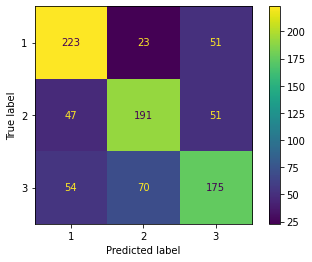


#### results for lowest loss model ####
Accuracy of: 0.6486


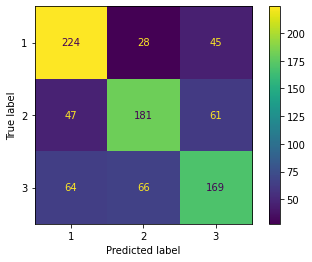


####################################################
# RESULTS FOR SUBJECT C
####################################################



OSError: No file or directory found at saved_variables/8/calibration/EEGNet/samesubject_differentsession/subjectC/trained_model_lowest_loss_model.hdf5

In [36]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the test labels
        with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/y_test.pickle", 'rb') as f:
            y_test = pickle.load(f)
            
        # Get the test data
        with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/X_test.pickle", 'rb') as f:
            X_test = pickle.load(f)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/4/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Inverse y_test to label
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr><hr>

## Subsampling electrodes

According to Kaya et al., the authors of the used dataset, the channels of most interest are C3, C4, T3, T4 and Cz.

